In [1]:
import os
import imageio.v2 as imageio
import cartopy.crs as ccrs
import pypsa 
import xarray as xr
from pypsa.descriptors import Dict
import pypsa_create_basic_network as basic
import pypsa_pf_stat as psastat
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', None)  # or specify a number if you want a limit
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)


In [2]:
"""
Basic Settings for Data Input and Output
"""

# LV_list = ['211-1_0_4', '39-1_1_2', '214-1_0_2', '227-10_0_6',
#            '214-1_1_5', '216-2_1_3', '214-1_2_2', '216-2_0_2', '216-1_1_3',
#            '216-1_2_4', '216-3_0_5', '39-1_0_4', '225-2_0_3', '225-4_0_3',
#            '225-1_0_6', '225-2_1_5', '225-3_0_6', '298-1_1_4', '298-4_0_2',
#            '225-5_0_5', '230-106_0_2', '298-2_0_5', '298-7_1_3', '298-7_0_3',
#            '298-5_0_5', '298-6_0_2','298-3_0_3', '298-8_0_7', '227-12_0_5',
#            '227-7_0_5', '227-10_1_3', '227-11_0_4', '230-150_0_2',
#            '227-9_0_5', '230-202_0_2', '230-180_0_4', '230-197_0_5',
#            '230-200_0_4', '230-202_1_3', '230-201_0_6', '230-211_0_2',
#            '230-212_0_3', '230-212_1_3', '230-108_0_6', '227-13_0_3',
#            '227-14_0_4', '227-8_0_10', '227-13_1_3', '227-1_0_5', '227-6_1_4',
#            '227-3_0_5', '298-9_0_5', '298-6_1_4', '298-4_1_5']

MV_feeder = False
grid = "369_0"
folder = '211-1_0_4'
scenario_year = 2050
weekday = "Friday"
day_start_ts = pd.to_datetime(f"{scenario_year}-01-07 00:00:00")
day_start = day_start_ts.day
day_end_ts = pd.to_datetime(f"{scenario_year}-01-08 00:00:00")
# month = day_start_ts.month
monitor_hr = int((day_end_ts - day_start_ts).total_seconds() / 3600)
path_controlled = f"{grid}/{scenario_year}_{weekday}_01_07_controlled"
path_uncontrolled = f"{grid}/{scenario_year}_{weekday}_01_07_uncontrolled"
lv_pf = 0.97
mv_pf = 0.9
experiment = 'ev_optimize'

In [3]:
def make_save_path(MV_feeder, path_controlled, path_uncontrolled, folder=None, experiment=None):
    if MV_feeder:
        os.makedirs(
            f"/Users/huiwen/Library/Mobile Documents/com~apple~CloudDocs/Thesis/mobility/{path_controlled}/{experiment}",
            exist_ok=True)
        os.makedirs(
            f"/Users/huiwen/Library/Mobile Documents/com~apple~CloudDocs/Thesis/mobility/{path_uncontrolled}/{experiment}",
            exist_ok=True)
        save_path_controlled = f"/Users/huiwen/Library/Mobile Documents/com~apple~CloudDocs/Thesis/mobility/{path_controlled}/{experiment}"
        save_path_uncontrolled = f"/Users/huiwen/Library/Mobile Documents/com~apple~CloudDocs/Thesis/mobility/{path_uncontrolled}/{experiment}"
    else:
        os.makedirs(
            f"/Users/huiwen/Library/Mobile Documents/com~apple~CloudDocs/Thesis/mobility/{path_controlled}/{folder}/{experiment}",
            exist_ok=True)
        os.makedirs(
            f"/Users/huiwen/Library/Mobile Documents/com~apple~CloudDocs/Thesis/mobility/{path_uncontrolled}/{folder}/{experiment}",
            exist_ok=True)
        save_path_controlled = f"/Users/huiwen/Library/Mobile Documents/com~apple~CloudDocs/Thesis/mobility/{path_controlled}/{folder}/{experiment}"
        save_path_uncontrolled = f"/Users/huiwen/Library/Mobile Documents/com~apple~CloudDocs/Thesis/mobility/{path_uncontrolled}/{folder}/{experiment}"
    return save_path_controlled, save_path_uncontrolled

In [4]:
def build_net(MV_feeder, folder, grid, day_start_ts, monitor_hr, scenario_year,override_components,override_component_attrs):
    if MV_feeder:
        net = basic.build_MV_LV_net(MV_case_id=grid,override_components=override_components,override_component_attrs=override_component_attrs);
    else:
        net = basic.build_LV_net(case_id=folder,override_components=override_components,override_component_attrs=override_component_attrs);

    net_base = basic.add_base_load(net, day_start_ts, monitor_hr);
    net_hp = basic.add_hp_profile(net_base,day_start_ts);
    net_pv = basic.add_pv_profile(net_hp.copy(), day_start_ts);
    net_controlled = basic.add_ev_profile_storage(net_pv.copy(), path_controlled, grid, day_start_ts, monitor_hr, scenario_year)
    net_uncontrolled = basic.add_ev_profile_storage(net_pv.copy(), path_uncontrolled, grid, day_start_ts, monitor_hr,
                                            scenario_year)
    return net_controlled, net_uncontrolled

In [5]:
def override_storage_unit():
    override_components = pypsa.components.components.copy()
    override_component_attrs = Dict(
        {k: v.copy() for k, v in pypsa.components.component_attrs.items()}
    )
    override_component_attrs['StorageUnit'].loc['parking_hr']=["static or series","hr","0","Ev hourly parking time connected at this bus","Input(optional)"]
    override_component_attrs['StorageUnit'].loc['day_end_SoC']=["static","kWh","0","Emob day end SoE","Input(optional)"]
    override_component_attrs['StorageUnit'].loc['next_consumption'] = ["static","kWh","0","Energy next 2 trips required","Input(optional)"]
    override_component_attrs['StorageUnit'].loc['park_end_time_idx'] = ["static","hr","23","Parking end i-th hour of monitoring period","Input(optional)"]
    return override_components,override_component_attrs

In [7]:
def optimize_ev(net):
    M=1e10

    m=net.optimize.create_model()

    m.constraints.remove("StorageUnit-energy_balance")
    m.constraints.remove("Generator-p_set")

    ev = pd.Index(set(net.storage_units.carrier.unique()), name='ev')
    carrier = net.storage_units.carrier.to_xarray()
    pv_idx = net.generators.loc[net.generators.index.str.contains('PV')].index

    m.add_variables(coords=[net.snapshots,net.storage_units.index],name='charge_event',binary=True)
    m.add_variables(coords=[net.snapshots,net.storage_units.index],name='discharge_event',binary=True)
    m.add_variables(coords=[net.snapshots,net.storage_units.index],name='store_jump',binary=True)
    m.add_variables(coords=[net.snapshots,net.storage_units.index],name='dispatch_jump',binary=True)

    m.add_variables(coords=[net.snapshots,ev],name='delta_E')
    m.add_variables(coords=[net.snapshots,ev],name='carrier_SoC')
    

    # Identify charge/discharge from StorageUnit-p_store/StorageUnit-p_dispatch
    charging_1 = m.variables['StorageUnit-p_store']<=M*m.variables['charge_event']
    charging_2 = m.variables['StorageUnit-p_store']+M*m.variables['charge_event']>=1-M
    m.add_constraints(charging_1,name='identify_charging_1')
    m.add_constraints(charging_2,name='identify_charging_2')

    discharging_1 = m.variables['StorageUnit-p_dispatch']<=M*m.variables['discharge_event']
    discharging_2 = m.variables['StorageUnit-p_dispatch']+M*m.variables['discharge_event']>=1-M
    m.add_constraints(discharging_1,name='identify_discharging_1')
    m.add_constraints(discharging_2,name='identify_discharging_2')

    # Exclude simultaneous charging and discharging
    non_simultaneous = m.variables['charge_event']+m.variables['discharge_event']<=1
    m.add_constraints(non_simultaneous,name='non_simultaneous')
    
    # Park End SoC covers next trip consumption
    end_idx = net.storage_units.park_end_time_idx.to_xarray()
    selected_snapshots = [net.snapshots[int(idx)] for idx in end_idx.values]
    m.add_constraints(m.variables['StorageUnit-state_of_charge'].sel(snapshot=xr.DataArray(selected_snapshots, coords=[net.storage_units.index]))>=net.storage_units.next_consumption, name="next_trip_consumption")


    # Limit V2G participation level at each snapshot
    m.add_constraints((m.variables['charge_event']+m.variables['discharge_event']).sum(dim='StorageUnit')<=0.3*(net.storage_units_t.parking_hr>0).sum(axis=1),name='v2g_participation')
    
    # Detect charge/discharge start
    delta_p_store = m.variables['StorageUnit-p_store']-m.variables['StorageUnit-p_store'].shift(snapshot=1,fill_value=0)
    detect_store_jump_1 = delta_p_store<=M*m.variables['store_jump']
    m.add_constraints(detect_store_jump_1,name='detect_store_jump_1')
    detect_store_jump_2 = delta_p_store+M*m.variables['store_jump']>=1-M
    m.add_constraints(detect_store_jump_2,name='detect_store_jump_2')

    delta_p_dispatch = m.variables['StorageUnit-p_dispatch']-m.variables['StorageUnit-p_dispatch'].shift(snapshot=1,fill_value=0)
    detect_dispatch_jump_1 = delta_p_dispatch<=M*m.variables['dispatch_jump']
    m.add_constraints(detect_dispatch_jump_1,name='detect_dispatch_jump_1')
    detect_dispatch_jump_2 = delta_p_dispatch+M*m.variables['dispatch_jump']>=1-M
    m.add_constraints(detect_dispatch_jump_2,name='detect_dispatch_jump_2')

    # Limit the charge/discharge number for each parking event
    event_cnt = m.variables['dispatch_jump'].sum(dim='snapshot')+m.variables['store_jump'].sum(dim='snapshot')
    m.add_constraints(event_cnt<=1,name='limit_event_cnt')

    # agg EV charge/discharge power
    m.add_constraints(m.variables['delta_E']==((m.variables['StorageUnit-p_store']*net.storage_units_t.parking_hr).groupby(carrier).sum()-(m.variables['StorageUnit-p_dispatch']*net.storage_units_t.parking_hr).groupby(carrier).sum()).sel(carrier=m.variables['delta_E'].coords['ev']), name='agg_ev_delta_E')

    # agg EV SoC Update
    mask_first_sns = xr.DataArray(net.snapshots==net.snapshots[0],coords=[net.snapshots])
    m.add_constraints(m.variables['StorageUnit-state_of_charge'].where(mask_first_sns)==net.storage_units.state_of_charge_initial,name='force_initial_SoC')
    m.add_constraints((m.variables['carrier_SoC']-m.variables['StorageUnit-state_of_charge'].groupby(carrier).sum().sel(carrier=m.variables['carrier_SoC'].coords['ev'])).where(mask_first_sns)==0,name='force_initial_agg_SoC')
    pre_SoC = m.variables['carrier_SoC'].shift(snapshot=1)
    m.add_constraints((pre_SoC+m.variables['delta_E'].shift(snapshot=1)-m.variables['carrier_SoC']).where(~mask_first_sns)==0,name='update_following_SoC') #current sns SoC = pre_SoC+pre sns delta P_store


    # map carrier_SoC back to parking_events
    m.add_constraints(m.variables['StorageUnit-state_of_charge'].where(~mask_first_sns) == m.variables['carrier_SoC'].sel(ev=carrier.sel(StorageUnit=m.variables['StorageUnit-state_of_charge'].coords['StorageUnit'])).where(~mask_first_sns),name='map_to_carrier_SoC')

    # Objective to keep day end soc as the same level as possible
    # quad_soc_diff  = (m.variables['StorageUnit-state_of_charge']**2-2*m.variables['StorageUnit-state_of_charge']*net.storage_units.day_end_SoC/1000).where(xr.DataArray(net.snapshots==net.snapshots[23],coords=[net.snapshots])).sum(dim='StorageUnit').sel(snapshot=net.snapshots[23])
    m.objective = -m.variables['Generator-p'].sel(Generator=pv_idx).sum().sum()

    solver_opt = {
        "Method":-1,          # Automatic
        "MIPFocus": 1,         # Focus on finding feasible solutions
        "Heuristics": 0.3,     # Set the time spent on heuristics to 10%
        "MIPGap": 0.3         # Set the acceptable optimality gap to 1%
    }
    result = net.optimize.solve_model(solver_name='gurobi', solver_options=solver_opt)

    # # Check the result status and print infeasibilities if necessary
    # if result[0]!='ok':
        # m.print_infeasibilities()
 
    return net


In [8]:
override_components,override_component_attrs = override_storage_unit()
if MV_feeder:
    save_paths = make_save_path(MV_feeder, path_controlled, path_uncontrolled, None, experiment)
    nets = build_net(MV_feeder=MV_feeder, folder=None, grid=grid, day_start_ts=day_start_ts,
                        monitor_hr=monitor_hr, scenario_year=scenario_year,override_components=override_components,override_component_attrs=override_component_attrs)

else:
    for folder in [folder]:
        save_paths = make_save_path(MV_feeder, path_controlled, path_uncontrolled, folder, experiment)
        nets = build_net(MV_feeder=MV_feeder, folder=folder, grid=grid, day_start_ts=day_start_ts,
                            monitor_hr=monitor_hr, scenario_year=scenario_year,override_components=override_components,override_component_attrs=override_component_attrs)


Finish building LV 211-1_0_4
Finish Adding Heatpumps
Finish Adding EVs as StorageUnits
Finish Adding EVs as StorageUnits


In [30]:
net = nets[1]
M=1e10

m=net.optimize.create_model()

m.constraints.remove("StorageUnit-energy_balance")
m.constraints.remove("Generator-p_set")

ev = pd.Index(set(net.storage_units.carrier.unique()), name='ev')
carrier = net.storage_units.carrier.to_xarray()
pv_idx = net.generators.loc[net.generators.index.str.contains('PV')].index

m.add_variables(coords=[net.snapshots,net.storage_units.index],name='charge_event',binary=True)
m.add_variables(coords=[net.snapshots,net.storage_units.index],name='discharge_event',binary=True)
m.add_variables(coords=[net.snapshots,net.storage_units.index],name='store_jump',binary=True)
m.add_variables(coords=[net.snapshots,net.storage_units.index],name='dispatch_jump',binary=True)

m.add_variables(coords=[net.snapshots,ev],name='delta_E')
m.add_variables(coords=[net.snapshots,ev],name='carrier_SoC')


# Identify charge/discharge from StorageUnit-p_store/StorageUnit-p_dispatch
charging_1 = m.variables['StorageUnit-p_store']<=M*m.variables['charge_event']
charging_2 = m.variables['StorageUnit-p_store']+M*m.variables['charge_event']>=1-M
m.add_constraints(charging_1,name='identify_charging_1')
m.add_constraints(charging_2,name='identify_charging_2')

discharging_1 = m.variables['StorageUnit-p_dispatch']<=M*m.variables['discharge_event']
discharging_2 = m.variables['StorageUnit-p_dispatch']+M*m.variables['discharge_event']>=1-M
m.add_constraints(discharging_1,name='identify_discharging_1')
m.add_constraints(discharging_2,name='identify_discharging_2')

# Exclude simultaneous charging and discharging
non_simultaneous = m.variables['charge_event']+m.variables['discharge_event']<=1
m.add_constraints(non_simultaneous,name='non_simultaneous')

# Park End SoC covers next trip consumption
end_idx = net.storage_units.park_end_time_idx.to_xarray()
selected_snapshots = [net.snapshots[min(int(idx)+1,23)] for idx in end_idx.values]
m.add_constraints(m.variables['StorageUnit-state_of_charge'].sel(snapshot=xr.DataArray(selected_snapshots, coords=[net.storage_units.index]))>=net.storage_units.next_consumption, name="next_trip_consumption")


# Limit V2G participation level at each snapshot
m.add_constraints((m.variables['charge_event']+m.variables['discharge_event']).sum(dim='StorageUnit')<=0.3*(net.storage_units_t.parking_hr>0).sum(axis=1),name='v2g_participation')

# Detect charge/discharge start
delta_p_store = m.variables['StorageUnit-p_store']-m.variables['StorageUnit-p_store'].shift(snapshot=1,fill_value=0)
detect_store_jump_1 = delta_p_store<=M*m.variables['store_jump']
m.add_constraints(detect_store_jump_1,name='detect_store_jump_1')
detect_store_jump_2 = delta_p_store+M*m.variables['store_jump']>=1-M
m.add_constraints(detect_store_jump_2,name='detect_store_jump_2')

delta_p_dispatch = m.variables['StorageUnit-p_dispatch']-m.variables['StorageUnit-p_dispatch'].shift(snapshot=1,fill_value=0)
detect_dispatch_jump_1 = delta_p_dispatch<=M*m.variables['dispatch_jump']
m.add_constraints(detect_dispatch_jump_1,name='detect_dispatch_jump_1')
detect_dispatch_jump_2 = delta_p_dispatch+M*m.variables['dispatch_jump']>=1-M
m.add_constraints(detect_dispatch_jump_2,name='detect_dispatch_jump_2')

# Limit the charge/discharge number for each parking event
event_cnt = m.variables['dispatch_jump'].sum(dim='snapshot')+m.variables['store_jump'].sum(dim='snapshot')
m.add_constraints(event_cnt<=1,name='limit_event_cnt')

# agg EV charge/discharge power
m.add_constraints(m.variables['delta_E']==((m.variables['StorageUnit-p_store']*net.storage_units_t.parking_hr).groupby(carrier).sum()-(m.variables['StorageUnit-p_dispatch']*net.storage_units_t.parking_hr).groupby(carrier).sum()).sel(carrier=m.variables['delta_E'].coords['ev']), name='agg_ev_delta_E')

# agg EV SoC Update
mask_first_sns = xr.DataArray(net.snapshots==net.snapshots[0],coords=[net.snapshots])
# m.add_constraints(m.variables['StorageUnit-state_of_charge'].where(mask_first_sns)==net.storage_units.state_of_charge_initial,name='force_initial_SoC')
m.add_constraints(m.variables['StorageUnit-state_of_charge'].sel(snapshot=net.snapshots[0])==net.storage_units.state_of_charge_initial,name='force_intial_SoC')
m.add_constraints((m.variables['carrier_SoC']-m.variables['StorageUnit-state_of_charge'].groupby(carrier).sum().sel(carrier=m.variables['carrier_SoC'].coords['ev'])).where(mask_first_sns)==0,name='force_initial_agg_SoC')
pre_SoC = m.variables['carrier_SoC'].shift(snapshot=1)
m.add_constraints((pre_SoC+m.variables['delta_E'].shift(snapshot=1)-m.variables['carrier_SoC']).where(~mask_first_sns)==0,name='update_following_SoC') #current sns SoC = pre_SoC+pre sns delta P_store


# map carrier_SoC back to parking_events
m.add_constraints(m.variables['StorageUnit-state_of_charge'].where(~mask_first_sns) == m.variables['carrier_SoC'].sel(ev=carrier.sel(StorageUnit=m.variables['StorageUnit-state_of_charge'].coords['StorageUnit'])).where(~mask_first_sns),name='map_to_carrier_SoC')

# Objective to keep day end soc as the same level as possible
# quad_soc_diff  = (m.variables['StorageUnit-state_of_charge']**2-2*m.variables['StorageUnit-state_of_charge']*net.storage_units.day_end_SoC/1000).where(xr.DataArray(net.snapshots==net.snapshots[23],coords=[net.snapshots])).sum(dim='StorageUnit').sel(snapshot=net.snapshots[23])
m.objective = -m.variables['Generator-p'].sel(Generator=pv_idx).sum().sum()

solver_opt = {
    "Method":-1,          # Automatic
    "MIPFocus": 1,         # Focus on finding feasible solutions
    "Heuristics": 0.3,     # Set the time spent on heuristics to 10%
    "MIPGap": 0.3         # Set the acceptable optimality gap to 1%
}
net.optimize.solve_model(solver_name='gurobi', solver_options=solver_opt)
m.print_infeasibilities()

INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - Method: -1
 - MIPFocus: 1
 - Heuristics: 0.3
 - MIPGap: 0.3


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-02-19


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-02-19
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 4/4 [00:00<00:00, 108.10it/s]
INFO:linopy.io: Writing time: 1.57s


Read LP format model from file /private/var/folders/xp/pv3t69qj4q11g2bjy5l0qfv40000gn/T/linopy-problem-vxz7x3db.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/xp/pv3t69qj4q11g2bjy5l0qfv40000gn/T/linopy-problem-vxz7x3db.lp


Reading time = 0.68 seconds


INFO:gurobipy:Reading time = 0.68 seconds


obj: 341194 rows, 158376 columns, 736399 nonzeros


INFO:gurobipy:obj: 341194 rows, 158376 columns, 736399 nonzeros


Set parameter MIPFocus to value 1


INFO:gurobipy:Set parameter MIPFocus to value 1


Set parameter Heuristics to value 0.3


INFO:gurobipy:Set parameter Heuristics to value 0.3


Set parameter MIPGap to value 0.3


INFO:gurobipy:Set parameter MIPGap to value 0.3


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (mac64[rosetta2] - Darwin 23.3.0 23D60)


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (mac64[rosetta2] - Darwin 23.3.0 23D60)


INFO:gurobipy:


CPU model: Apple M1 Pro


INFO:gurobipy:CPU model: Apple M1 Pro


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 341194 rows, 158376 columns and 736399 nonzeros


INFO:gurobipy:Optimize a model with 341194 rows, 158376 columns and 736399 nonzeros


Model fingerprint: 0xb698213e


INFO:gurobipy:Model fingerprint: 0xb698213e


Variable types: 87624 continuous, 70752 integer (70752 binary)


INFO:gurobipy:Variable types: 87624 continuous, 70752 integer (70752 binary)


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [2e-02, 1e+10]


INFO:gurobipy:  Matrix range     [2e-02, 1e+10]


  Objective range  [1e+00, 1e+00]


INFO:gurobipy:  Objective range  [1e+00, 1e+00]


  Bounds range     [1e+00, 1e+00]


INFO:gurobipy:  Bounds range     [1e+00, 1e+00]


  RHS range        [6e-08, 1e+10]


INFO:gurobipy:  RHS range        [6e-08, 1e+10]


INFO:gurobipy:Warning: Model contains large matrix coefficients


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 202 rows and 202 columns


INFO:gurobipy:Presolve removed 202 rows and 202 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


INFO:gurobipy:


Explored 0 nodes (0 simplex iterations) in 0.14 seconds (0.15 work units)


INFO:gurobipy:Explored 0 nodes (0 simplex iterations) in 0.14 seconds (0.15 work units)


Thread count was 1 (of 8 available processors)


INFO:gurobipy:Thread count was 1 (of 8 available processors)


INFO:gurobipy:


Solution count 0


INFO:gurobipy:Solution count 0


INFO:gurobipy:


Model is infeasible or unbounded


INFO:gurobipy:Model is infeasible or unbounded


Best objective -, best bound -, gap -


INFO:gurobipy:Best objective -, best bound -, gap -
Status: warning
Termination condition: infeasible_or_unbounded
Solution: 0 primals, 0 duals
Objective: nan
Solver model: available
Solver message: 4



Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (mac64[rosetta2] - Darwin 23.3.0 23D60)


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (mac64[rosetta2] - Darwin 23.3.0 23D60)


INFO:gurobipy:


CPU model: Apple M1 Pro


INFO:gurobipy:CPU model: Apple M1 Pro


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


IIS computation: initial model status unknown, solving to determine model status


INFO:gurobipy:IIS computation: initial model status unknown, solving to determine model status


Presolve removed 202 rows and 202 columns


INFO:gurobipy:Presolve removed 202 rows and 202 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


INFO:gurobipy:


Explored 0 nodes (0 simplex iterations) in 0.21 seconds (0.15 work units)


INFO:gurobipy:Explored 0 nodes (0 simplex iterations) in 0.21 seconds (0.15 work units)


Thread count was 1 (of 8 available processors)


INFO:gurobipy:Thread count was 1 (of 8 available processors)


INFO:gurobipy:


Solution count 0


INFO:gurobipy:Solution count 0


INFO:gurobipy:


Model is infeasible


INFO:gurobipy:Model is infeasible


Best objective -, best bound -, gap -


INFO:gurobipy:Best objective -, best bound -, gap -


INFO:gurobipy:


Computing Irreducible Inconsistent Subsystem (IIS)...


INFO:gurobipy:Computing Irreducible Inconsistent Subsystem (IIS)...


INFO:gurobipy:


           Constraints          |            Bounds           |  Runtime


INFO:gurobipy:           Constraints          |            Bounds           |  Runtime


      Min       Max     Guess   |   Min       Max     Guess   |


INFO:gurobipy:      Min       Max     Guess   |   Min       Max     Guess   |


--------------------------------------------------------------------------


INFO:gurobipy:--------------------------------------------------------------------------


        0    338360         -         0         0         0           0s


INFO:gurobipy:        0    338360         -         0         0         0           0s


        0        26         -         0         0         0          35s


INFO:gurobipy:        0        26         -         0         0         0          35s


       26        26        26         0         0         0          38s


INFO:gurobipy:       26        26        26         0         0         0          38s


INFO:gurobipy:


IIS computed: 26 constraints, 0 bounds


INFO:gurobipy:IIS computed: 26 constraints, 0 bounds


IIS runtime: 38.31 seconds (81.41 work units)


INFO:gurobipy:IIS runtime: 38.31 seconds (81.41 work units)


StorageUnit-fix-p_dispatch-lower[2050-01-07 09:00:00, ev_7611913_483234_211-1_0_4_node_245_nan]: +1 StorageUnit-p_dispatch[2050-01-07 09:00:00, ev_7611913_483234_211-1_0_4_node_245_nan] ≥ -0
StorageUnit-fix-p_store-upper[2050-01-07 09:00:00, ev_7611913_483234_211-1_0_4_node_245_nan]: +1 StorageUnit-p_store[2050-01-07 09:00:00, ev_7611913_483234_211-1_0_4_node_245_nan] ≤ 0.022
next_trip_consumption[ev_7611913_483234_211-1_0_4_node_245_nan]: +1 StorageUnit-state_of_charge[2050-01-07 10:00:00, ev_7611913_483234_211-1_0_4_node_245_nan] ≥ 0.0110850357137
agg_ev_delta_E[2050-01-07 00:00:00, 2335868]: +1 delta_E[2050-01-07 00:00:00, 2335868] = -0
agg_ev_delta_E[2050-01-07 00:00:00, 7233699]: +1 delta_E[2050-01-07 00:00:00, 7233699] - 1 StorageUnit-p_store[2050-01-07 00:00:00, ev_7233699_182465_211-1_0_4_node_222_0] + 1 StorageUnit-p_dispatch[2050-01-07 00:00:00, ev_7233699_182465_211-1_0_4_node_222_0] = -0
agg_ev_delta_E[2050-01-07 00:00:00, 8617104]: +1 delta_E[2050-01-07 00:00:00, 8617104] 

In [26]:
m.variables['StorageUnit-state_of_charge'].sel(snapshot=net.snapshots[0])==net.storage_units.state_of_charge_initial

Constraint (unassigned) (StorageUnit: 737):
-------------------------------------------
[ev_109999_388_211-1_0_4_node_21_nan]: +1 StorageUnit-state_of_charge[2050-01-07 00:00:00, ev_109999_388_211-1_0_4_node_21_nan]             = 0.08755
[ev_298249_2425_211-1_0_4_node_21_nan]: +1 StorageUnit-state_of_charge[2050-01-07 00:00:00, ev_298249_2425_211-1_0_4_node_21_nan]           = 0.07626999999999999
[ev_298249_2431_211-1_0_4_node_21_nan]: +1 StorageUnit-state_of_charge[2050-01-07 00:00:00, ev_298249_2431_211-1_0_4_node_21_nan]           = -0.0
[ev_302369_2479_211-1_0_4_node_21_nan]: +1 StorageUnit-state_of_charge[2050-01-07 00:00:00, ev_302369_2479_211-1_0_4_node_21_nan]           = 0.0471
[ev_445781_4011_211-1_0_4_node_343_nan]: +1 StorageUnit-state_of_charge[2050-01-07 00:00:00, ev_445781_4011_211-1_0_4_node_343_nan]         = 0.07557
[ev_466934_13735_211-1_0_4_node_327_nan]: +1 StorageUnit-state_of_charge[2050-01-07 00:00:00, ev_466934_13735_211-1_0_4_node_327_nan]       = 0.04274
[ev_

In [11]:
m

Linopy MILP model

Variables:
----------
 * Generator-p (snapshot, Generator)
 * Line-s (snapshot, Line)
 * Transformer-s (snapshot, Transformer)
 * StorageUnit-p_dispatch (snapshot, StorageUnit)
 * StorageUnit-p_store (snapshot, StorageUnit)
 * StorageUnit-state_of_charge (snapshot, StorageUnit)
 * charge_event (snapshot, StorageUnit)
 * discharge_event (snapshot, StorageUnit)
 * store_jump (snapshot, StorageUnit)
 * dispatch_jump (snapshot, StorageUnit)
 * delta_E (snapshot, ev)
 * carrier_SoC (snapshot, ev)

Constraints:
------------
 * Generator-fix-p-lower (snapshot, Generator-fix)
 * Generator-fix-p-upper (snapshot, Generator-fix)
 * Line-fix-s-lower (snapshot, Line-fix)
 * Line-fix-s-upper (snapshot, Line-fix)
 * Transformer-fix-s-lower (snapshot, Transformer-fix)
 * Transformer-fix-s-upper (snapshot, Transformer-fix)
 * StorageUnit-fix-p_dispatch-lower (snapshot, StorageUnit-fix)
 * StorageUnit-fix-p_dispatch-upper (snapshot, StorageUnit-fix)
 * StorageUnit-fix-p_store-lower (s

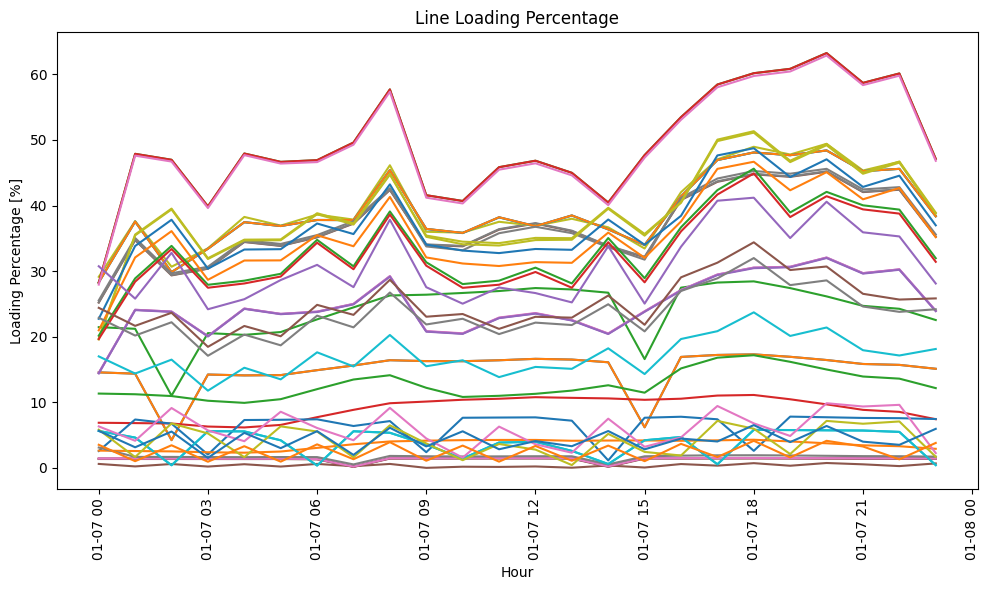

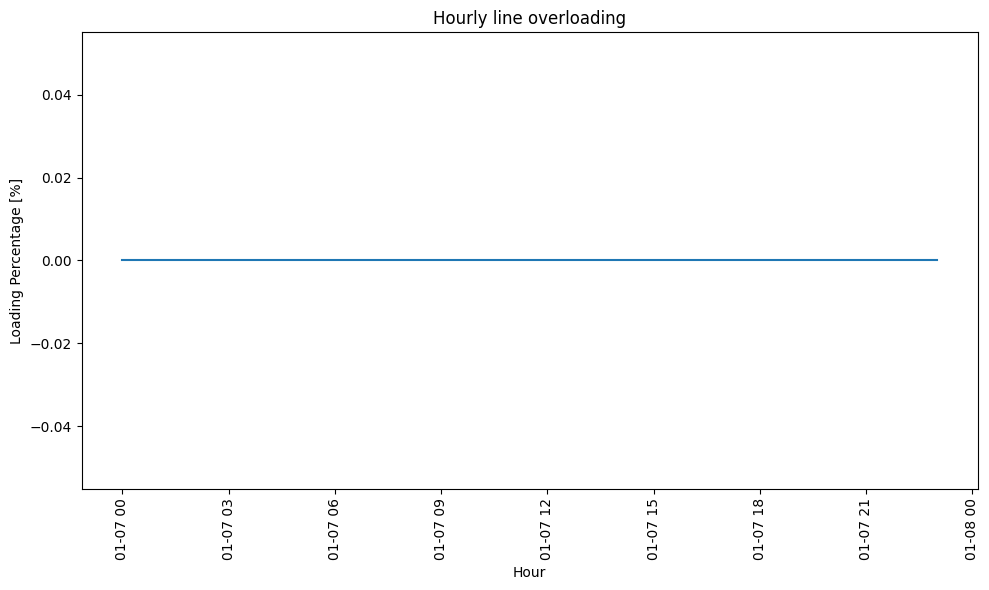

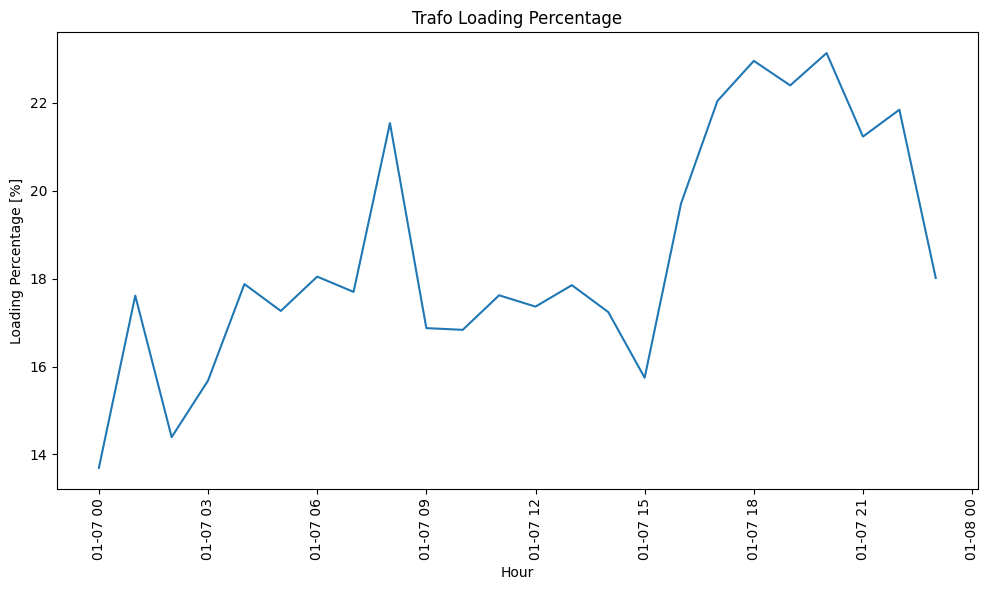

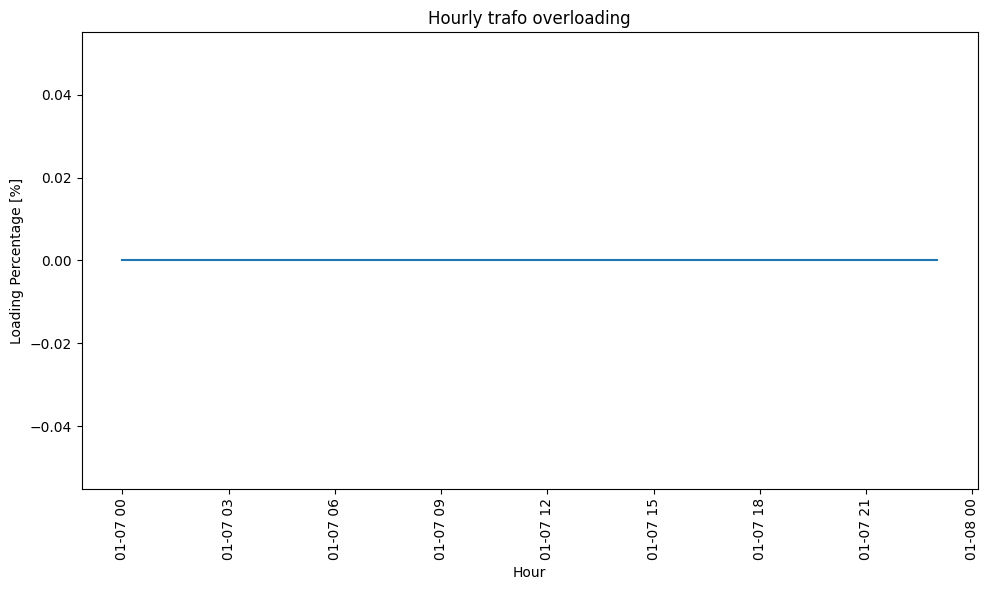

In [9]:
line_controlled = psastat.opt_line_loading(net_optimized)
line_stat_controlled = psastat.opt_line_overloading_stat(net_optimized)
trafo_controlled = psastat.opt_trafo_loading(net_optimized)
trafo_stat_controlled = psastat.opt_trafo_overloading_stat(net_optimized)


fig,ax=plt.subplots(figsize=(10,6))
ax.plot(line_controlled)
ax.set_title("Line Loading Percentage")
# ax.set_ylim([-5,line_controlled.max()])
ax.set_xlabel("Hour")
ax.set_ylabel("Loading Percentage [%]")
ax.tick_params(axis='x', rotation=90)
plt.tight_layout()

fig,ax=plt.subplots(figsize=(10,6))
ax.plot(line_stat_controlled)
ax.set_title("Hourly line overloading")
# ax.set_ylim([-5,line_controlled.max()])
ax.set_xlabel("Hour")
ax.set_ylabel("Loading Percentage [%]")
ax.tick_params(axis='x', rotation=90)
plt.tight_layout()

fig,ax=plt.subplots(figsize=(10,6))
ax.plot(trafo_controlled)
ax.set_title("Trafo Loading Percentage")

ax.set_xlabel("Hour")
ax.set_ylabel("Loading Percentage [%]")
ax.tick_params(axis='x', rotation=90)
plt.tight_layout()

fig,ax=plt.subplots(figsize=(10,6))
ax.plot(trafo_stat_controlled)
ax.set_title("Hourly trafo overloading")

ax.set_xlabel("Hour")
ax.set_ylabel("Loading Percentage [%]")
ax.tick_params(axis='x', rotation=90)
plt.tight_layout()


In [10]:
# Fix power 
pv_id = net_optimized.generators.loc[net_optimized.generators.index.str.contains('PV')].index

net_optimized.generators_t.p_set[pv_id] = net_optimized.generators_t.p[pv_id]
net_optimized.generators_t.q_set[pv_id] = np.tan(np.arccos(0.97))*net_optimized.generators_t.p[pv_id]

net_optimized.storage_units_t.p_set = net_optimized.storage_units_t.p
net_optimized.storage_units_t.q_set = np.tan(np.arccos(0.97))*net_optimized.storage_units_t.p

In [11]:
net_optimized.lpf()
net_optimized.pf(use_seed=True)

INFO:pypsa.pf:Performing linear load-flow on AC sub-network SubNetwork 0 for snapshot(s) DatetimeIndex(['2050-01-07 00:00:00', '2050-01-07 01:00:00',
               '2050-01-07 02:00:00', '2050-01-07 03:00:00',
               '2050-01-07 04:00:00', '2050-01-07 05:00:00',
               '2050-01-07 06:00:00', '2050-01-07 07:00:00',
               '2050-01-07 08:00:00', '2050-01-07 09:00:00',
               '2050-01-07 10:00:00', '2050-01-07 11:00:00',
               '2050-01-07 12:00:00', '2050-01-07 13:00:00',
               '2050-01-07 14:00:00', '2050-01-07 15:00:00',
               '2050-01-07 16:00:00', '2050-01-07 17:00:00',
               '2050-01-07 18:00:00', '2050-01-07 19:00:00',
               '2050-01-07 20:00:00', '2050-01-07 21:00:00',
               '2050-01-07 22:00:00', '2050-01-07 23:00:00'],
              dtype='datetime64[ns]', name='snapshot', freq='h')
INFO:pypsa.pf:Performing non-linear load-flow on AC sub-network SubNetwork 0 for snapshots DatetimeIndex(['2050-0

{'n_iter': SubNetwork           0
 snapshot              
 2050-01-07 00:00:00  2
 2050-01-07 01:00:00  2
 2050-01-07 02:00:00  2
 2050-01-07 03:00:00  2
 2050-01-07 04:00:00  2
 2050-01-07 05:00:00  2
 2050-01-07 06:00:00  2
 2050-01-07 07:00:00  2
 2050-01-07 08:00:00  3
 2050-01-07 09:00:00  2
 2050-01-07 10:00:00  2
 2050-01-07 11:00:00  2
 2050-01-07 12:00:00  2
 2050-01-07 13:00:00  2
 2050-01-07 14:00:00  2
 2050-01-07 15:00:00  2
 2050-01-07 16:00:00  3
 2050-01-07 17:00:00  3
 2050-01-07 18:00:00  3
 2050-01-07 19:00:00  3
 2050-01-07 20:00:00  3
 2050-01-07 21:00:00  3
 2050-01-07 22:00:00  3
 2050-01-07 23:00:00  2,
 'error': SubNetwork                      0
 snapshot                         
 2050-01-07 00:00:00  2.186445e-07
 2050-01-07 01:00:00  5.518811e-07
 2050-01-07 02:00:00  4.269314e-07
 2050-01-07 03:00:00  3.327570e-07
 2050-01-07 04:00:00  4.835329e-07
 2050-01-07 05:00:00  4.755717e-07
 2050-01-07 06:00:00  6.132095e-07
 2050-01-07 07:00:00  7.015628e-07
 2050-

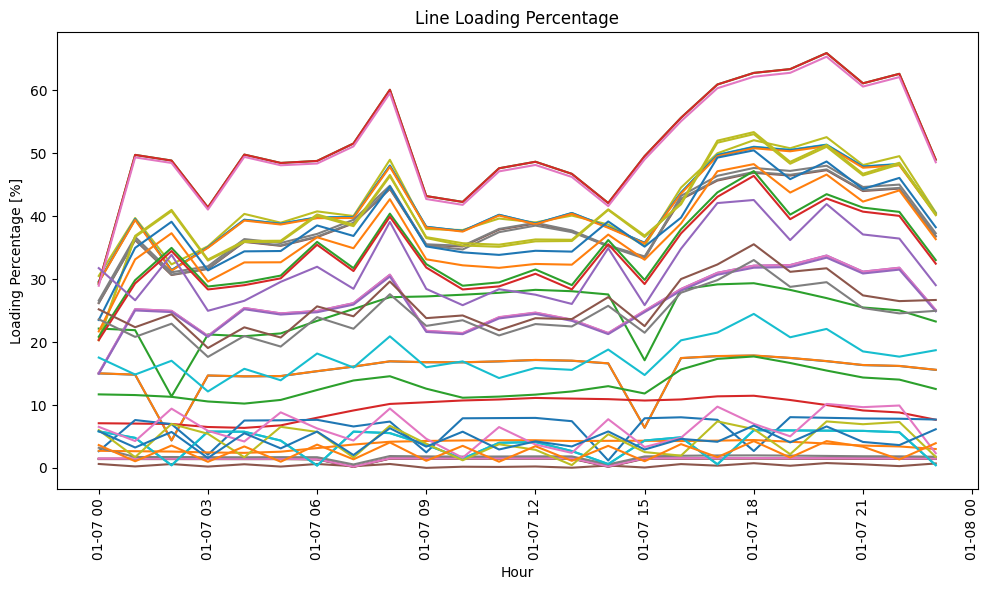

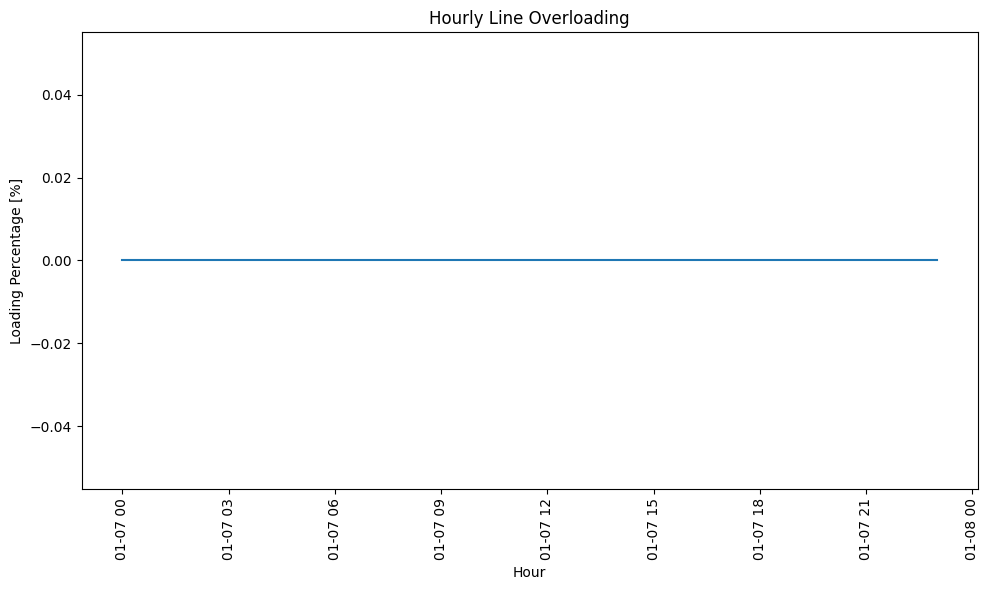

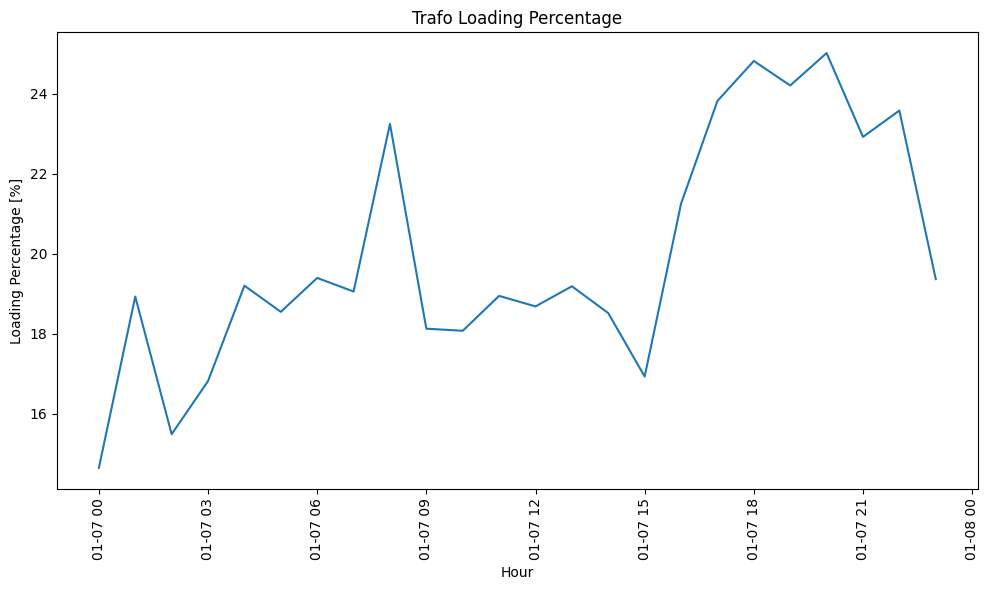

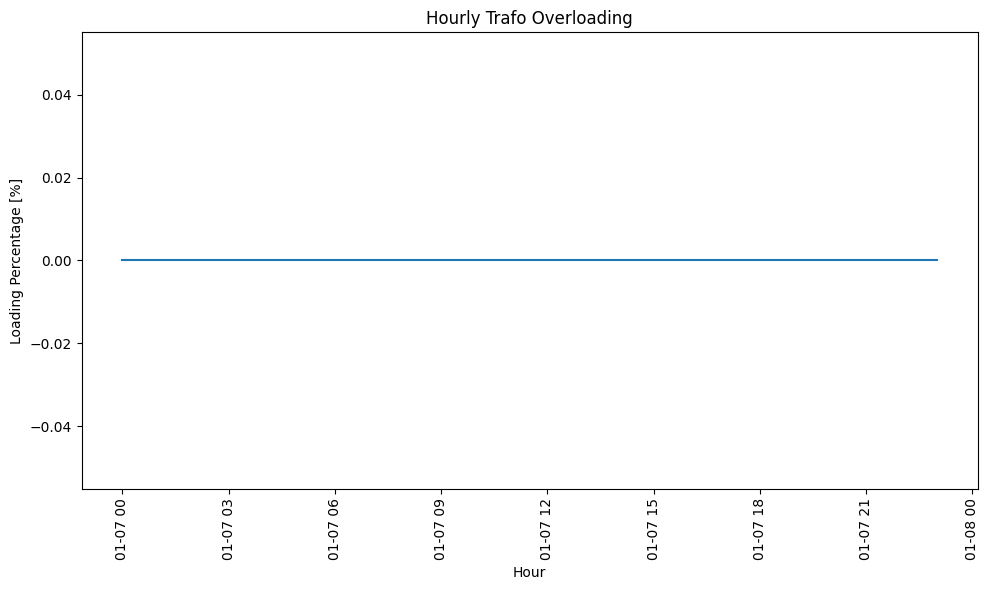

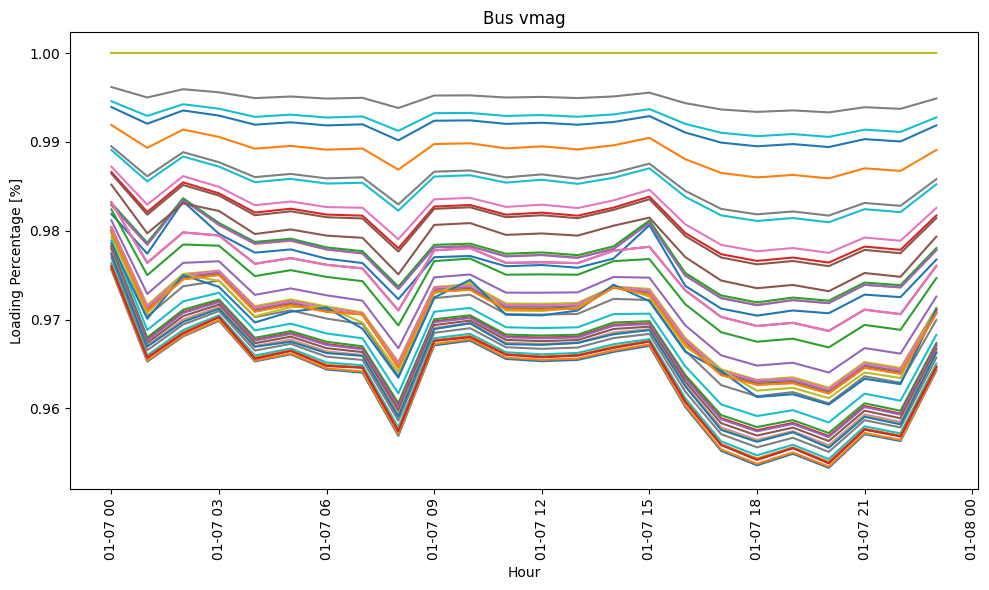

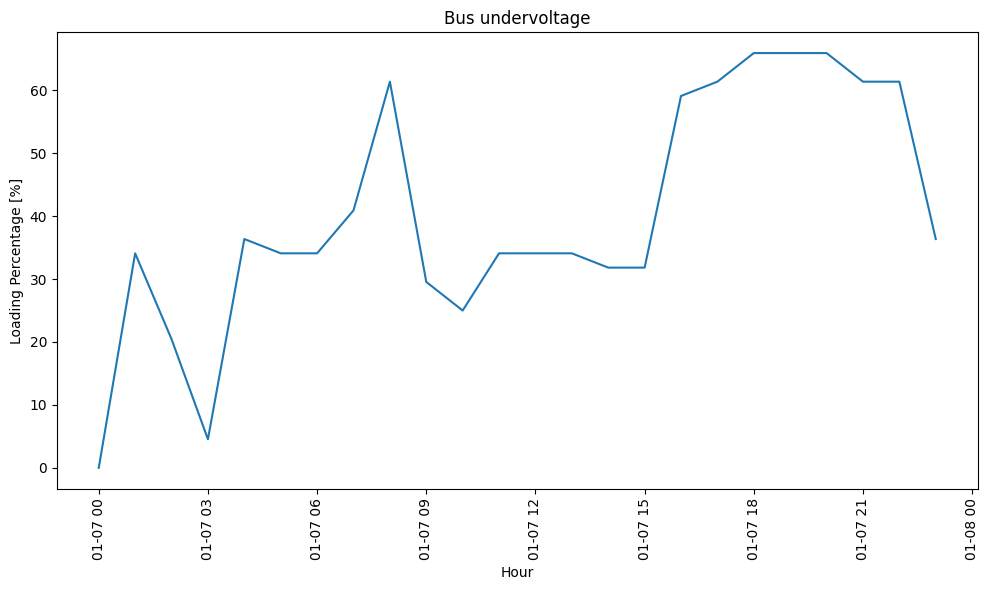

In [12]:
line_controlled = psastat.pf_line_loading(net_optimized)
line_stat_controlled = psastat.pf_line_overloading_stat(net_optimized)
trafo_controlled = psastat.pf_trafo_loading(net_optimized)
trafo_stat_controlled = psastat.pf_trafo_overloading_stat(net_optimized)
bus_vmag = net_optimized.buses_t.v_mag_pu
bus_stat_controlled = psastat.pf_undervoltage(net_optimized)

fig,ax=plt.subplots(figsize=(10,6))
ax.plot(line_controlled)
ax.set_title("Line Loading Percentage")
# ax.set_ylim([-5,line_controlled.max()])
ax.set_xlabel("Hour")
ax.set_ylabel("Loading Percentage [%]")
ax.tick_params(axis='x', rotation=90)
plt.tight_layout()

fig,ax=plt.subplots(figsize=(10,6))
ax.plot(line_stat_controlled)
ax.set_title("Hourly Line Overloading")
# ax.set_ylim([-5,line_controlled.max()])
ax.set_xlabel("Hour")
ax.set_ylabel("Loading Percentage [%]")
ax.tick_params(axis='x', rotation=90)
plt.tight_layout()


fig,ax=plt.subplots(figsize=(10,6))
ax.plot(trafo_controlled)
ax.set_title("Trafo Loading Percentage")

ax.set_xlabel("Hour")
ax.set_ylabel("Loading Percentage [%]")
ax.tick_params(axis='x', rotation=90)
plt.tight_layout()


fig,ax=plt.subplots(figsize=(10,6))
ax.plot(trafo_stat_controlled)
ax.set_title("Hourly Trafo Overloading")
# ax.set_ylim([-5,line_controlled.max()])
ax.set_xlabel("Hour")
ax.set_ylabel("Loading Percentage [%]")
ax.tick_params(axis='x', rotation=90)
plt.tight_layout()


fig,ax=plt.subplots(figsize=(10,6))
ax.plot(bus_vmag)
ax.set_title("Bus vmag")

ax.set_xlabel("Hour")
ax.set_ylabel("Loading Percentage [%]")
ax.tick_params(axis='x', rotation=90)
plt.tight_layout()

fig,ax=plt.subplots(figsize=(10,6))
ax.plot(bus_stat_controlled)
ax.set_title("Bus undervoltage")
# ax.set_ylim([-5,line_controlled.max()])
ax.set_xlabel("Hour")
ax.set_ylabel("Loading Percentage [%]")
ax.tick_params(axis='x', rotation=90)
plt.tight_layout()

In [13]:
end_SoE = net_optimized.storage_units_t.state_of_charge.iloc[23].groupby(net_optimized.storage_units.carrier).first()
last_unique = net_optimized.storage_units.groupby('carrier')[['max_hours','p_nom','day_end_SoC']].first()
cap_unique = last_unique.max_hours*last_unique.p_nom
end_SoC = end_SoE/cap_unique*100
unshifted_end_SoC = last_unique.day_end_SoC/(cap_unique)*100

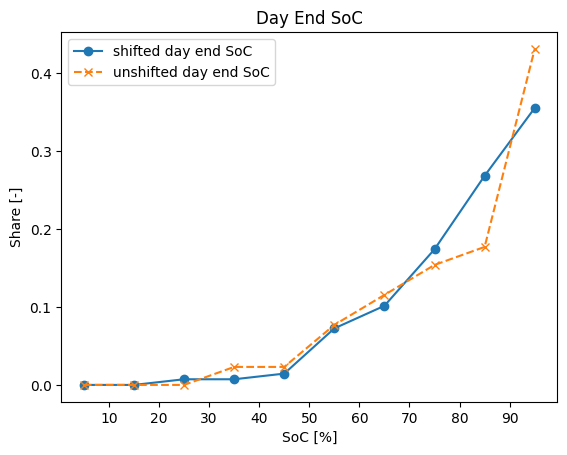

In [14]:
counts, bins = np.histogram(end_SoC, bins=range(0, 110, 10))
counts_unshifted,bins_unshifted = np.histogram(unshifted_end_SoC,bins=range(0,110,10))
bin_centers = 0.5 * (bins[1:] + bins[:-1])
plt.xticks(range(0,110,10))
plt.plot(bin_centers, counts/counts.sum(), linestyle='-', marker='o',label='shifted day end SoC')
plt.plot(bin_centers, counts_unshifted/counts_unshifted.sum(), linestyle='--', marker='x',label='unshifted day end SoC')
plt.xlabel('SoC [%]')
plt.ylabel('Share [-]')
plt.title('Day End SoC')
plt.legend()

Text(0.5, 1.0, 'Scatter Plot of Unshifted End SoC vs End SoC')

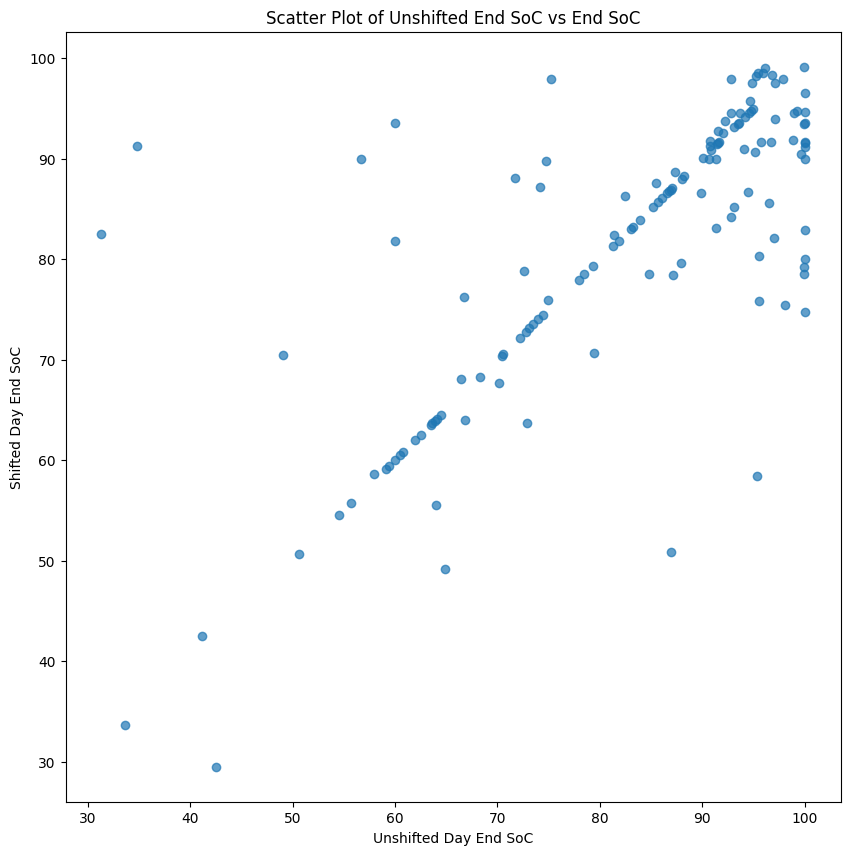

In [15]:
plt.figure(figsize=(10, 10))
plt.scatter(unshifted_end_SoC.values,end_SoC.values, alpha=0.7)
plt.xlabel('Unshifted Day End SoC')
plt.ylabel('Shifted Day End SoC')
plt.title('Scatter Plot of Unshifted End SoC vs End SoC')


In [22]:
def loading_res(net):
    loading_res={}
    loading_res['line_load'] =  psastat.pf_line_loading(net)
    loading_res['line_stat'] =  psastat.pf_line_overloading_stat(net)

    loading_res['trafo_load'] = psastat.pf_trafo_loading(net)
    loading_res['trafo_stat'] = psastat.pf_trafo_overloading_stat(net)

    loading_res['voltage_load'] = net.buses_t.v_mag_pu
    loading_res['voltage_stat'] = psastat.pf_undervoltage(net)
    
    return loading_res


In [17]:
def hourly_visualize(MV_feeder,net, save_paths, loading_res):

        line_load = loading_res['line_load']
        voltage_load = loading_res['voltage_load']
        trafo_load = loading_res['trafo_load']

        for sns in net.snapshots[0:24]:
            fig, ax = plt.subplots(subplot_kw={"projection": ccrs.EqualEarth()}, figsize=(20, 20))
            loads = net.loads.assign(l=net.loads_t.p.loc[sns]).groupby(["bus"]).l.sum()
            gens = net.generators.assign(gen=net.generators_t.p.loc[sns]).groupby(
                ["bus"]).gen.sum()
            ev_net_gen = net.storage_units.assign(ev_net_gen=net.storage_units_t.p.loc[sns]).groupby(["bus"]).ev_net_gen.sum()
            gens = gens.reindex(index=loads.index, fill_value=0)
            ev_net_gen = ev_net_gen.reindex(index=loads.index, fill_value=0)
            net_load = loads - gens-ev_net_gen
            line_loading = np.sqrt(net.lines_t.p0.loc[sns] ** 2 + net.lines_t.q0.loc[
                sns] ** 2) / net.lines.s_nom * 100
            trafo_loading = np.sqrt(
                net.transformers_t.p0.loc[sns] ** 2 + net.transformers_t.q0.loc[
                    sns] ** 2) / net.transformers.s_nom * 100
            collection = net.plot(
                bus_sizes=abs(net_load/5e6),  # proportional to net loading
                bus_colors=net.buses_t.v_mag_pu.loc[sns],  # proportional to v_mag_pu
                bus_cmap=plt.cm.jet_r,
                bus_alpha=1,
                margin=0.05,
                line_widths=1,  # net_controlled.lines_t.p0.max().max(),
                line_colors=line_loading,
                line_cmap=plt.cm.jet,
                transformer_colors=trafo_loading,  # 'Black',
                transformer_widths=10,  # net_controlled.transformers_t.p0.loc[sns],
                transformer_alpha=0.5,
                transformer_cmap=plt.cm.jet,
                projection=ccrs.EqualEarth(),
                color_geomap=True,
                title= str(sns) if MV_feeder else str(sns) + "  " + f"{folder}",
                jitter=5
            )

            bussm = plt.cm.ScalarMappable(cmap=plt.cm.jet_r, norm=mcolors.Normalize(vmin=voltage_load.loc[sns].min(),
                                                                                    vmax=voltage_load.loc[sns].max()))
            bussm.set_array([])
            linesm = plt.cm.ScalarMappable(cmap=plt.cm.jet, norm=mcolors.Normalize(vmin=line_load.loc[sns].min(),
                                                                                   vmax=line_load.loc[sns].max()))
            linesm.set_array([])

            cax = fig.add_axes([ax.get_position().x1-0.01, ax.get_position().y0, 0.01, ax.get_position().height])
            cax2 = fig.add_axes([ax.get_position().x1+0.03, ax.get_position().y0, 0.01, ax.get_position().height])
            plt.colorbar(linesm, cax=cax, label="Line Loading [%]")
            plt.colorbar(bussm, cax=cax2, label="Bus v_mag_pu [-]")

            if MV_feeder:
                trafosm = plt.cm.ScalarMappable(cmap=plt.cm.jet,norm=mcolors.Normalize(vmin=trafo_load.loc[sns].min(), vmax=trafo_load.loc[sns].max()))
                trafosm.set_array([])
                cax3 = fig.add_axes([ax.get_position().x1+0.07, ax.get_position().y0,0.01,ax.get_position().height])
                plt.colorbar(trafosm,cax=cax3,label="Trafo Loading [%]")

            plt.subplots_adjust(right=0.9)
            plt.show()
            # plt.savefig((f"{save_paths[i]}/hourly_visualize_{sns}.png"))

/usr/local/Caskroom/miniforge/base/envs/vtog/lib/python3.10/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning:

facecolor will have no effect as it has been defined as "never".



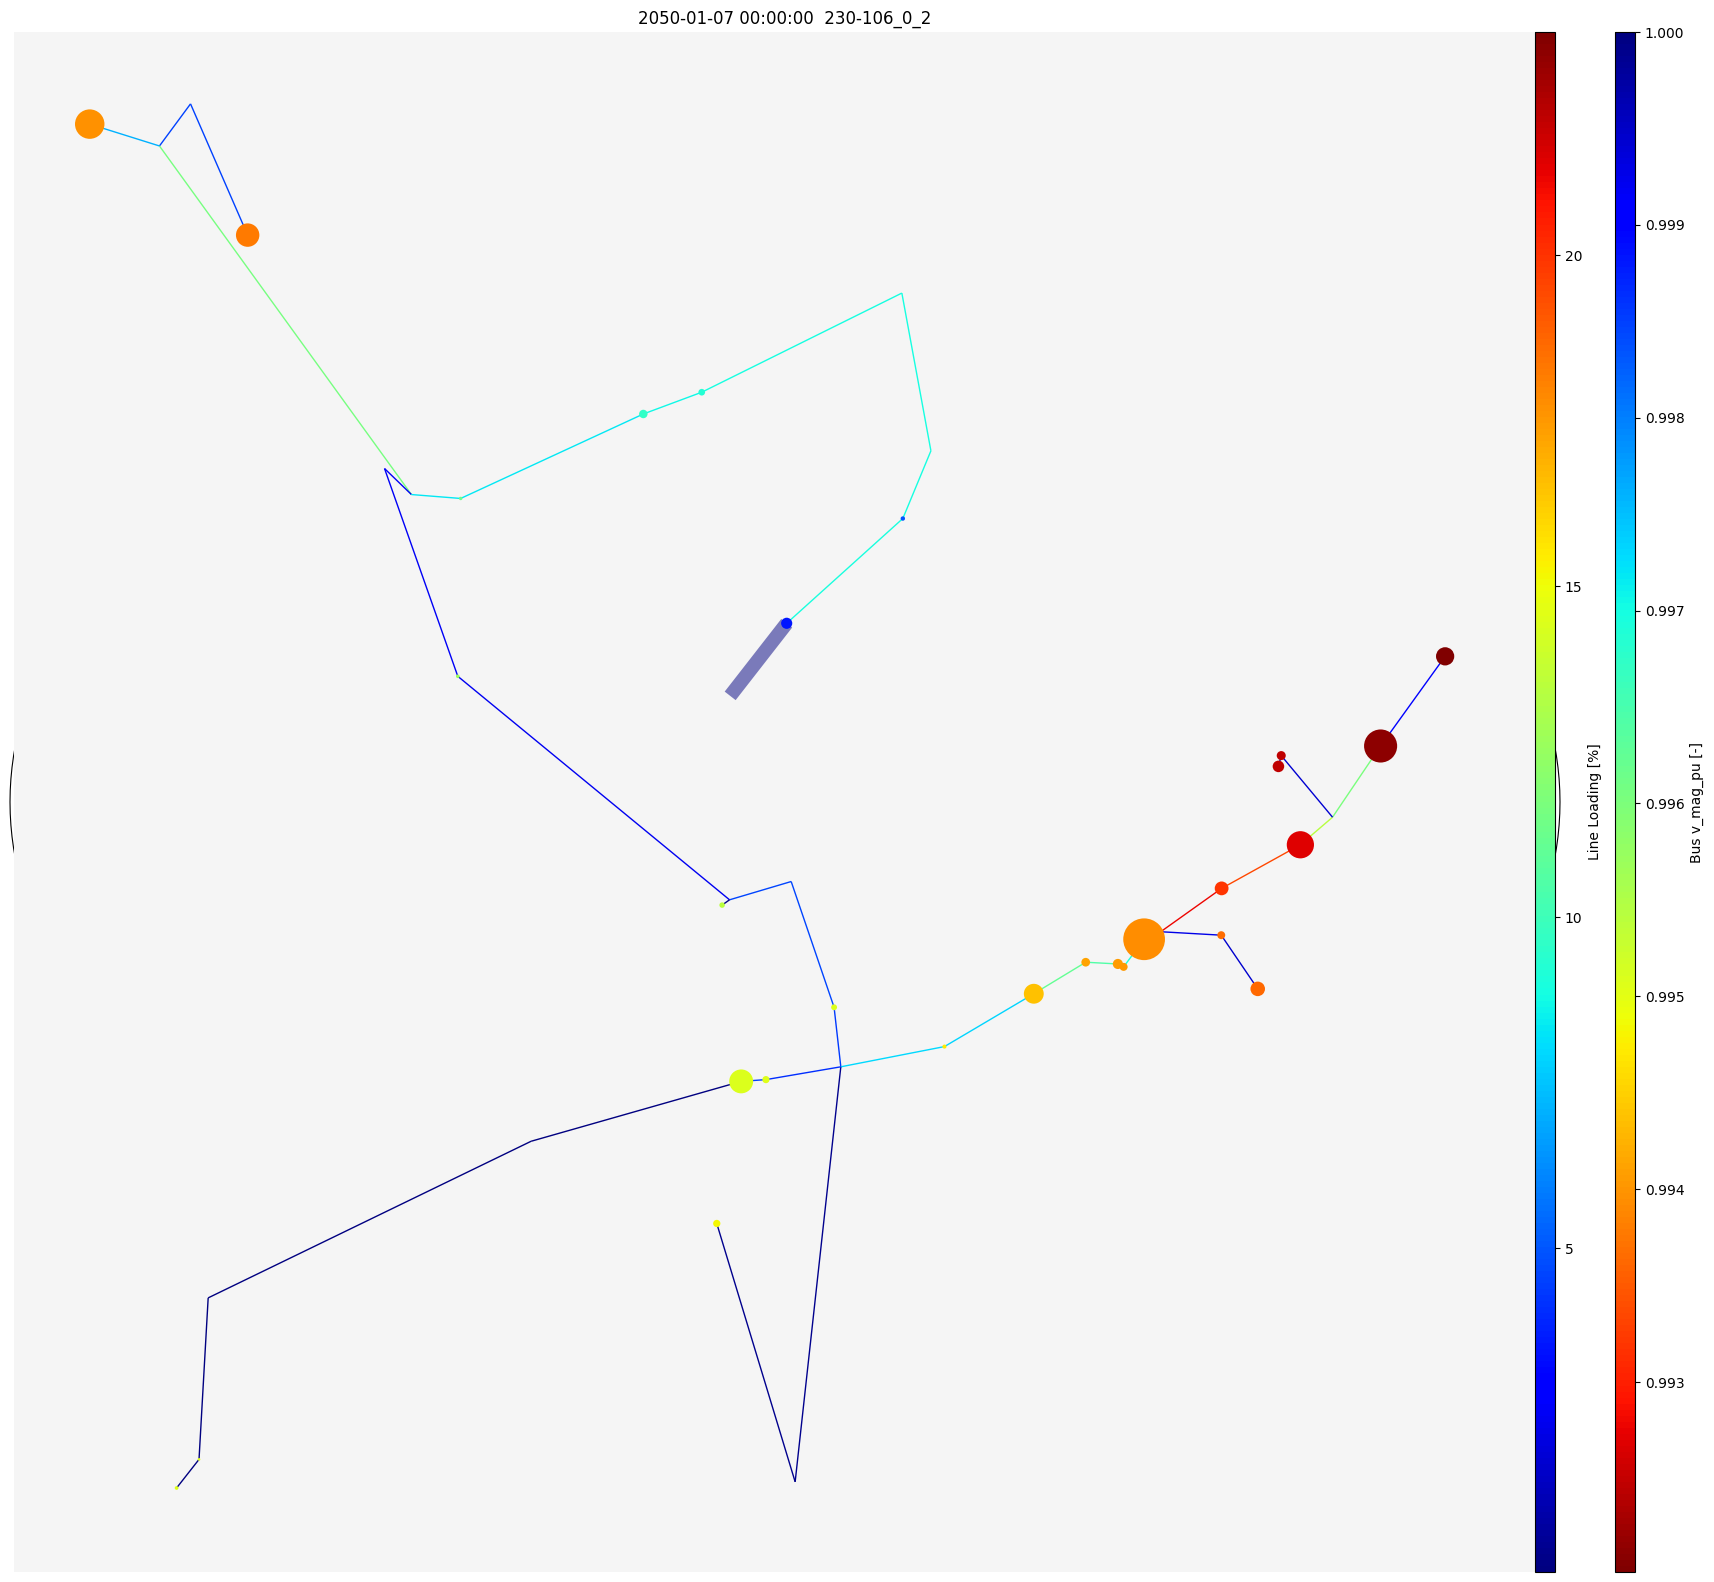

/usr/local/Caskroom/miniforge/base/envs/vtog/lib/python3.10/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning:

facecolor will have no effect as it has been defined as "never".



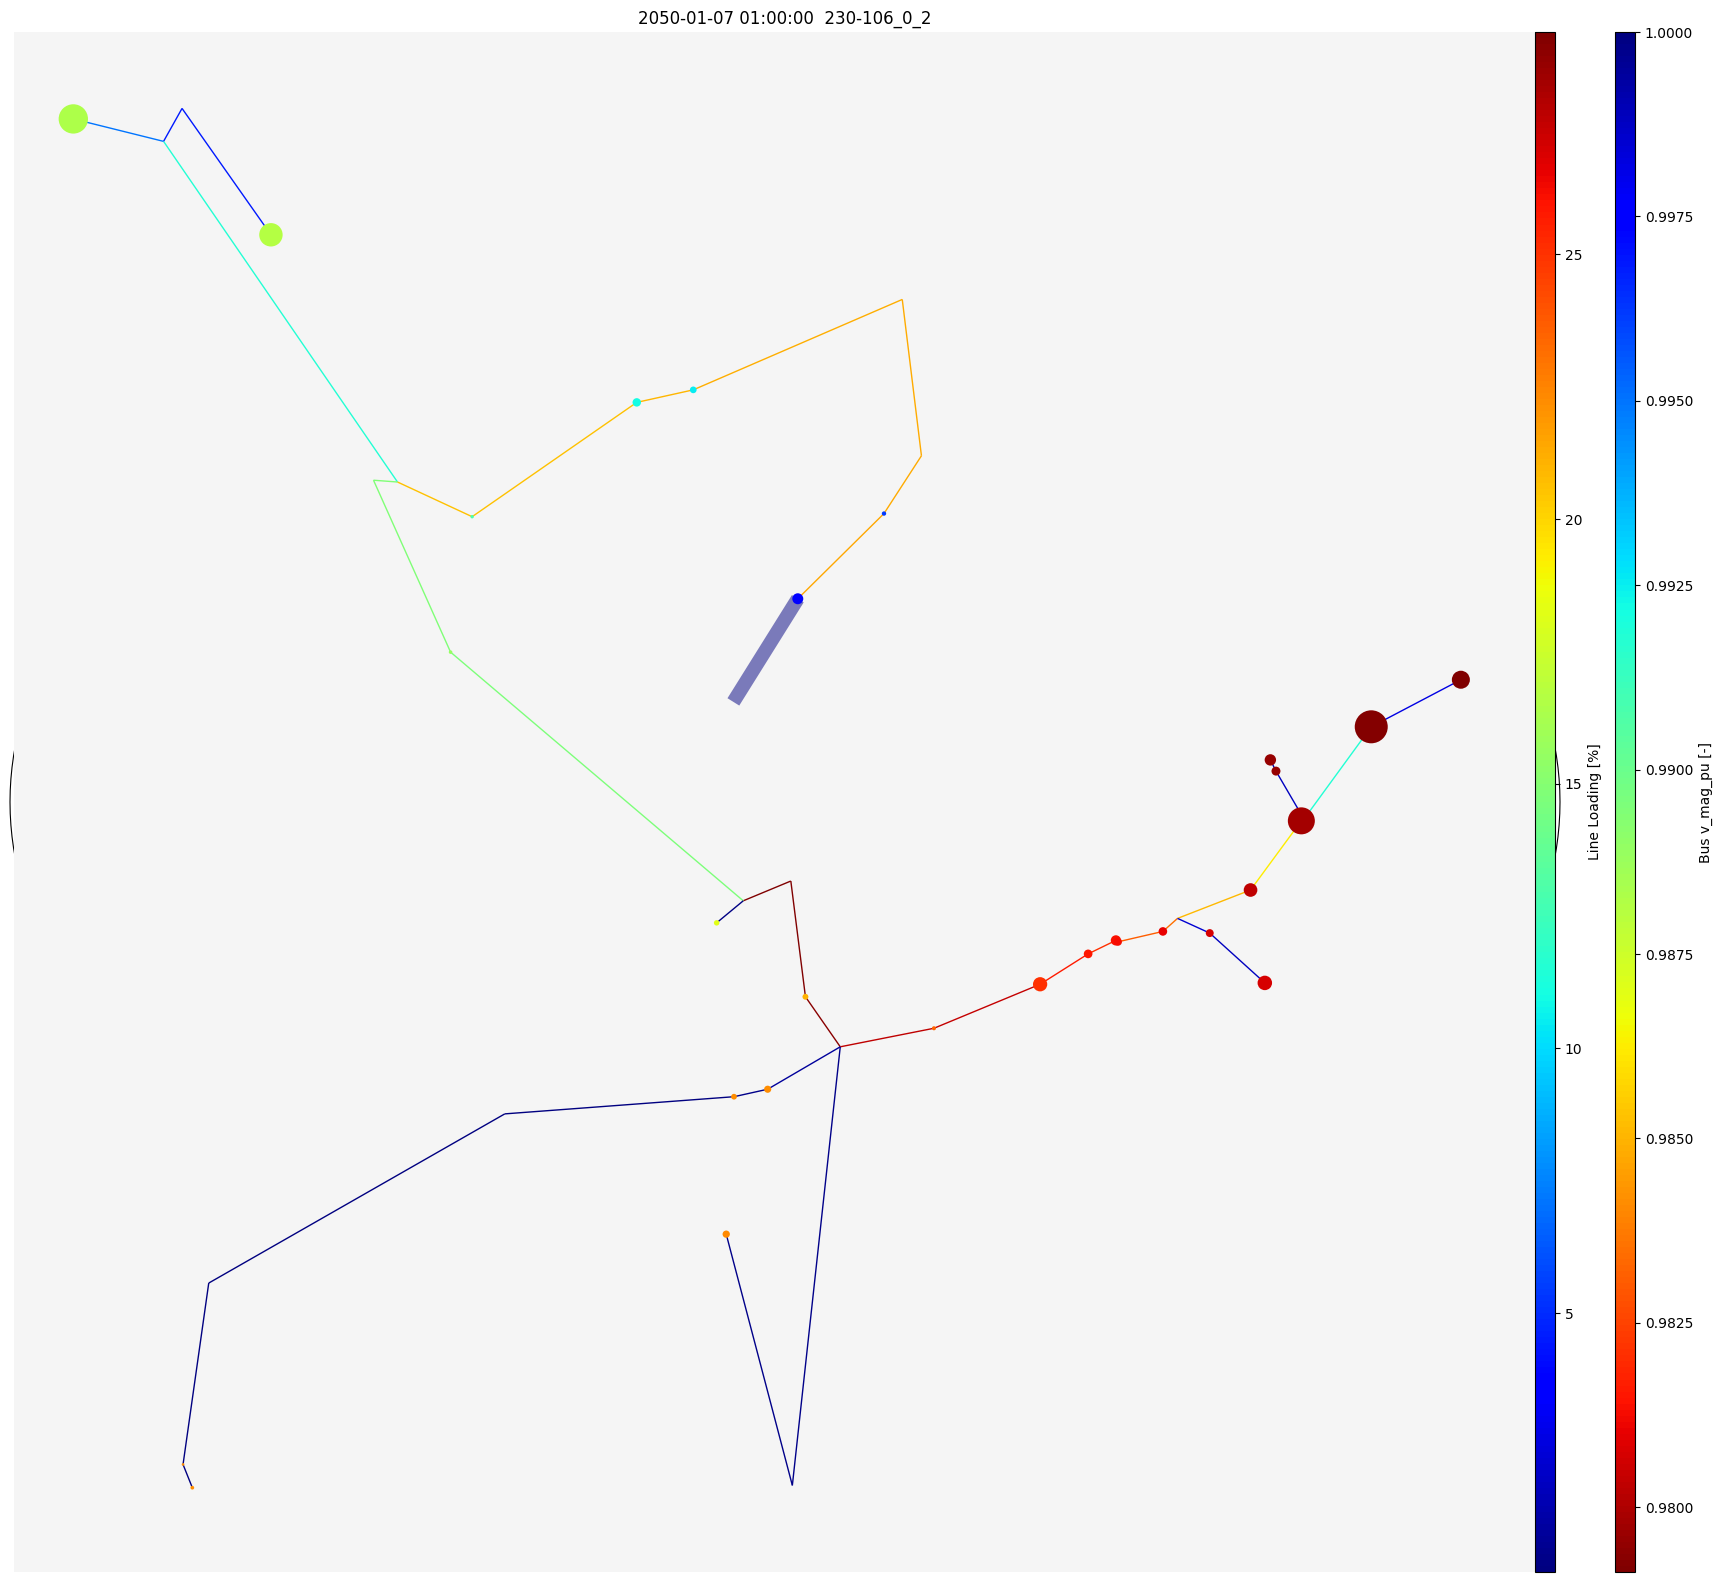

/usr/local/Caskroom/miniforge/base/envs/vtog/lib/python3.10/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning:

facecolor will have no effect as it has been defined as "never".



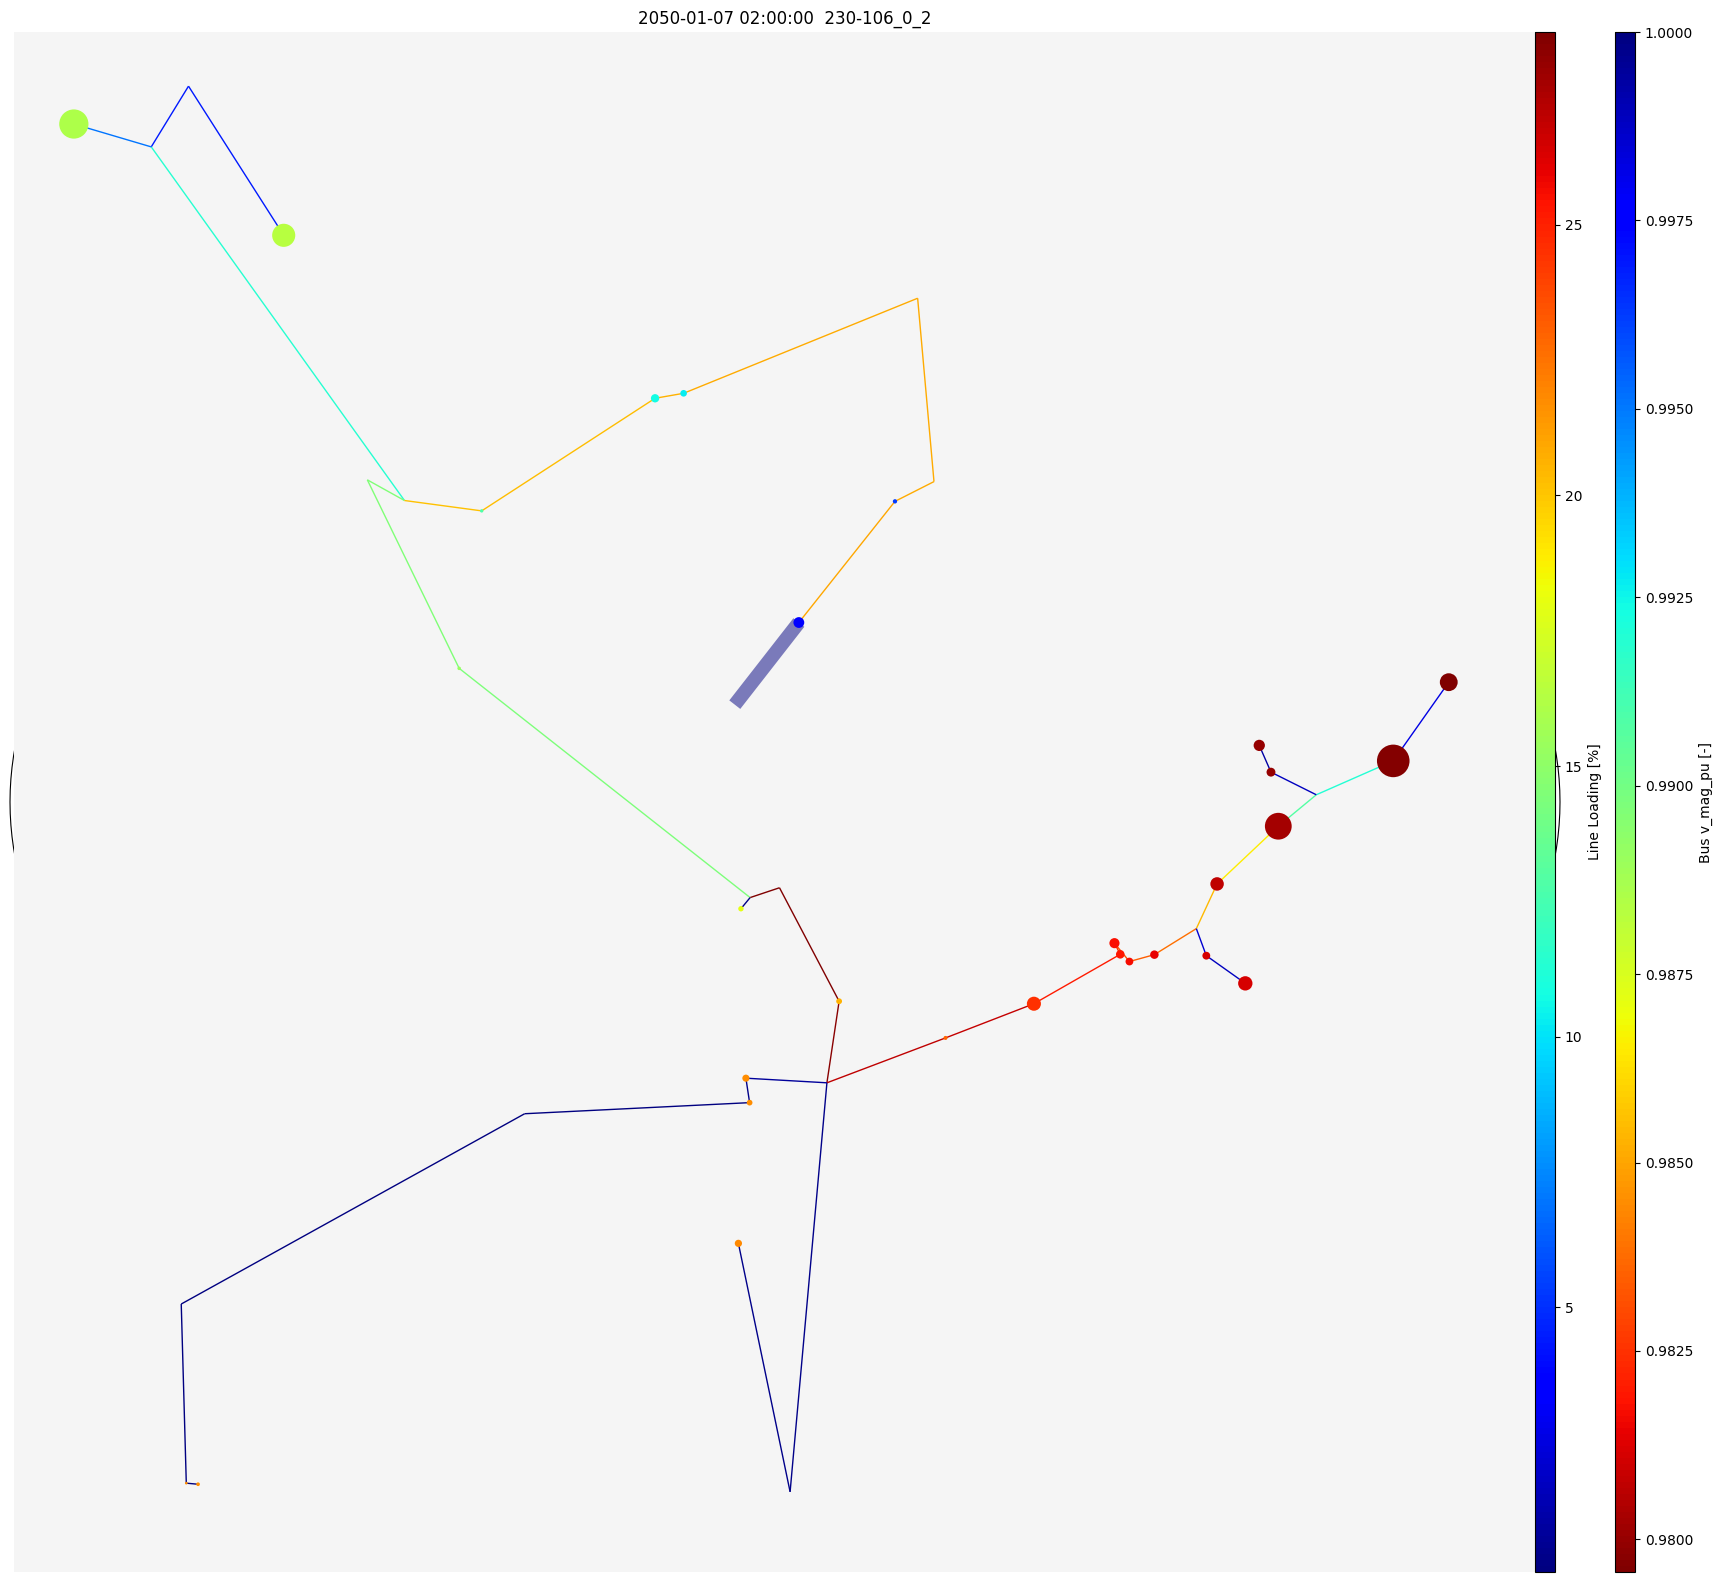

/usr/local/Caskroom/miniforge/base/envs/vtog/lib/python3.10/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning:

facecolor will have no effect as it has been defined as "never".



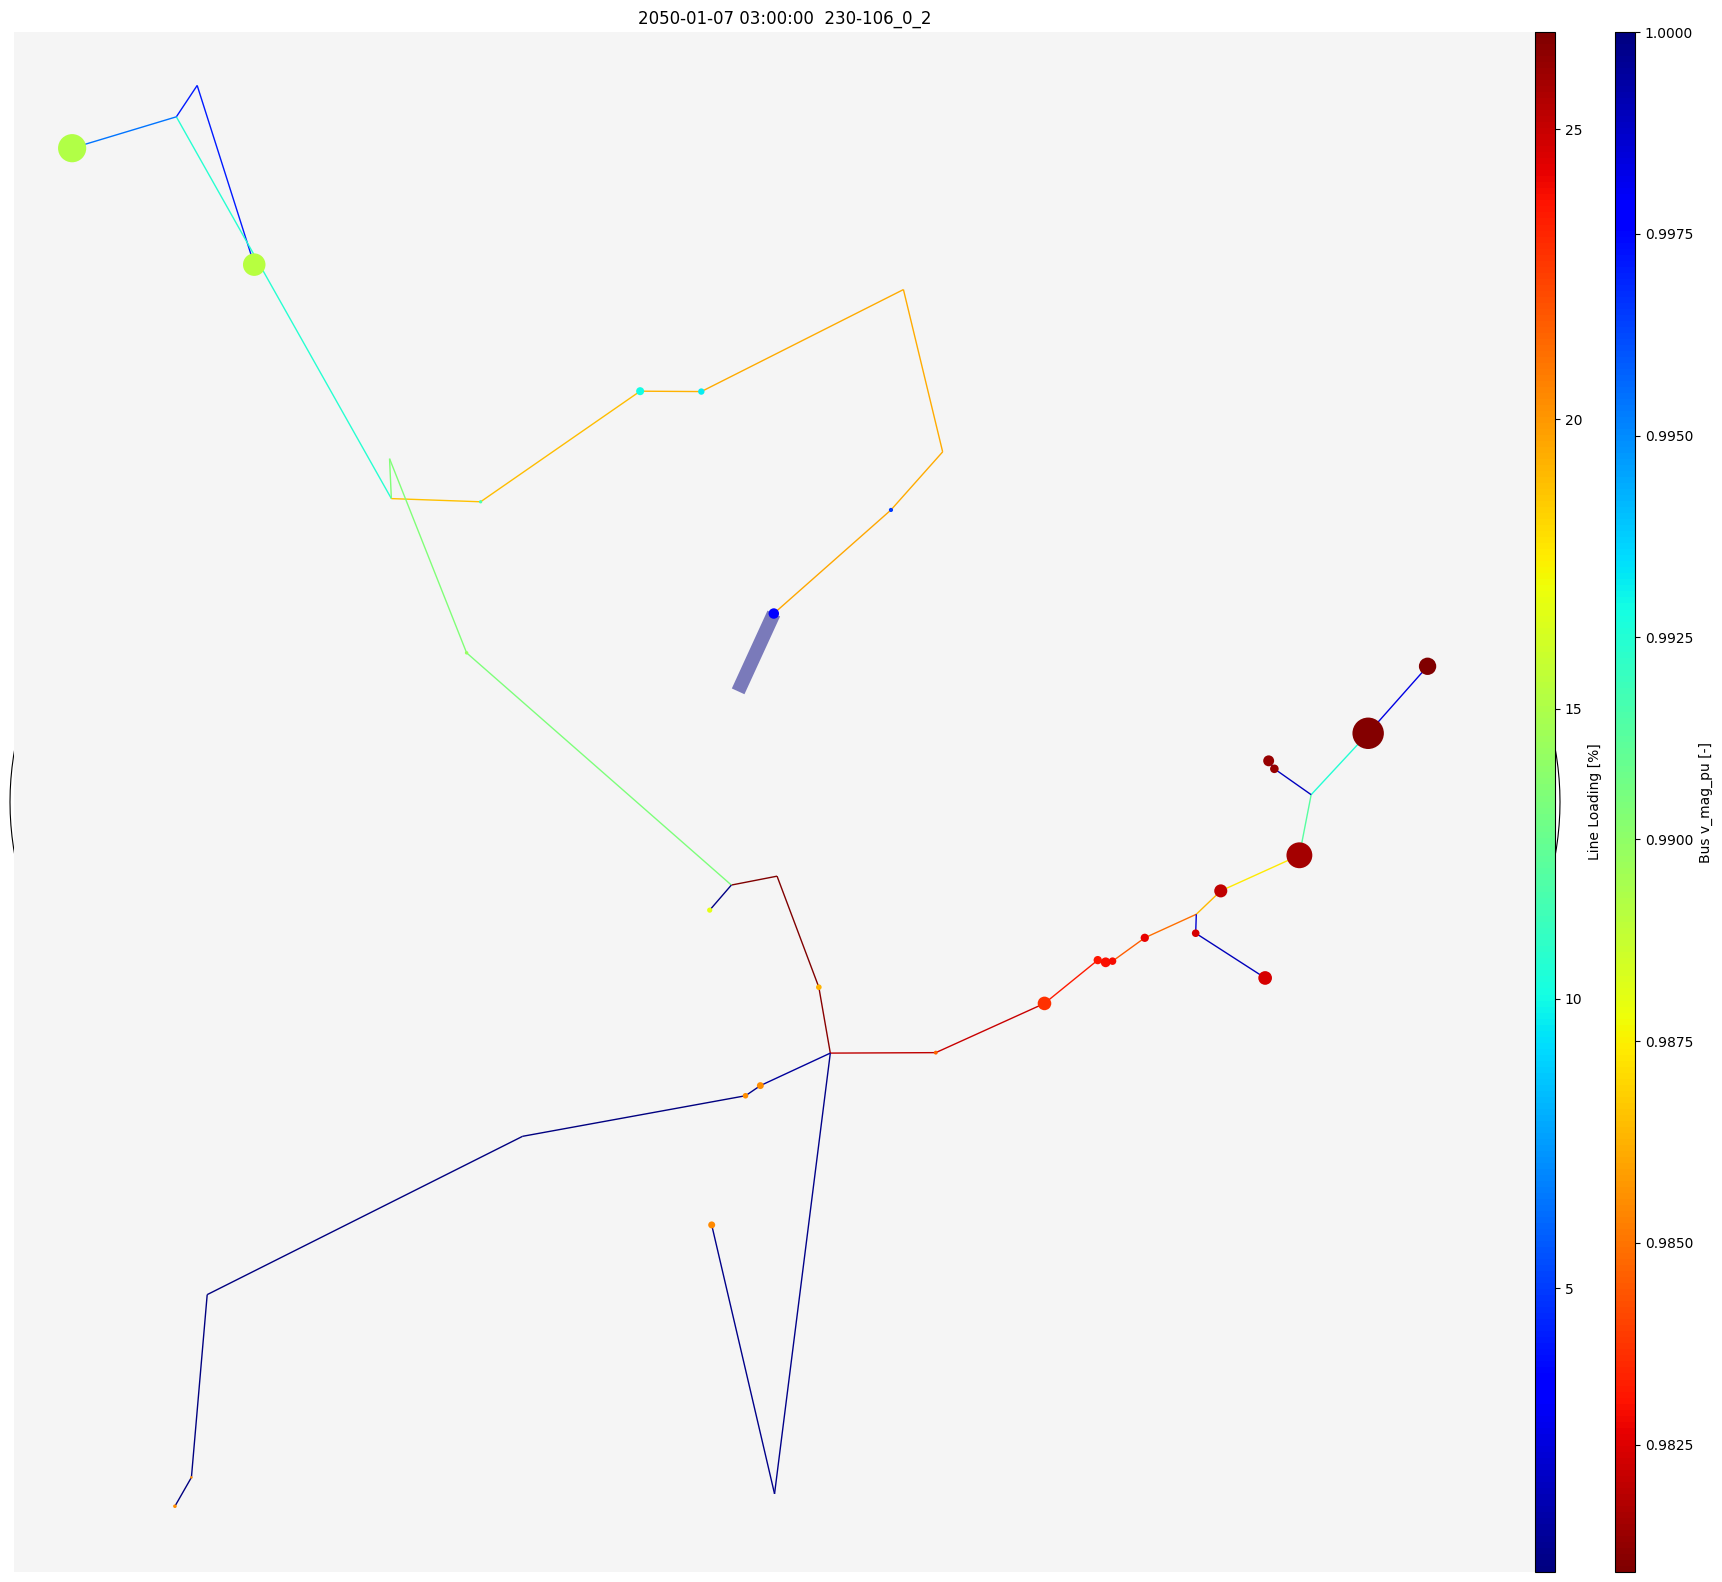

/usr/local/Caskroom/miniforge/base/envs/vtog/lib/python3.10/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning:

facecolor will have no effect as it has been defined as "never".



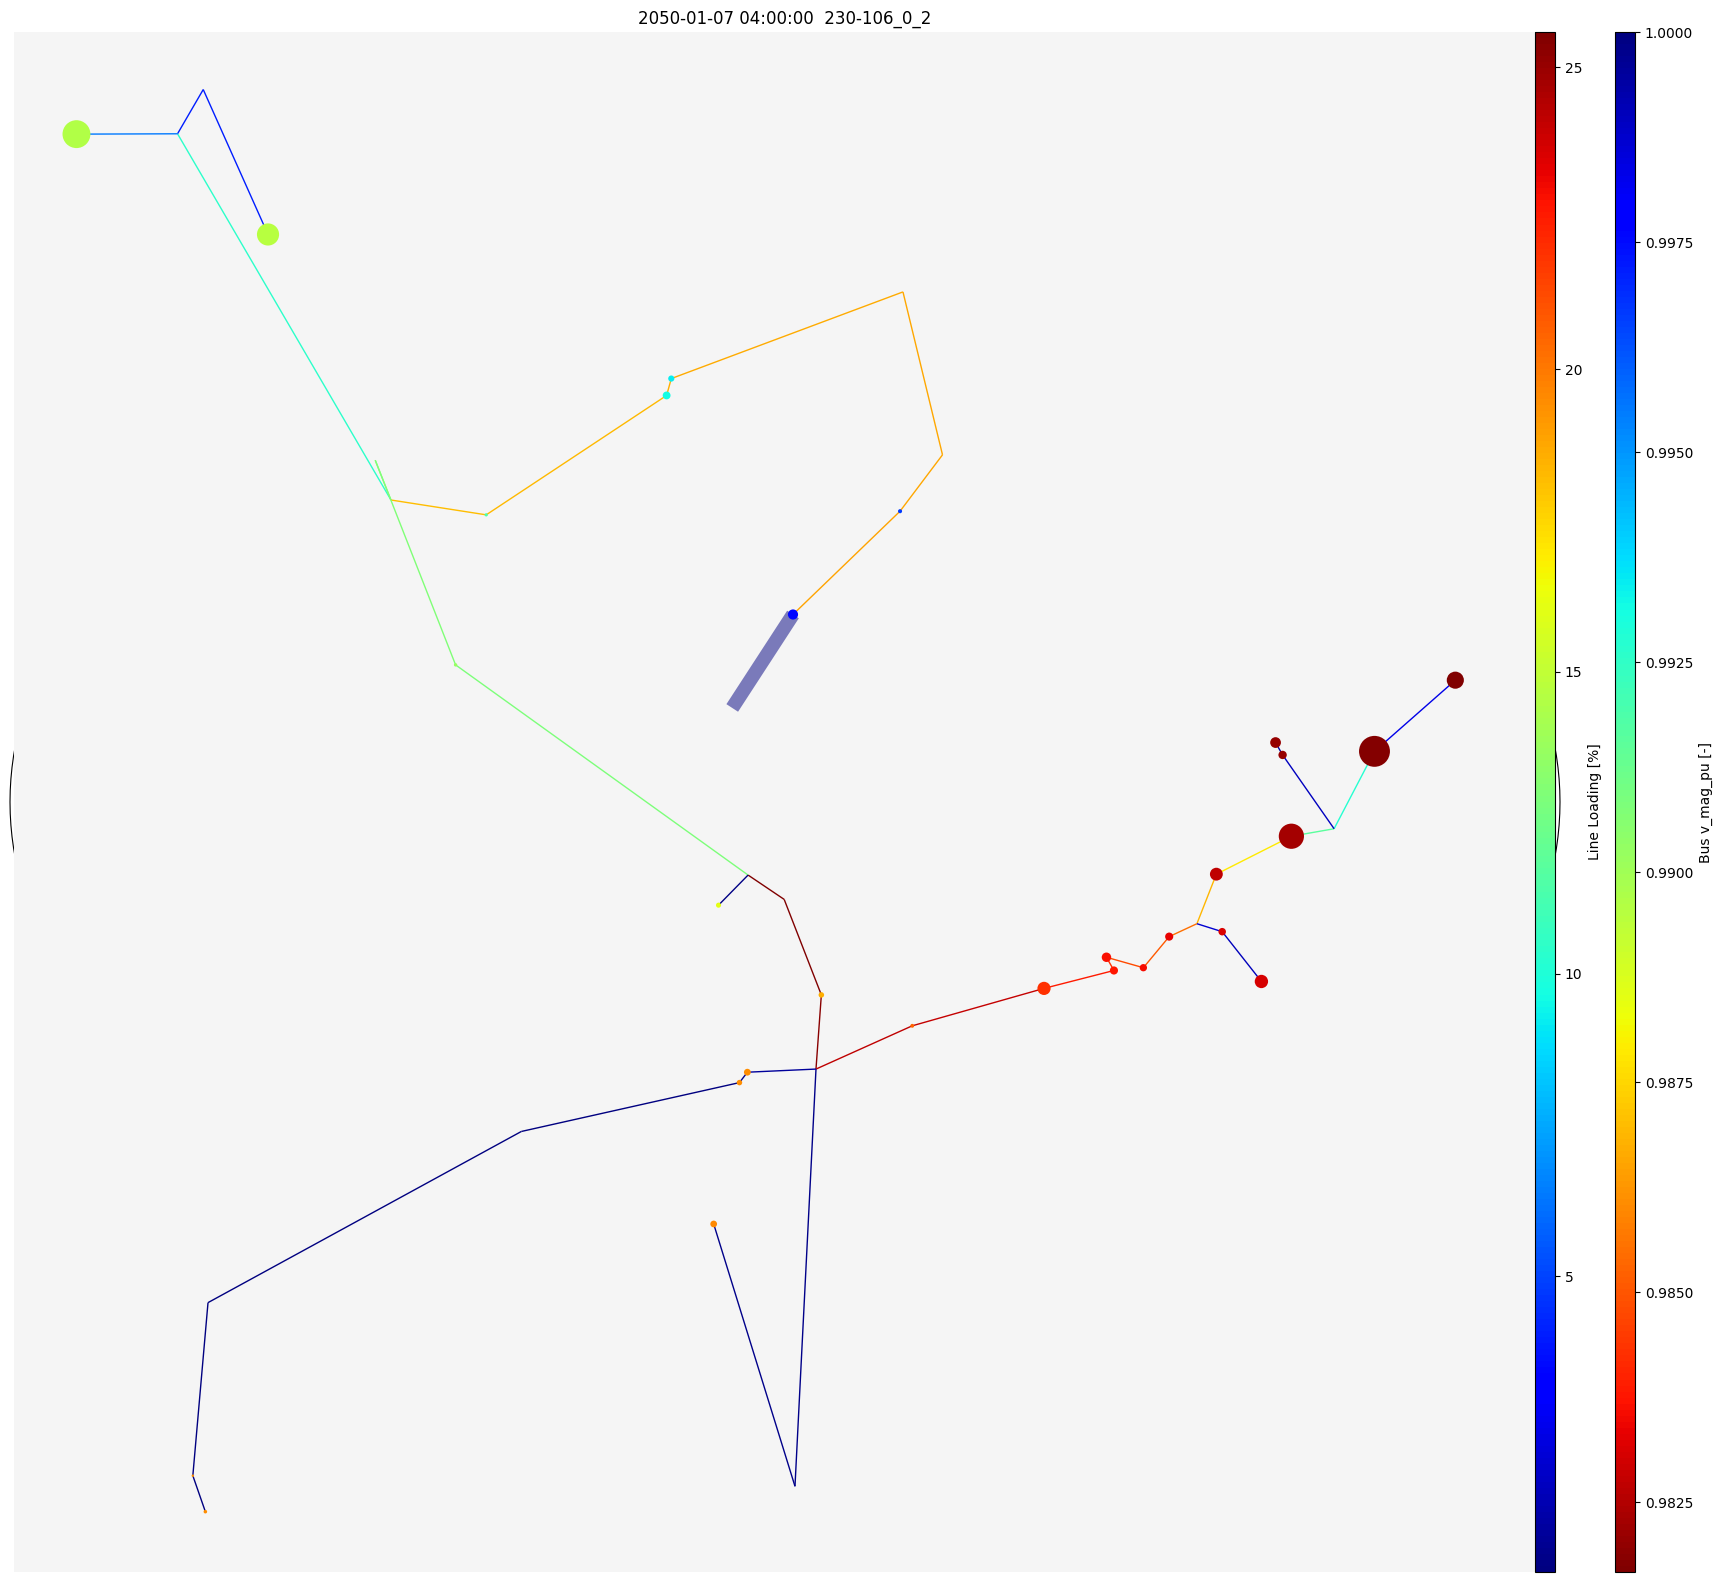

/usr/local/Caskroom/miniforge/base/envs/vtog/lib/python3.10/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning:

facecolor will have no effect as it has been defined as "never".



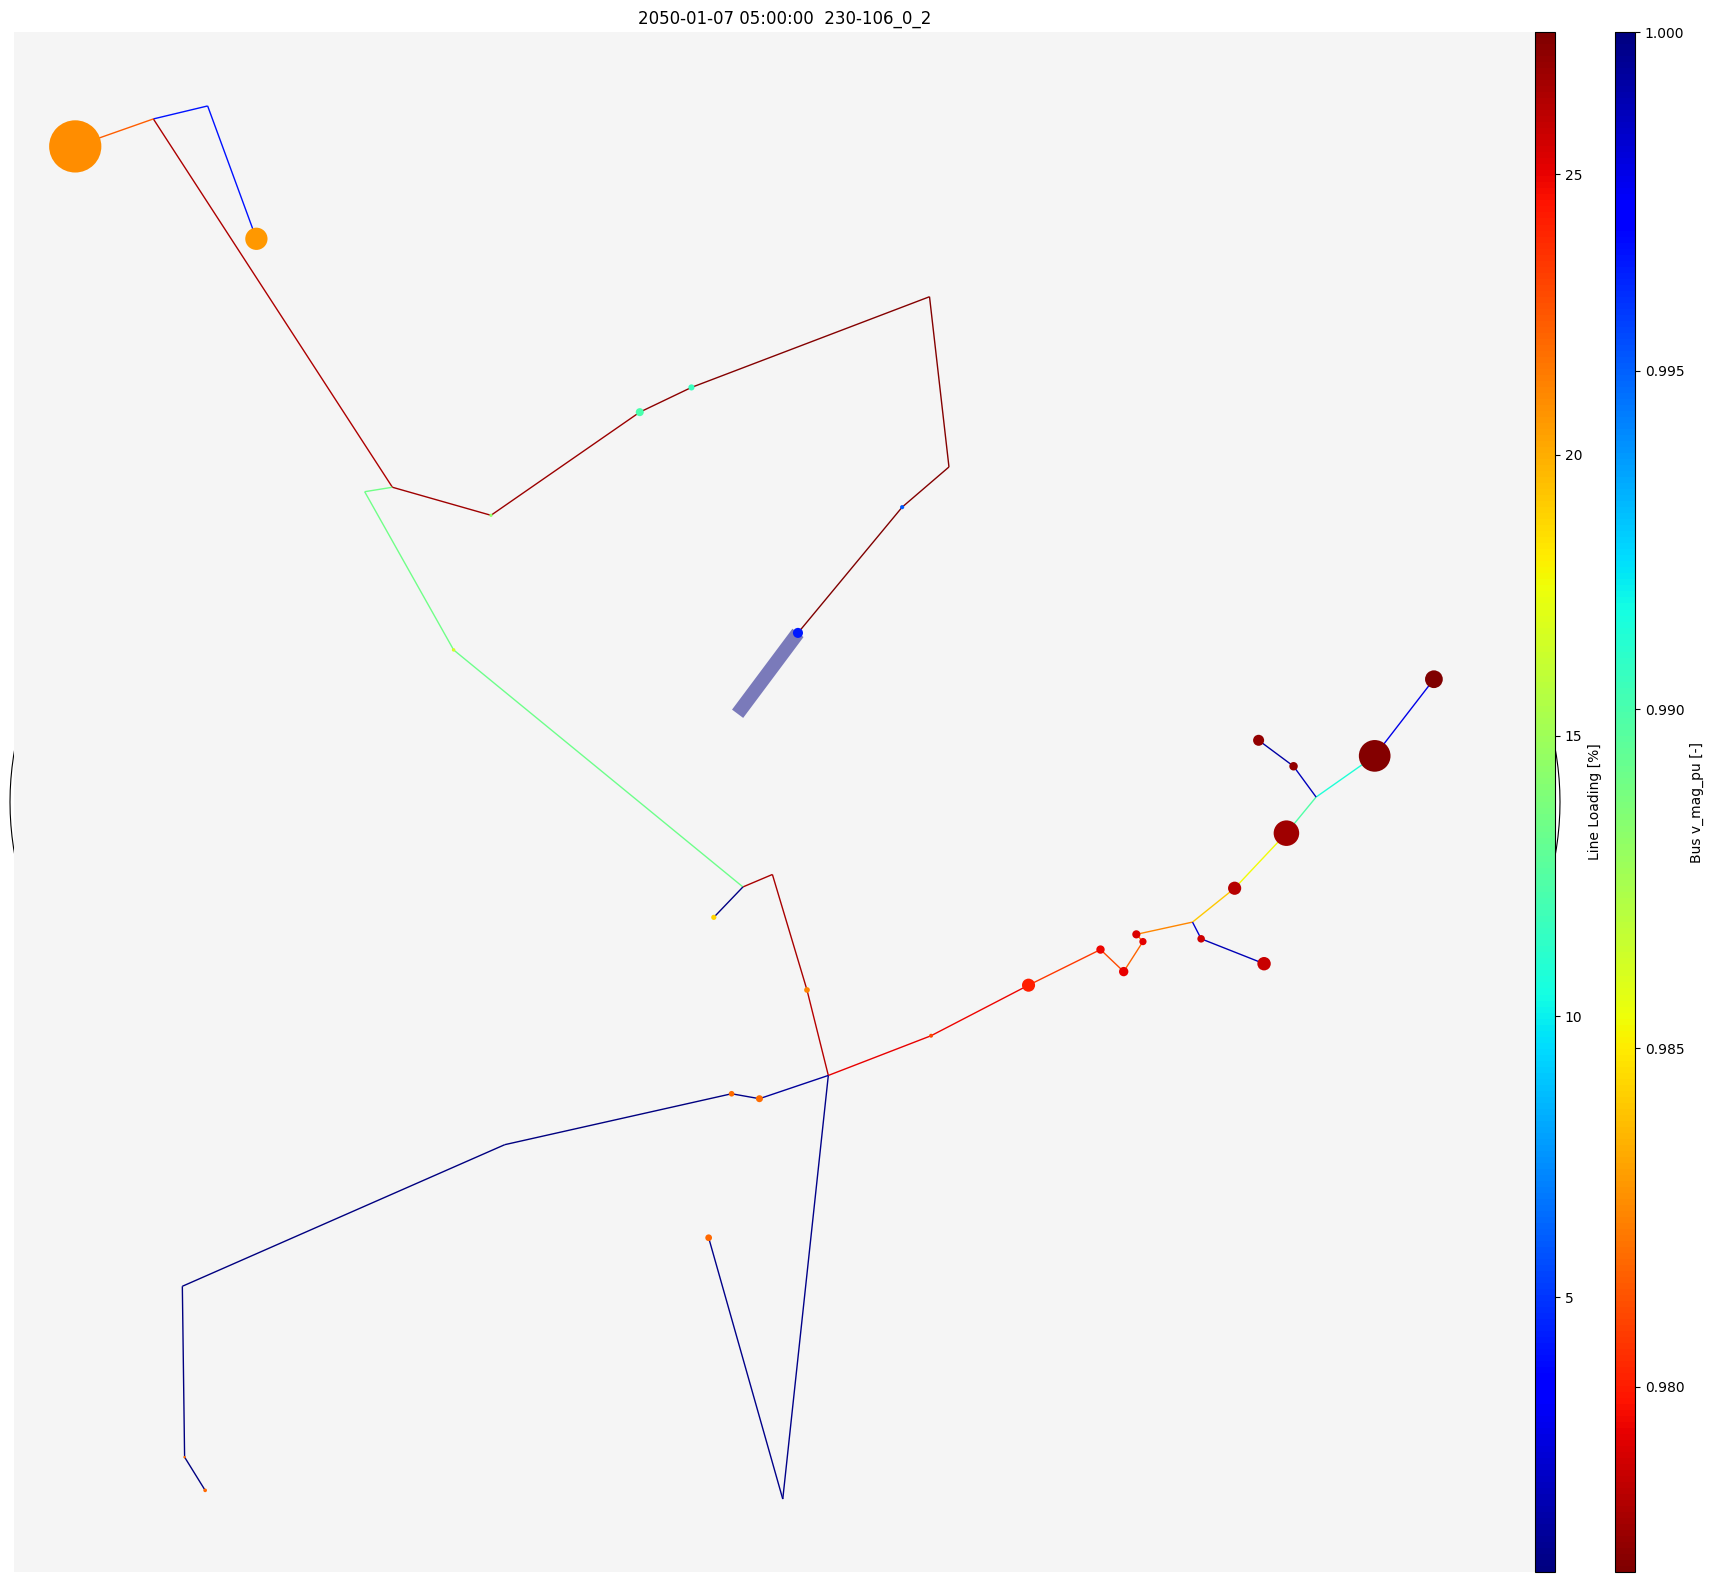

/usr/local/Caskroom/miniforge/base/envs/vtog/lib/python3.10/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning:

facecolor will have no effect as it has been defined as "never".



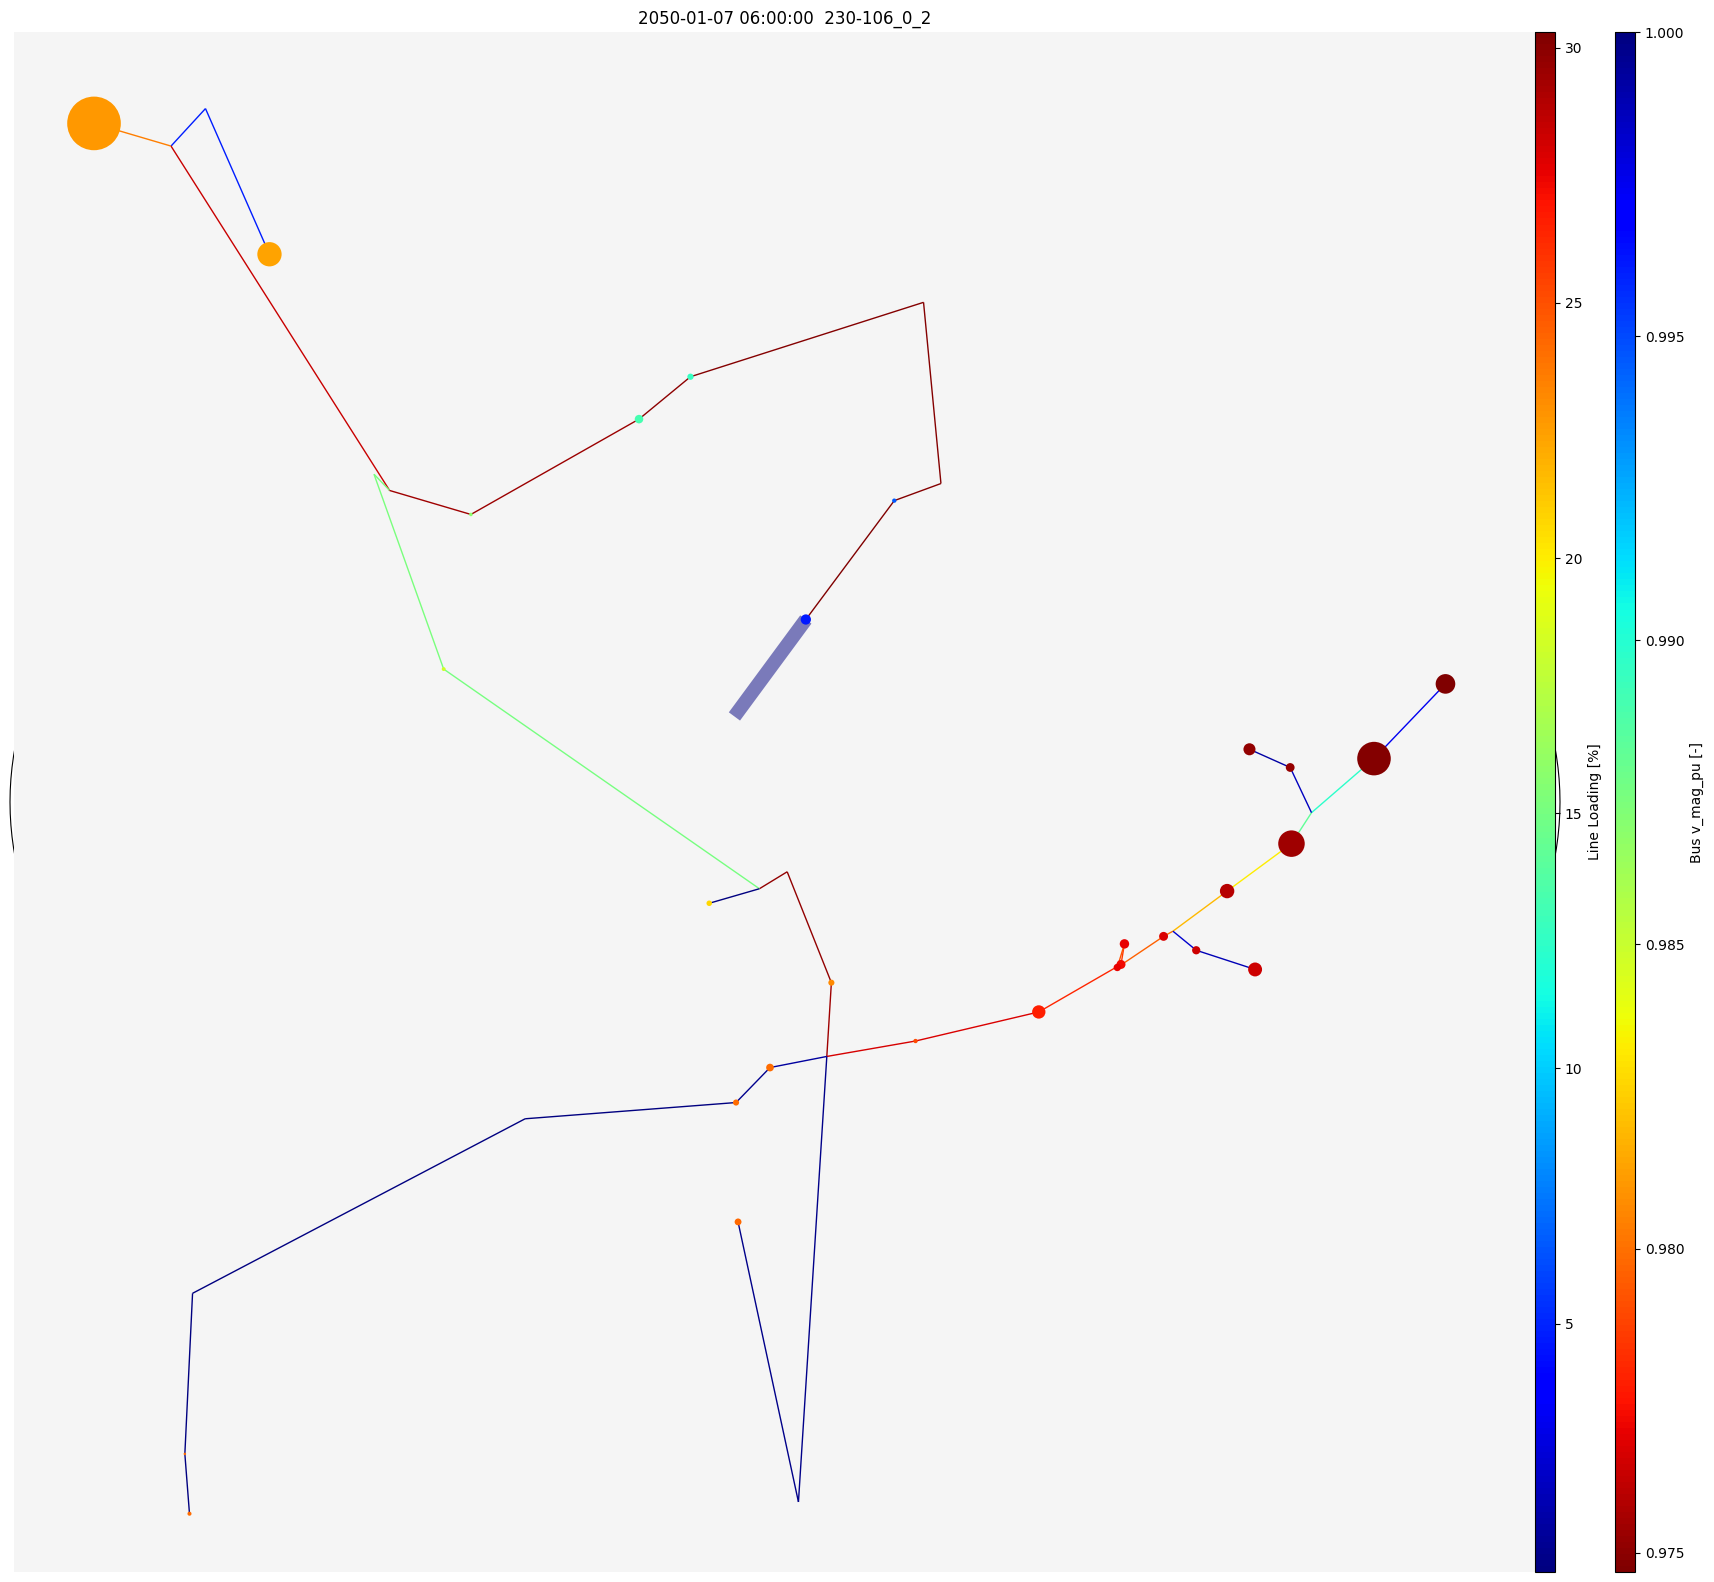

/usr/local/Caskroom/miniforge/base/envs/vtog/lib/python3.10/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning:

facecolor will have no effect as it has been defined as "never".



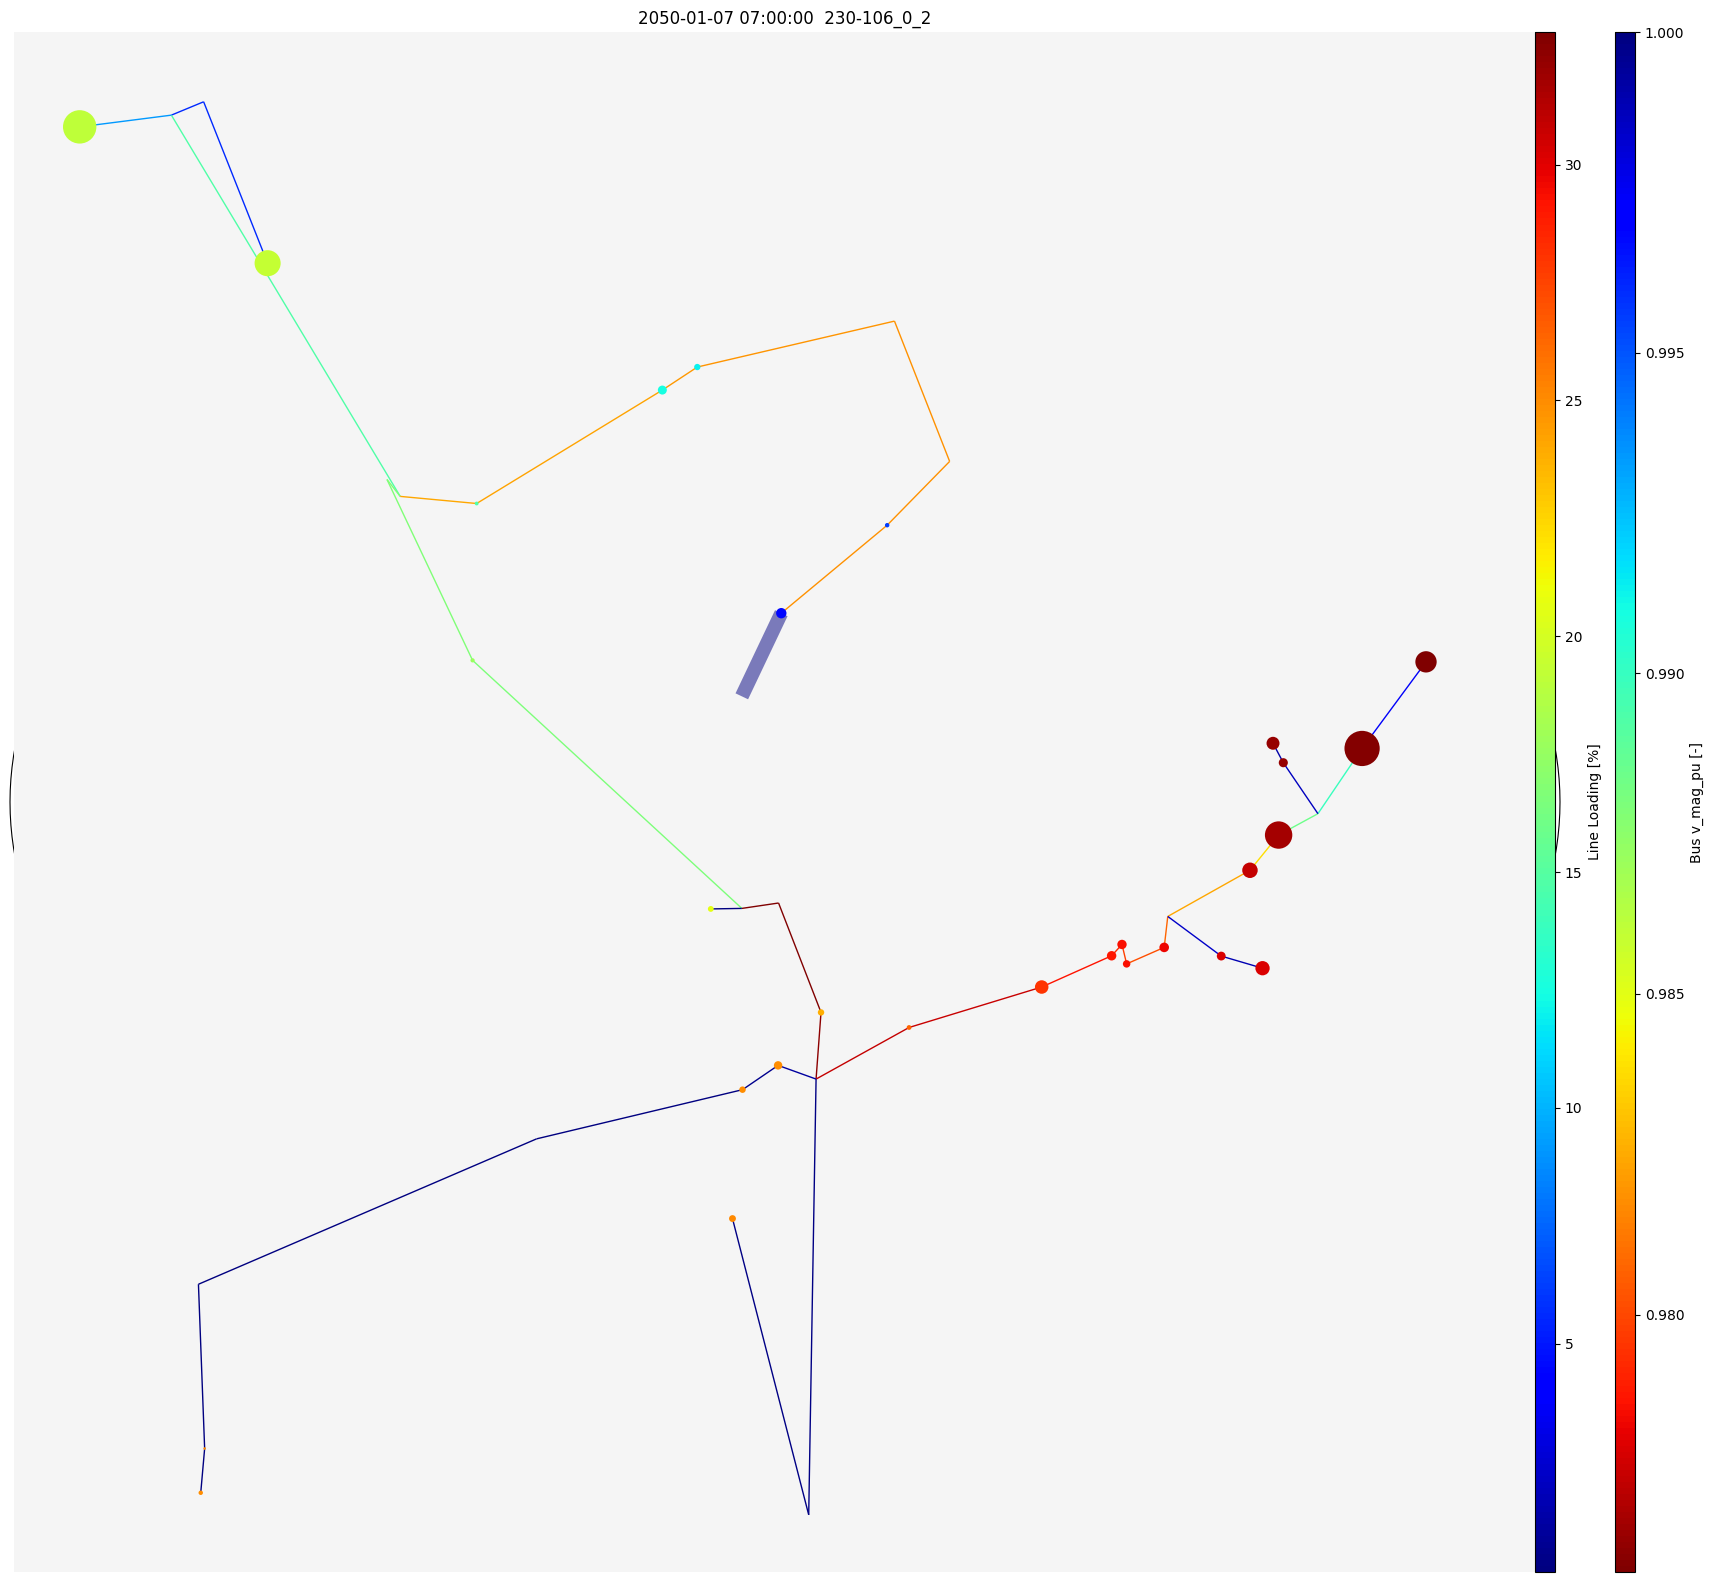

/usr/local/Caskroom/miniforge/base/envs/vtog/lib/python3.10/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning:

facecolor will have no effect as it has been defined as "never".



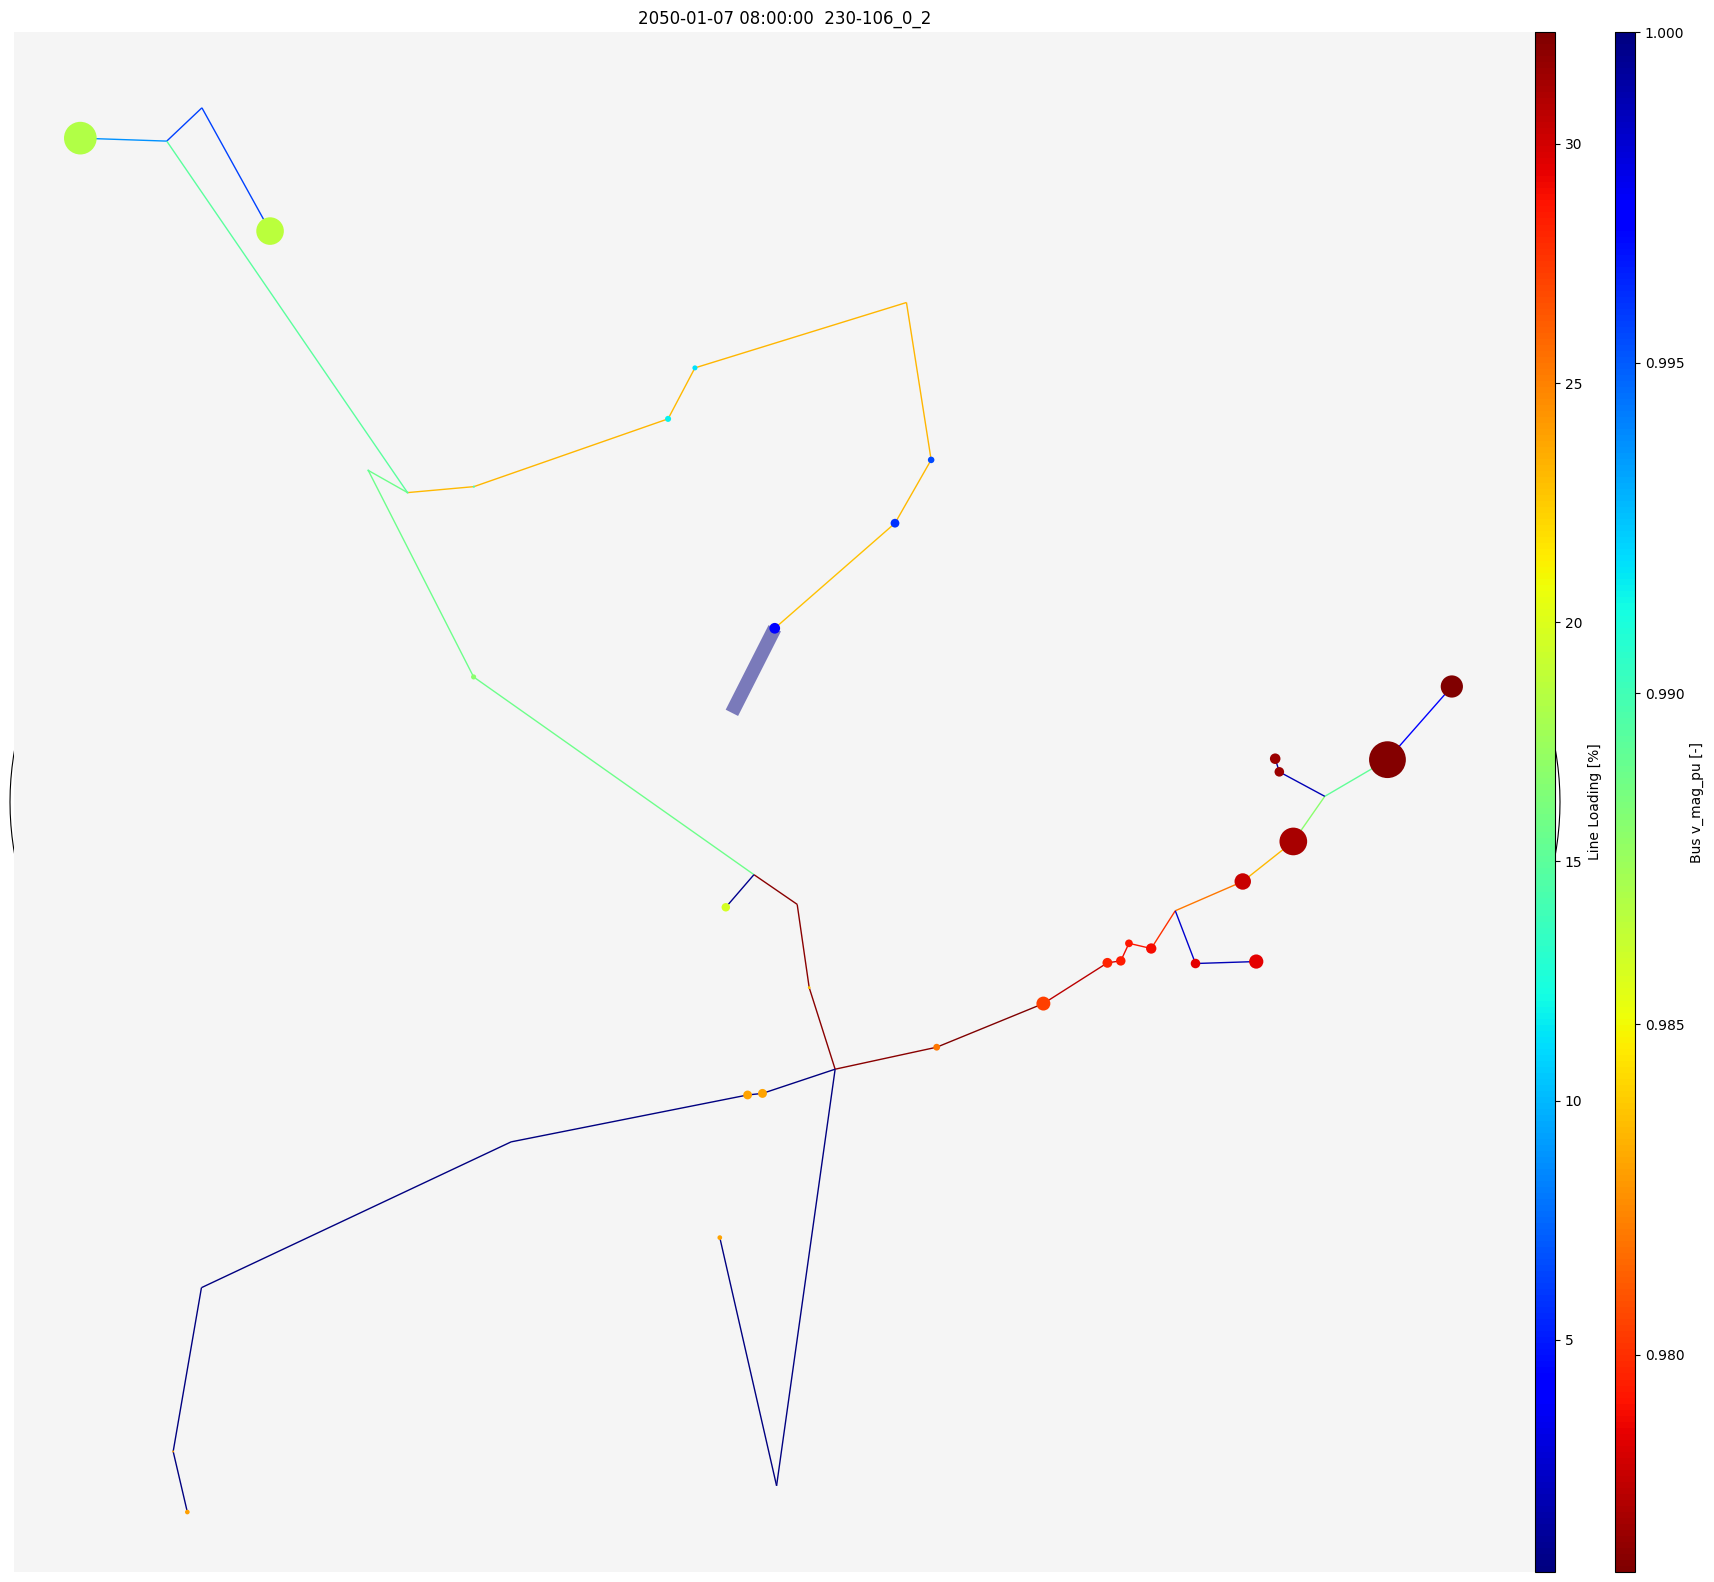

/usr/local/Caskroom/miniforge/base/envs/vtog/lib/python3.10/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning:

facecolor will have no effect as it has been defined as "never".



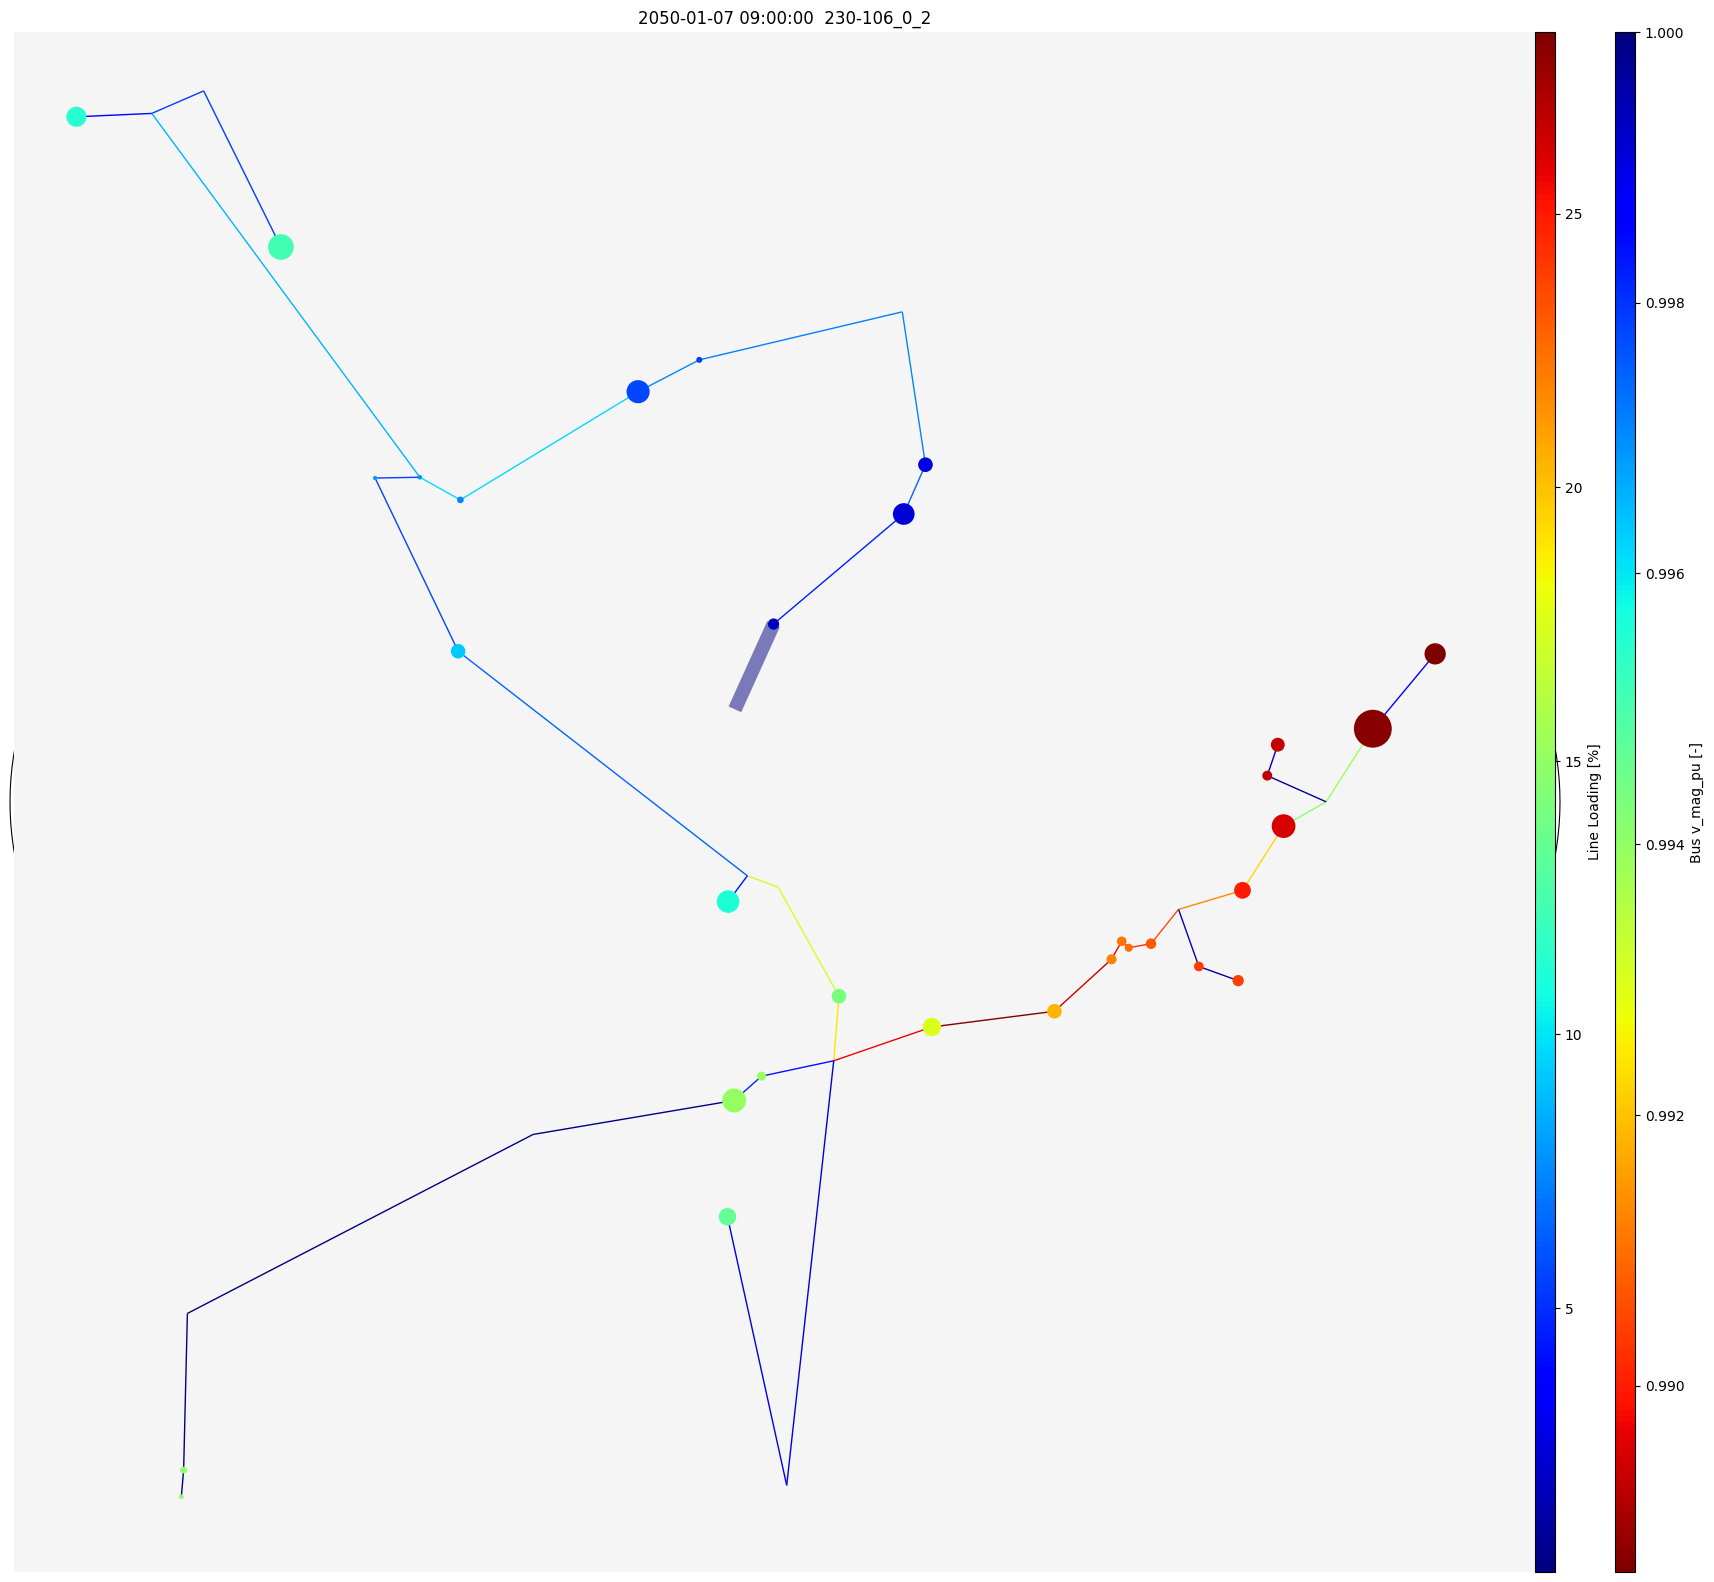

/usr/local/Caskroom/miniforge/base/envs/vtog/lib/python3.10/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning:

facecolor will have no effect as it has been defined as "never".



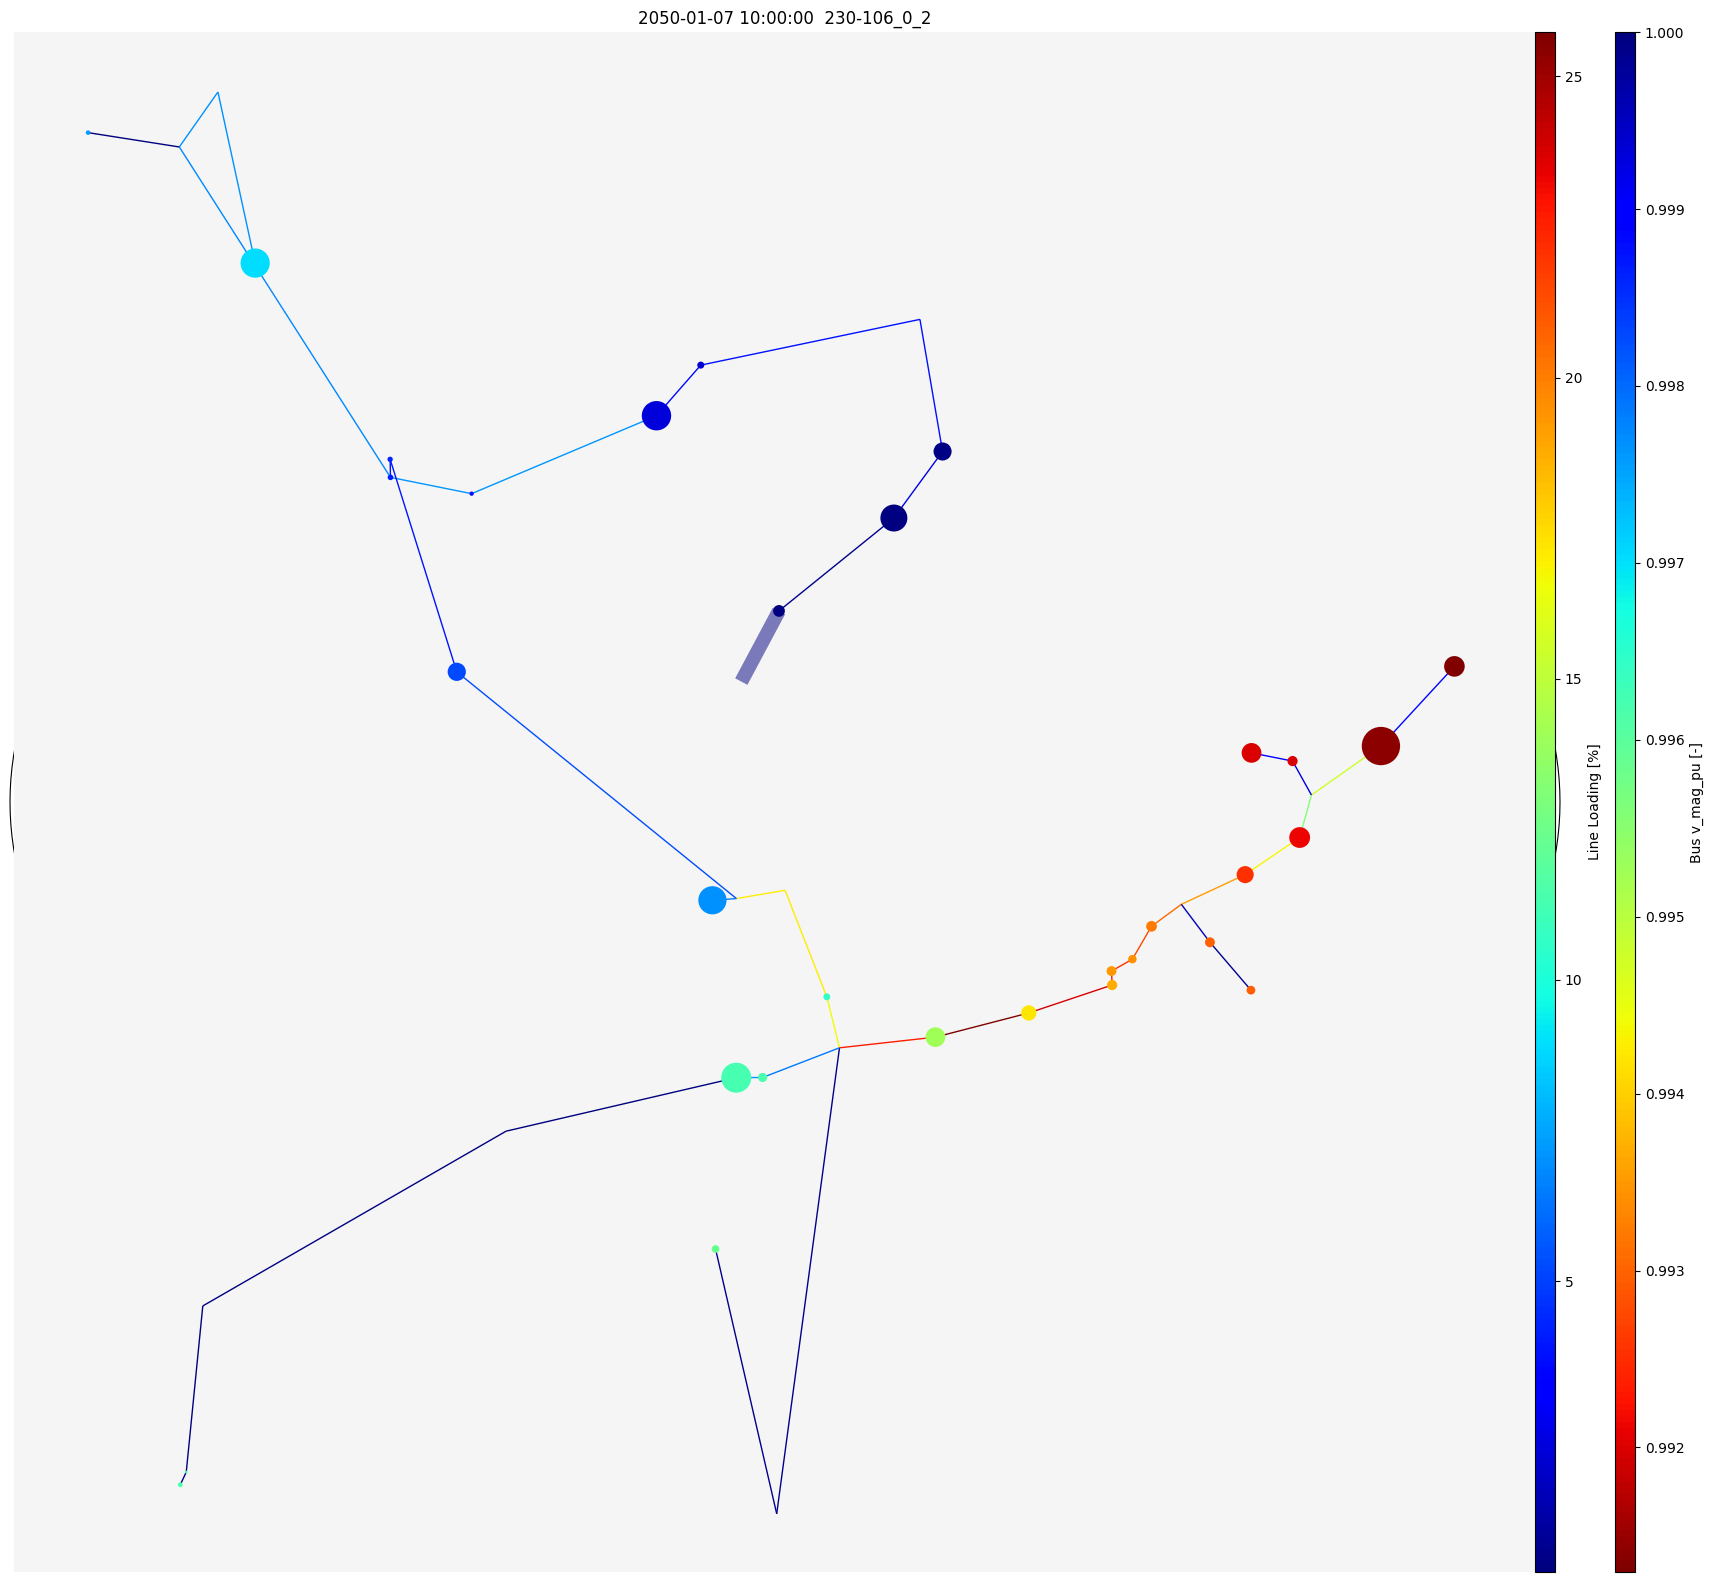

/usr/local/Caskroom/miniforge/base/envs/vtog/lib/python3.10/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning:

facecolor will have no effect as it has been defined as "never".



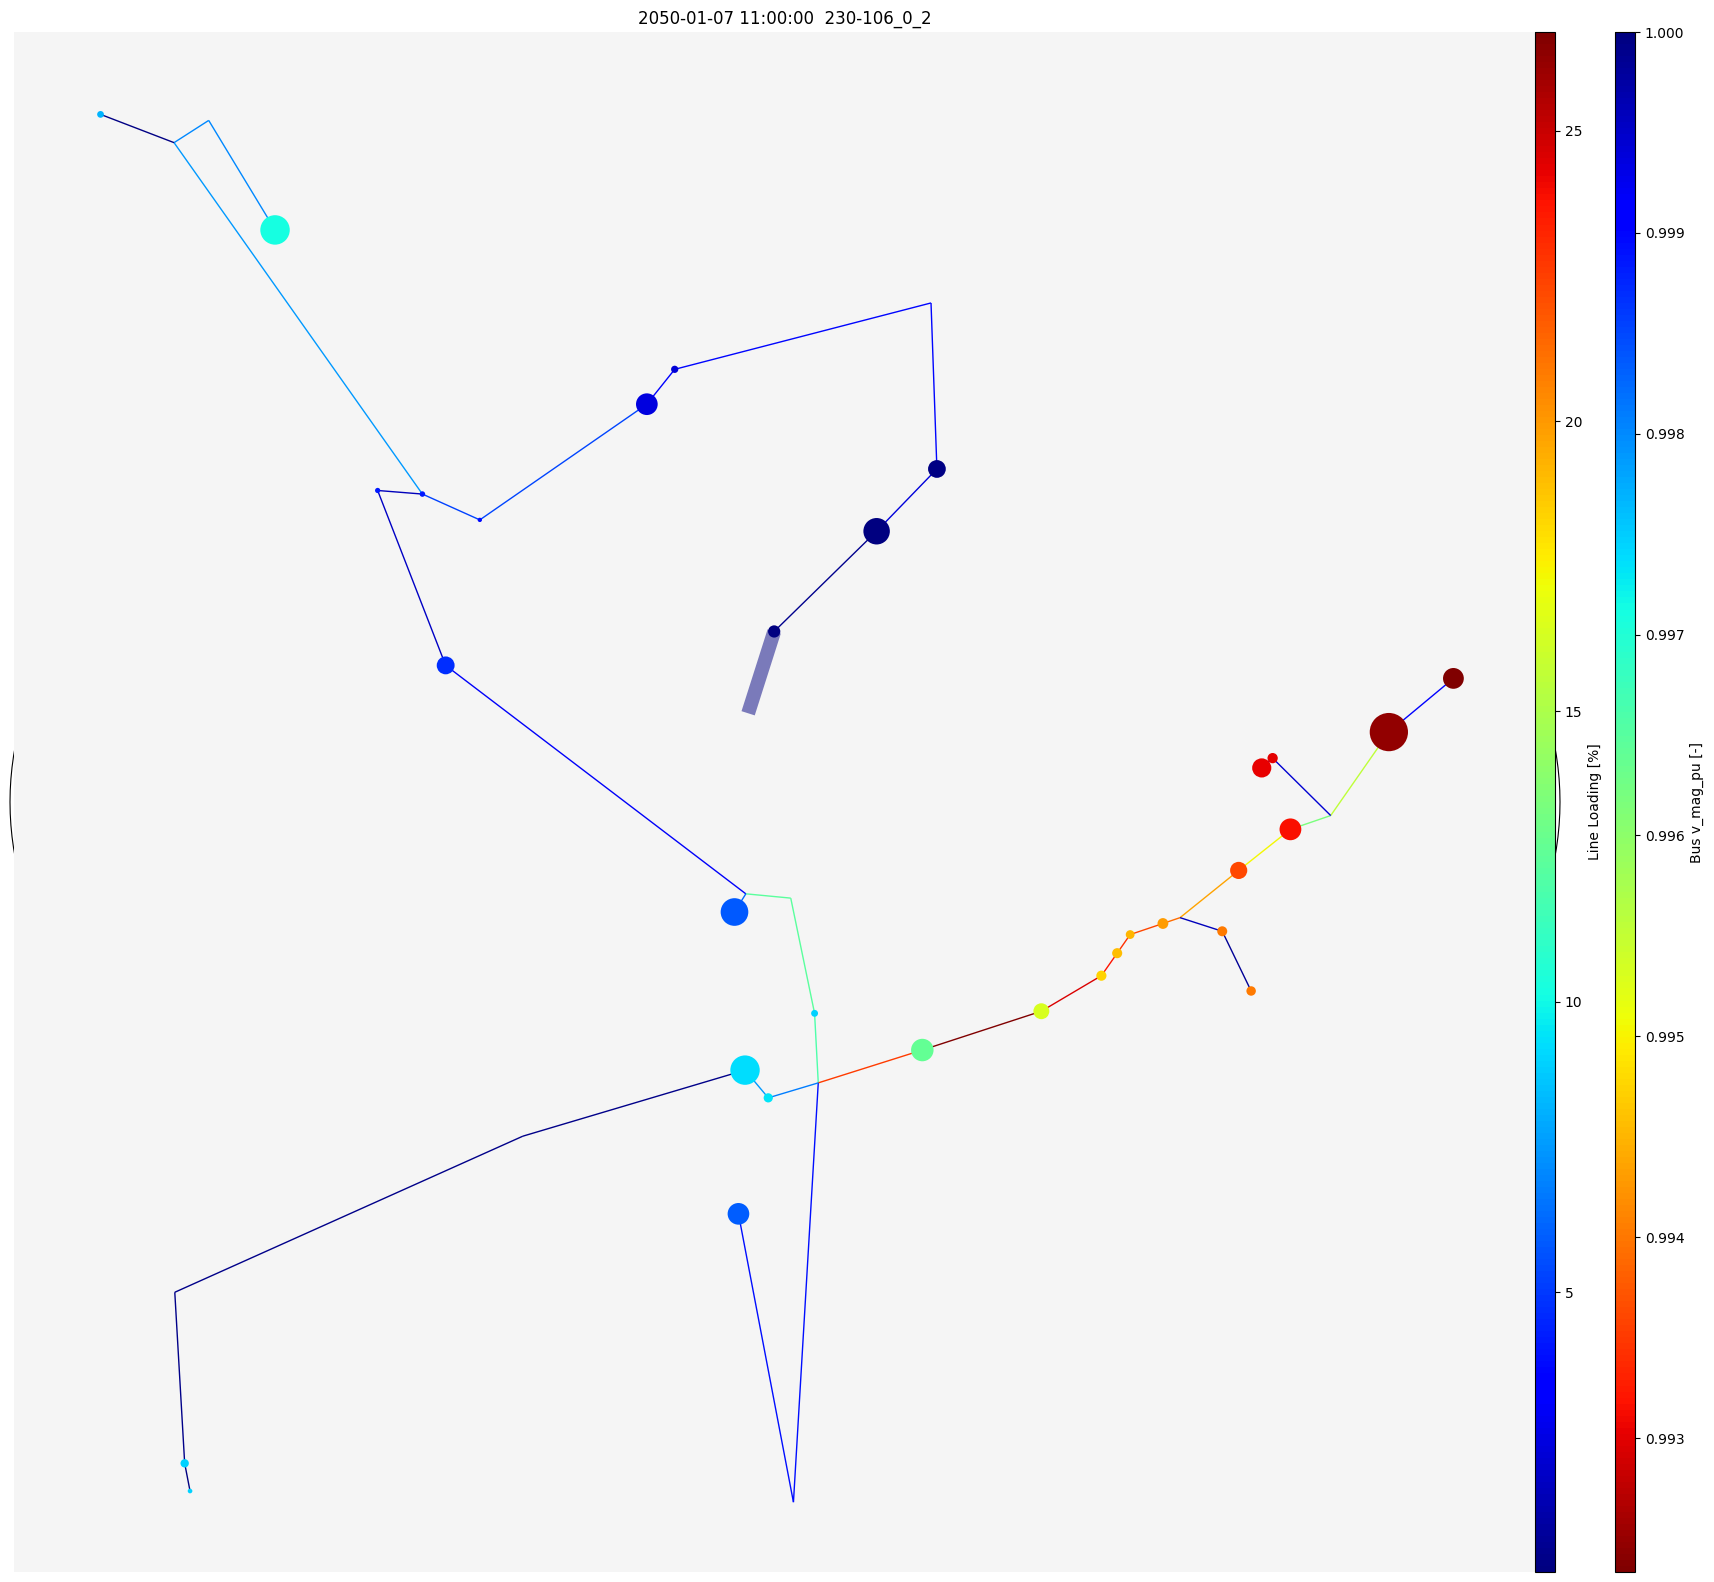

/usr/local/Caskroom/miniforge/base/envs/vtog/lib/python3.10/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning:

facecolor will have no effect as it has been defined as "never".



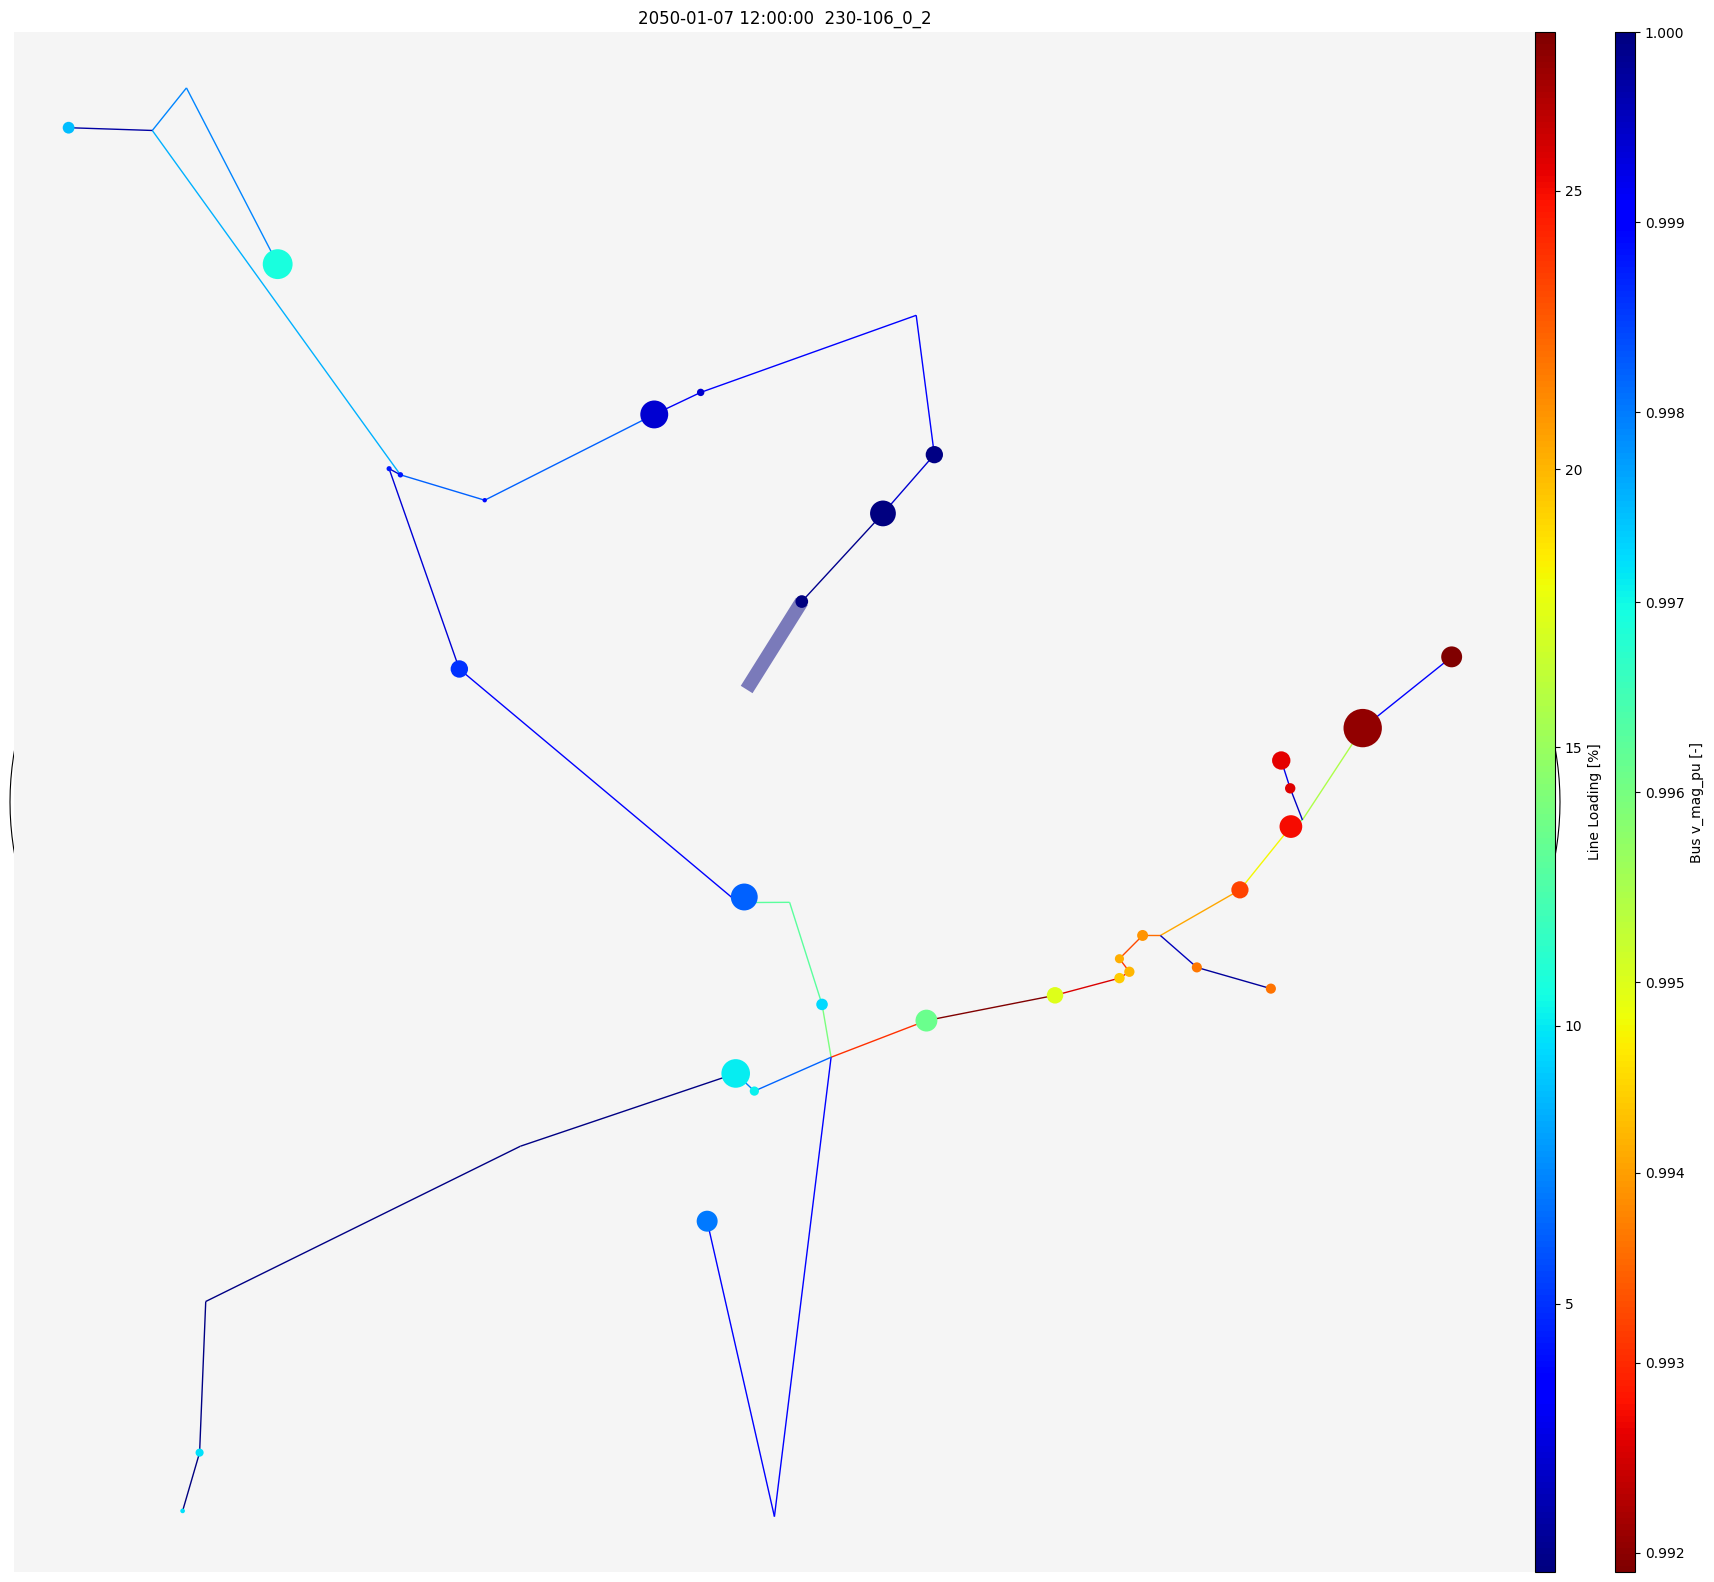

/usr/local/Caskroom/miniforge/base/envs/vtog/lib/python3.10/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning:

facecolor will have no effect as it has been defined as "never".



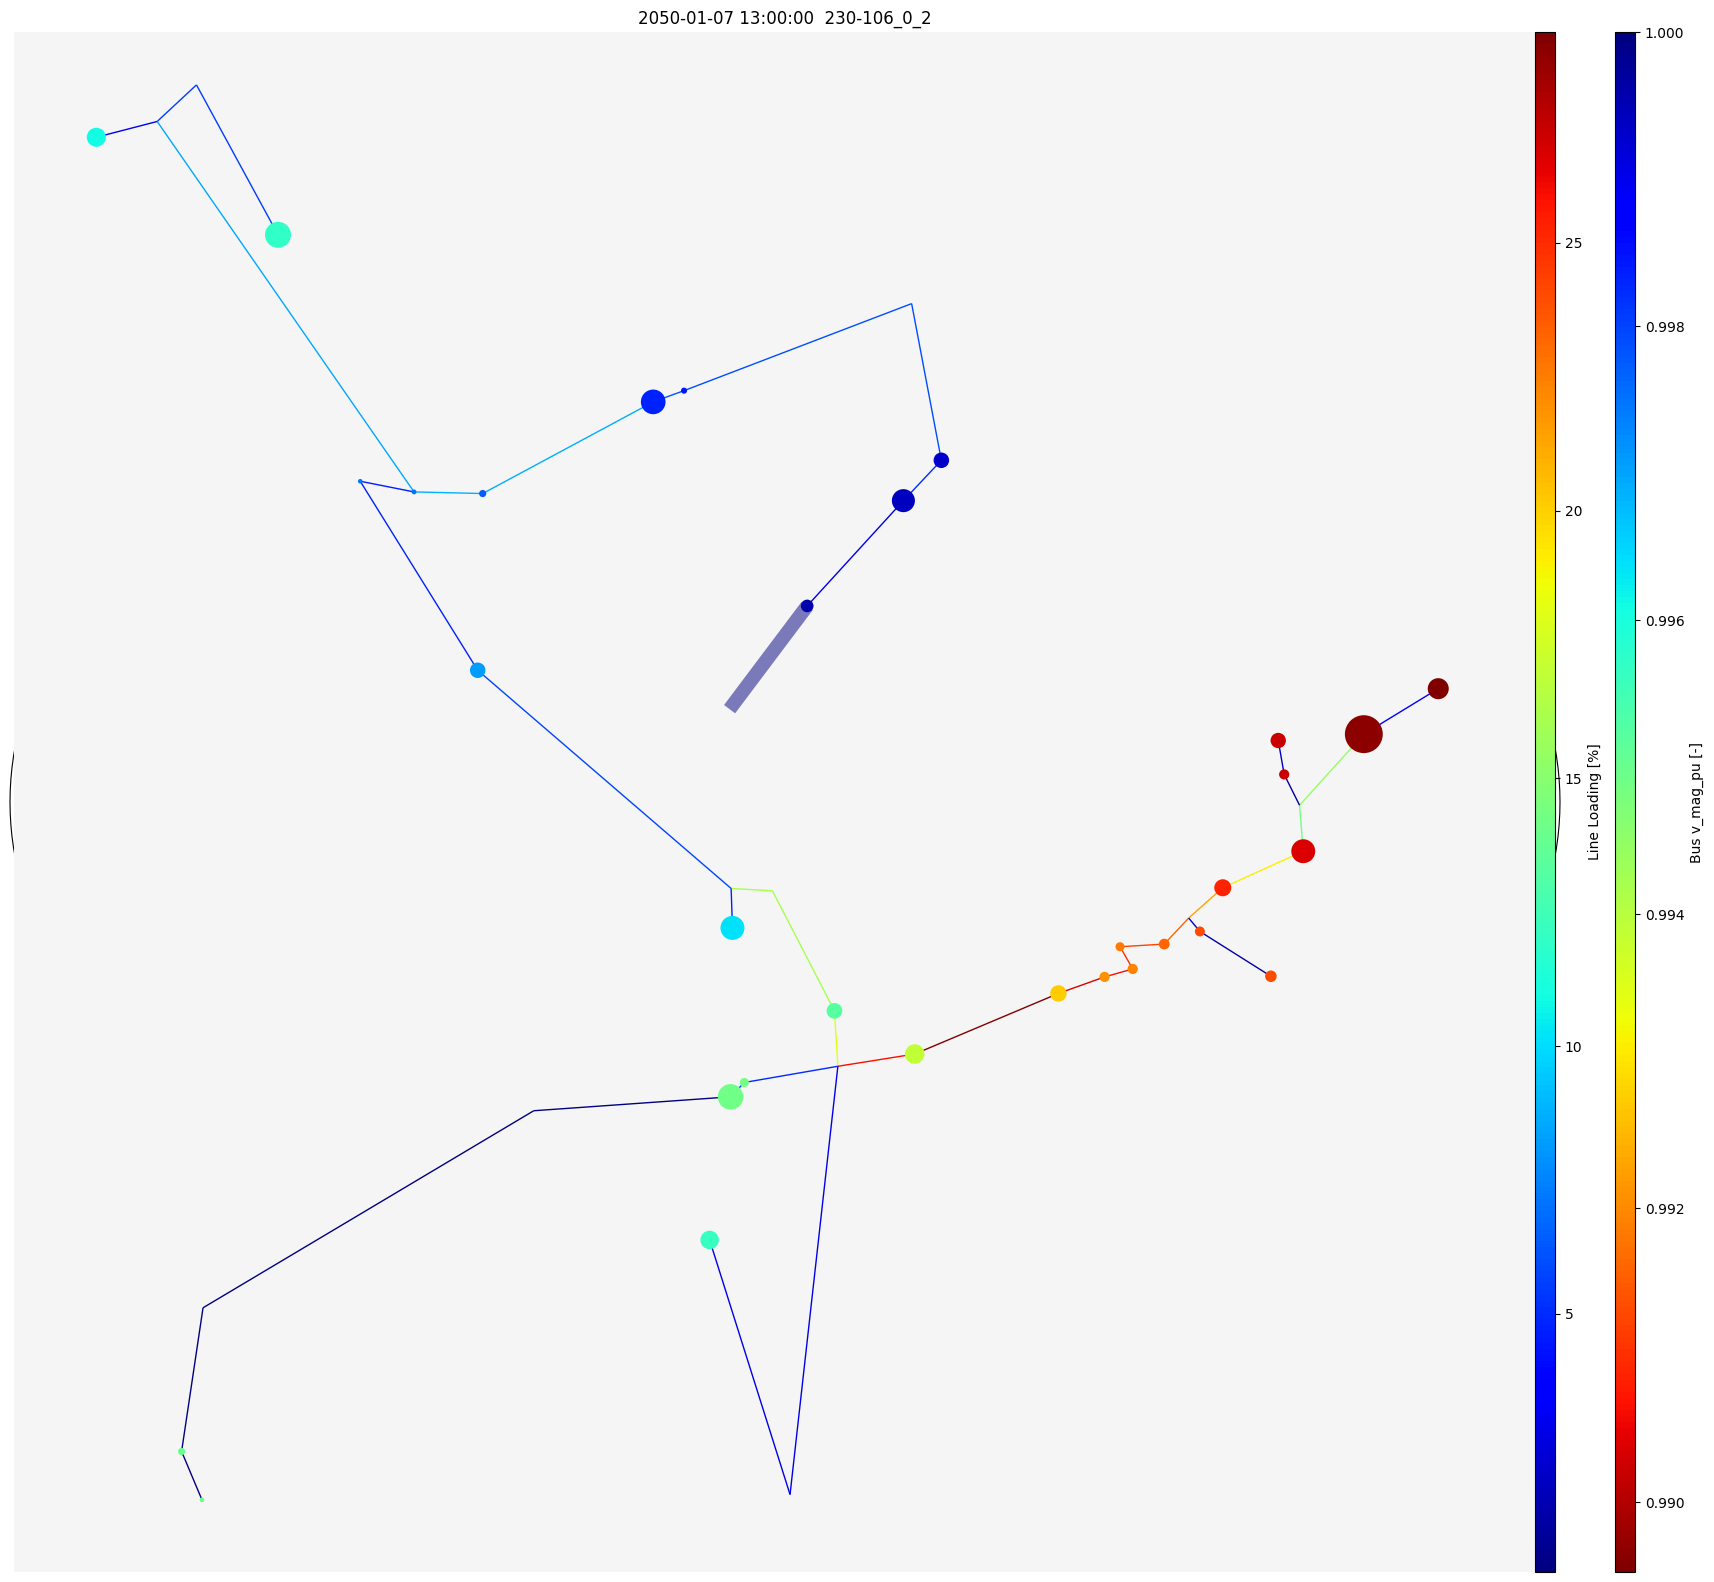

/usr/local/Caskroom/miniforge/base/envs/vtog/lib/python3.10/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning:

facecolor will have no effect as it has been defined as "never".



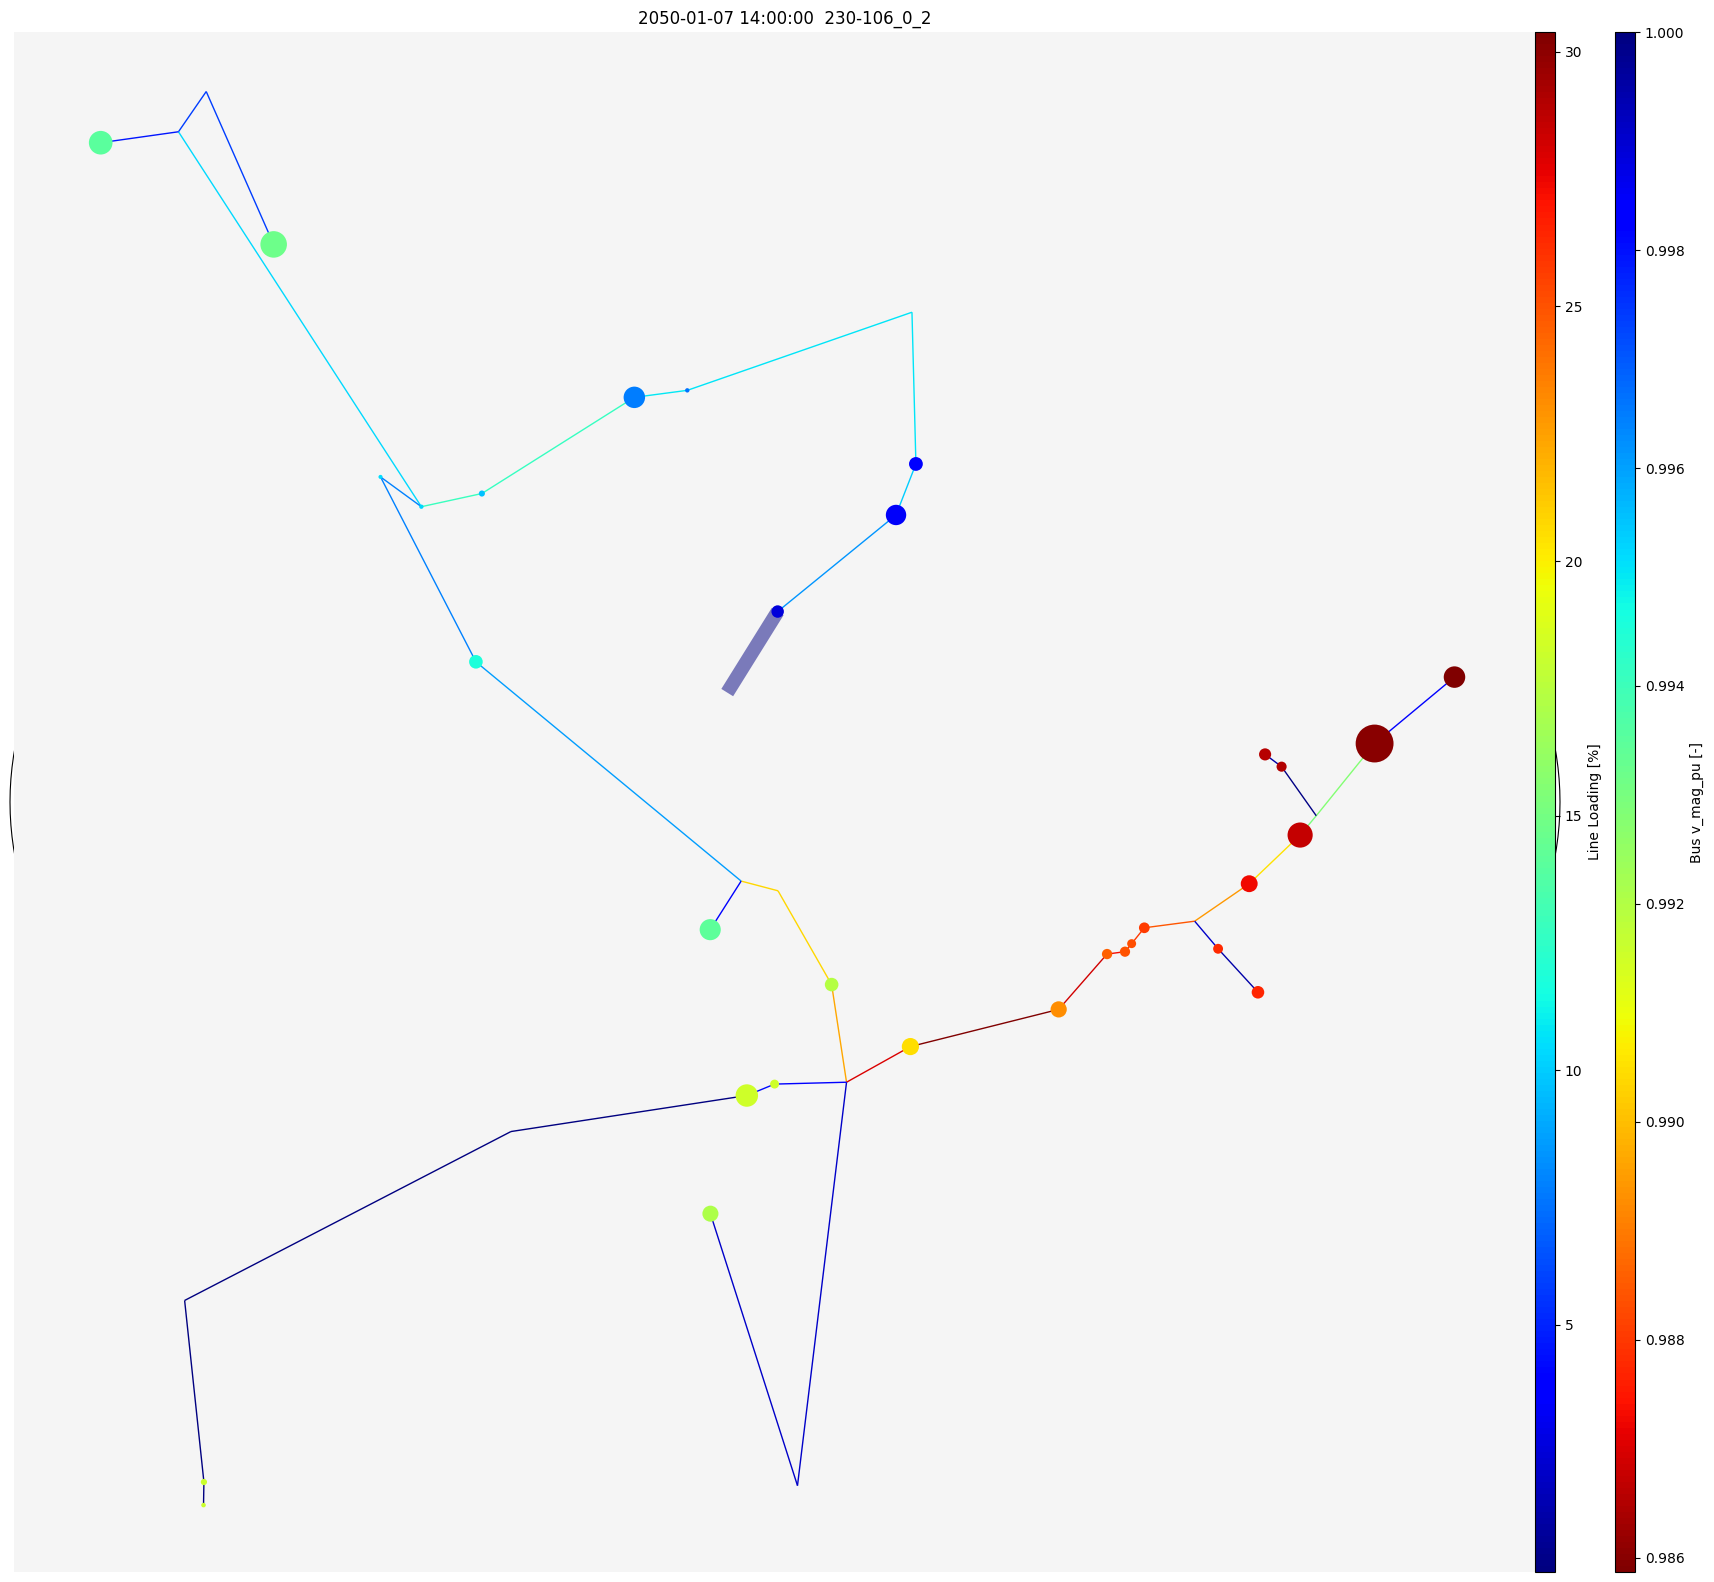

/usr/local/Caskroom/miniforge/base/envs/vtog/lib/python3.10/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning:

facecolor will have no effect as it has been defined as "never".



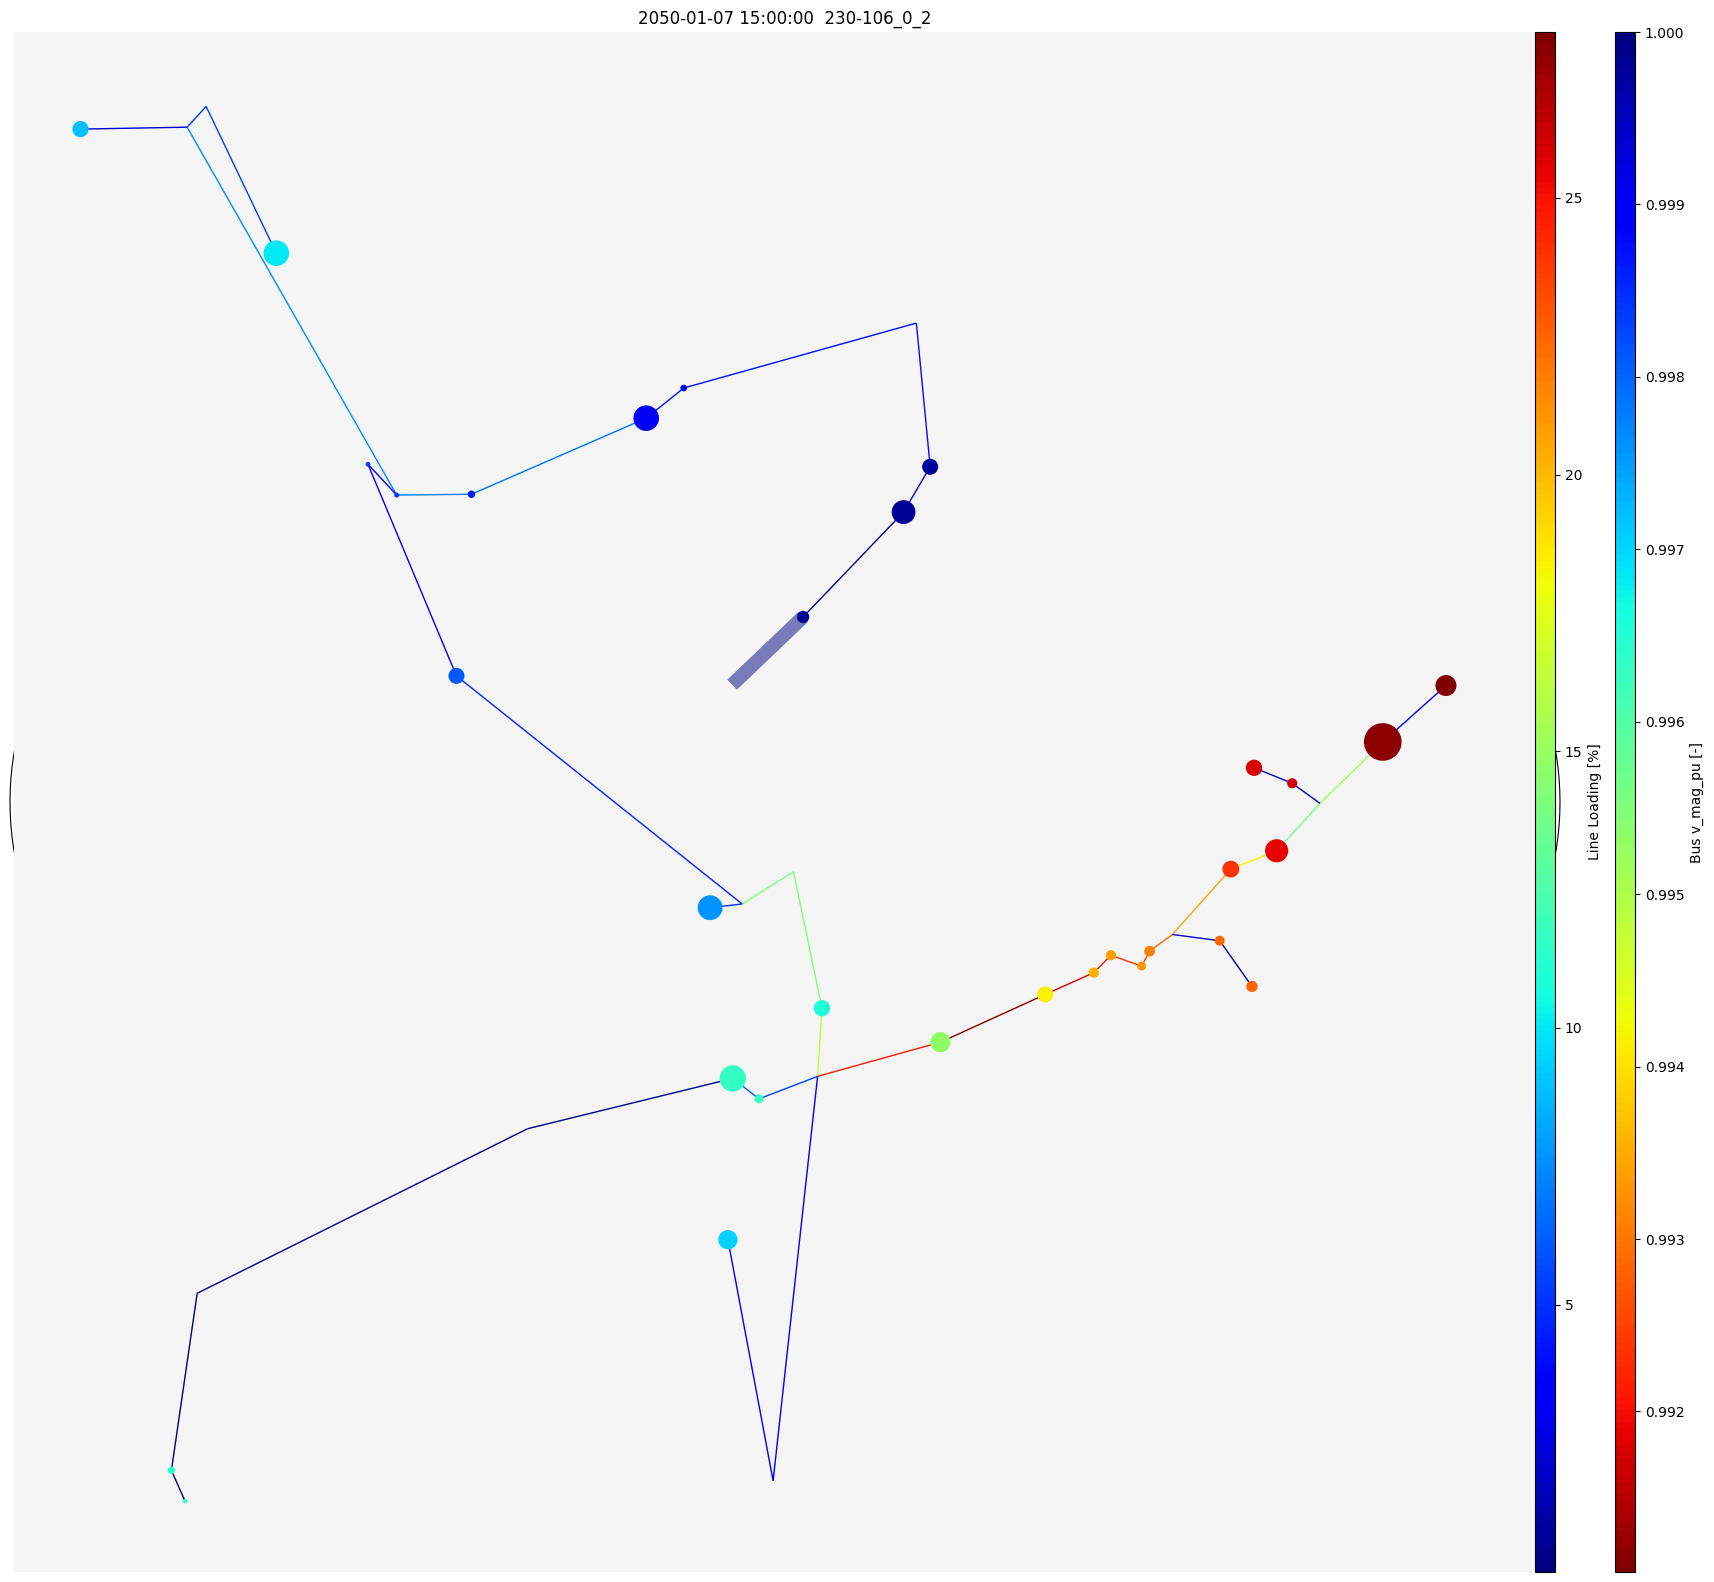

/usr/local/Caskroom/miniforge/base/envs/vtog/lib/python3.10/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning:

facecolor will have no effect as it has been defined as "never".



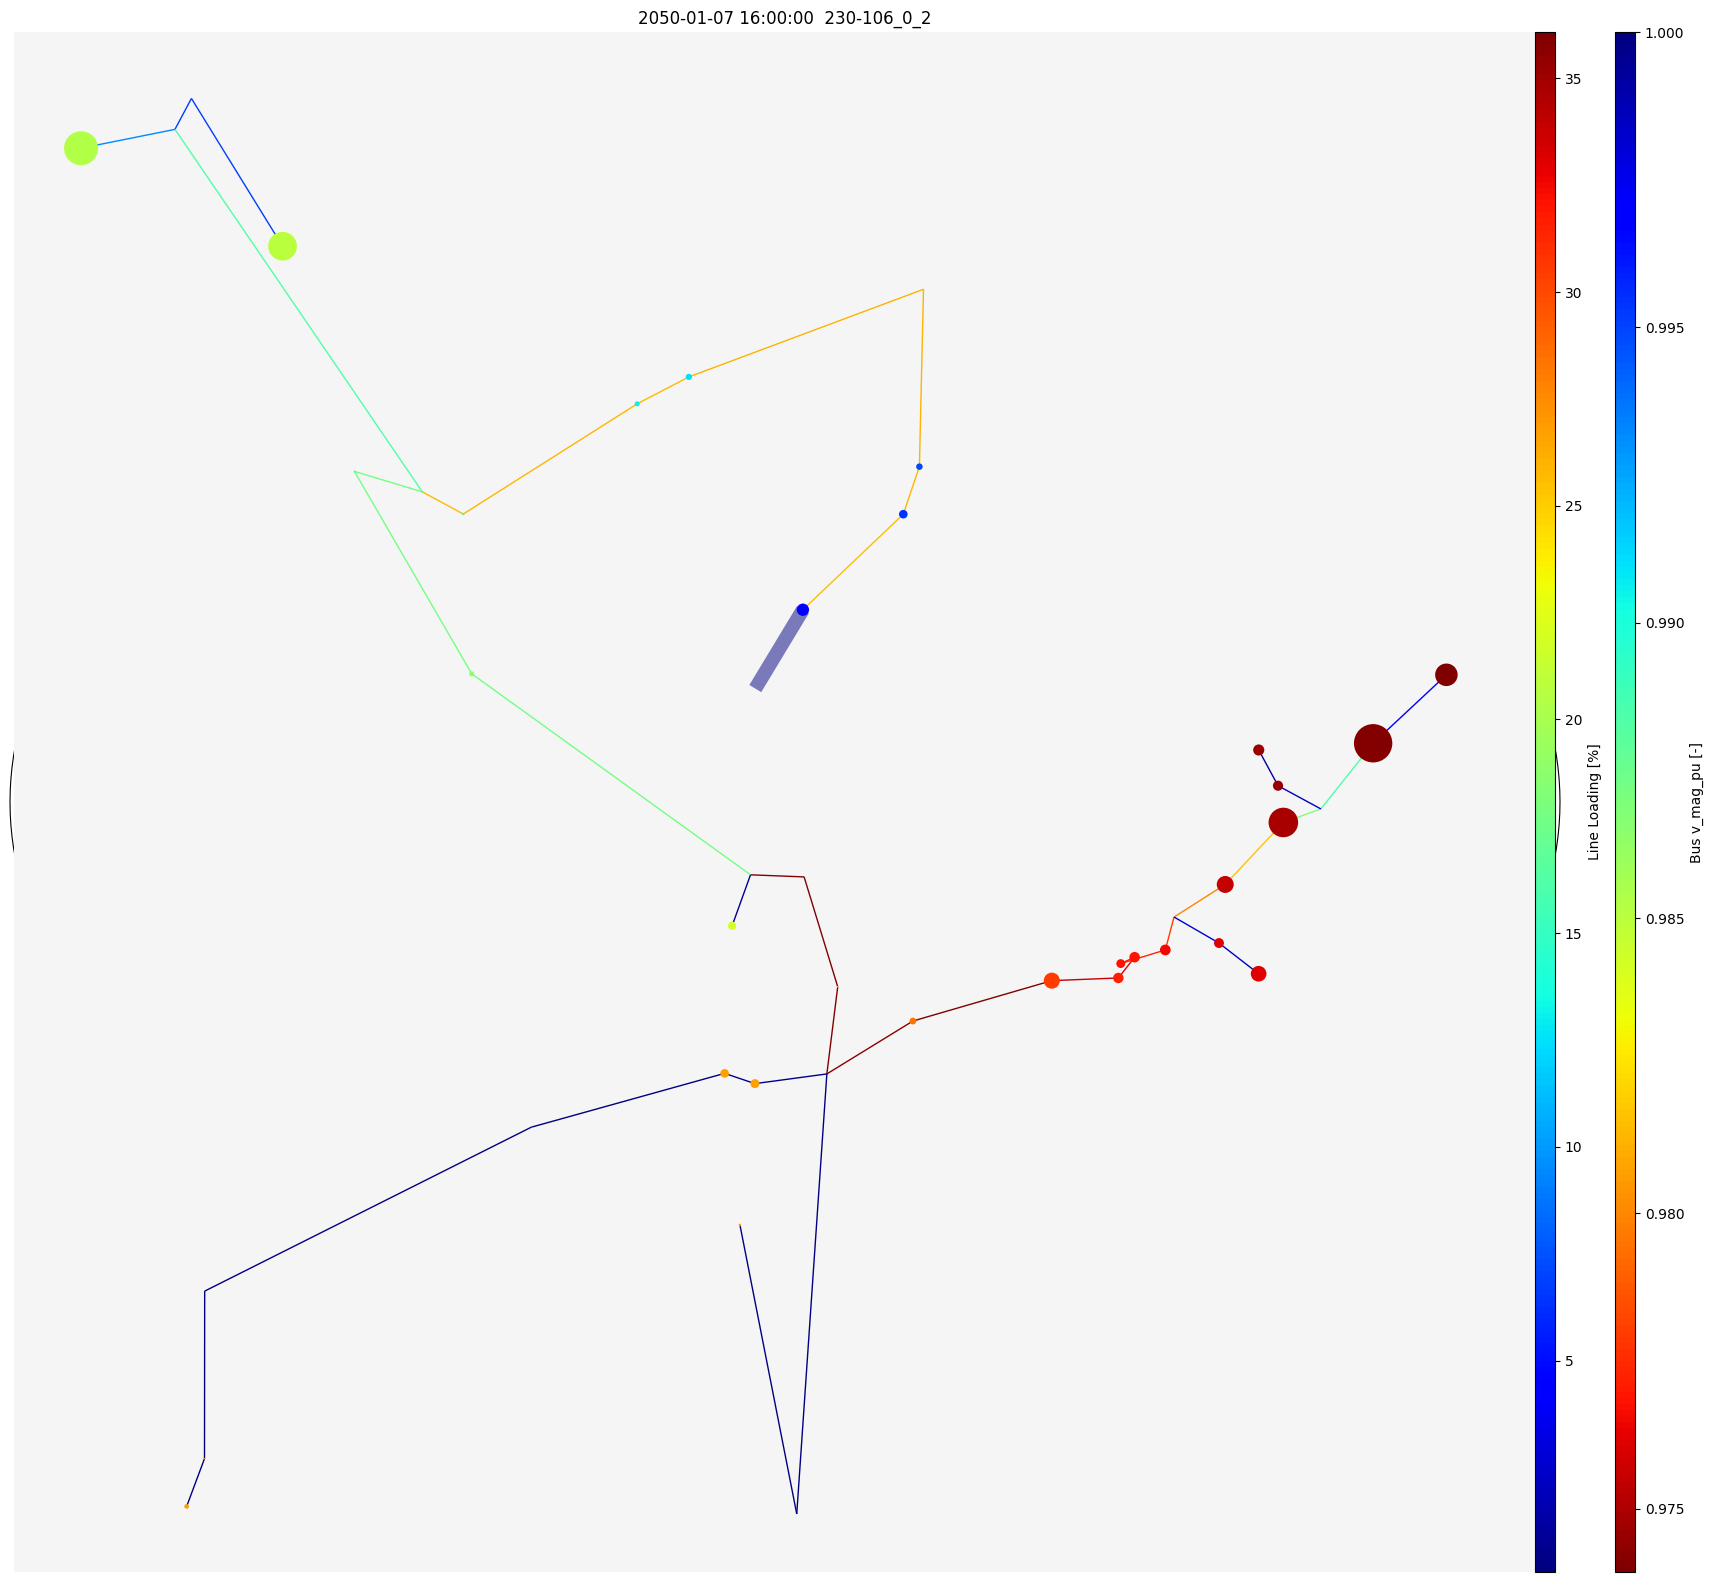

/usr/local/Caskroom/miniforge/base/envs/vtog/lib/python3.10/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning:

facecolor will have no effect as it has been defined as "never".



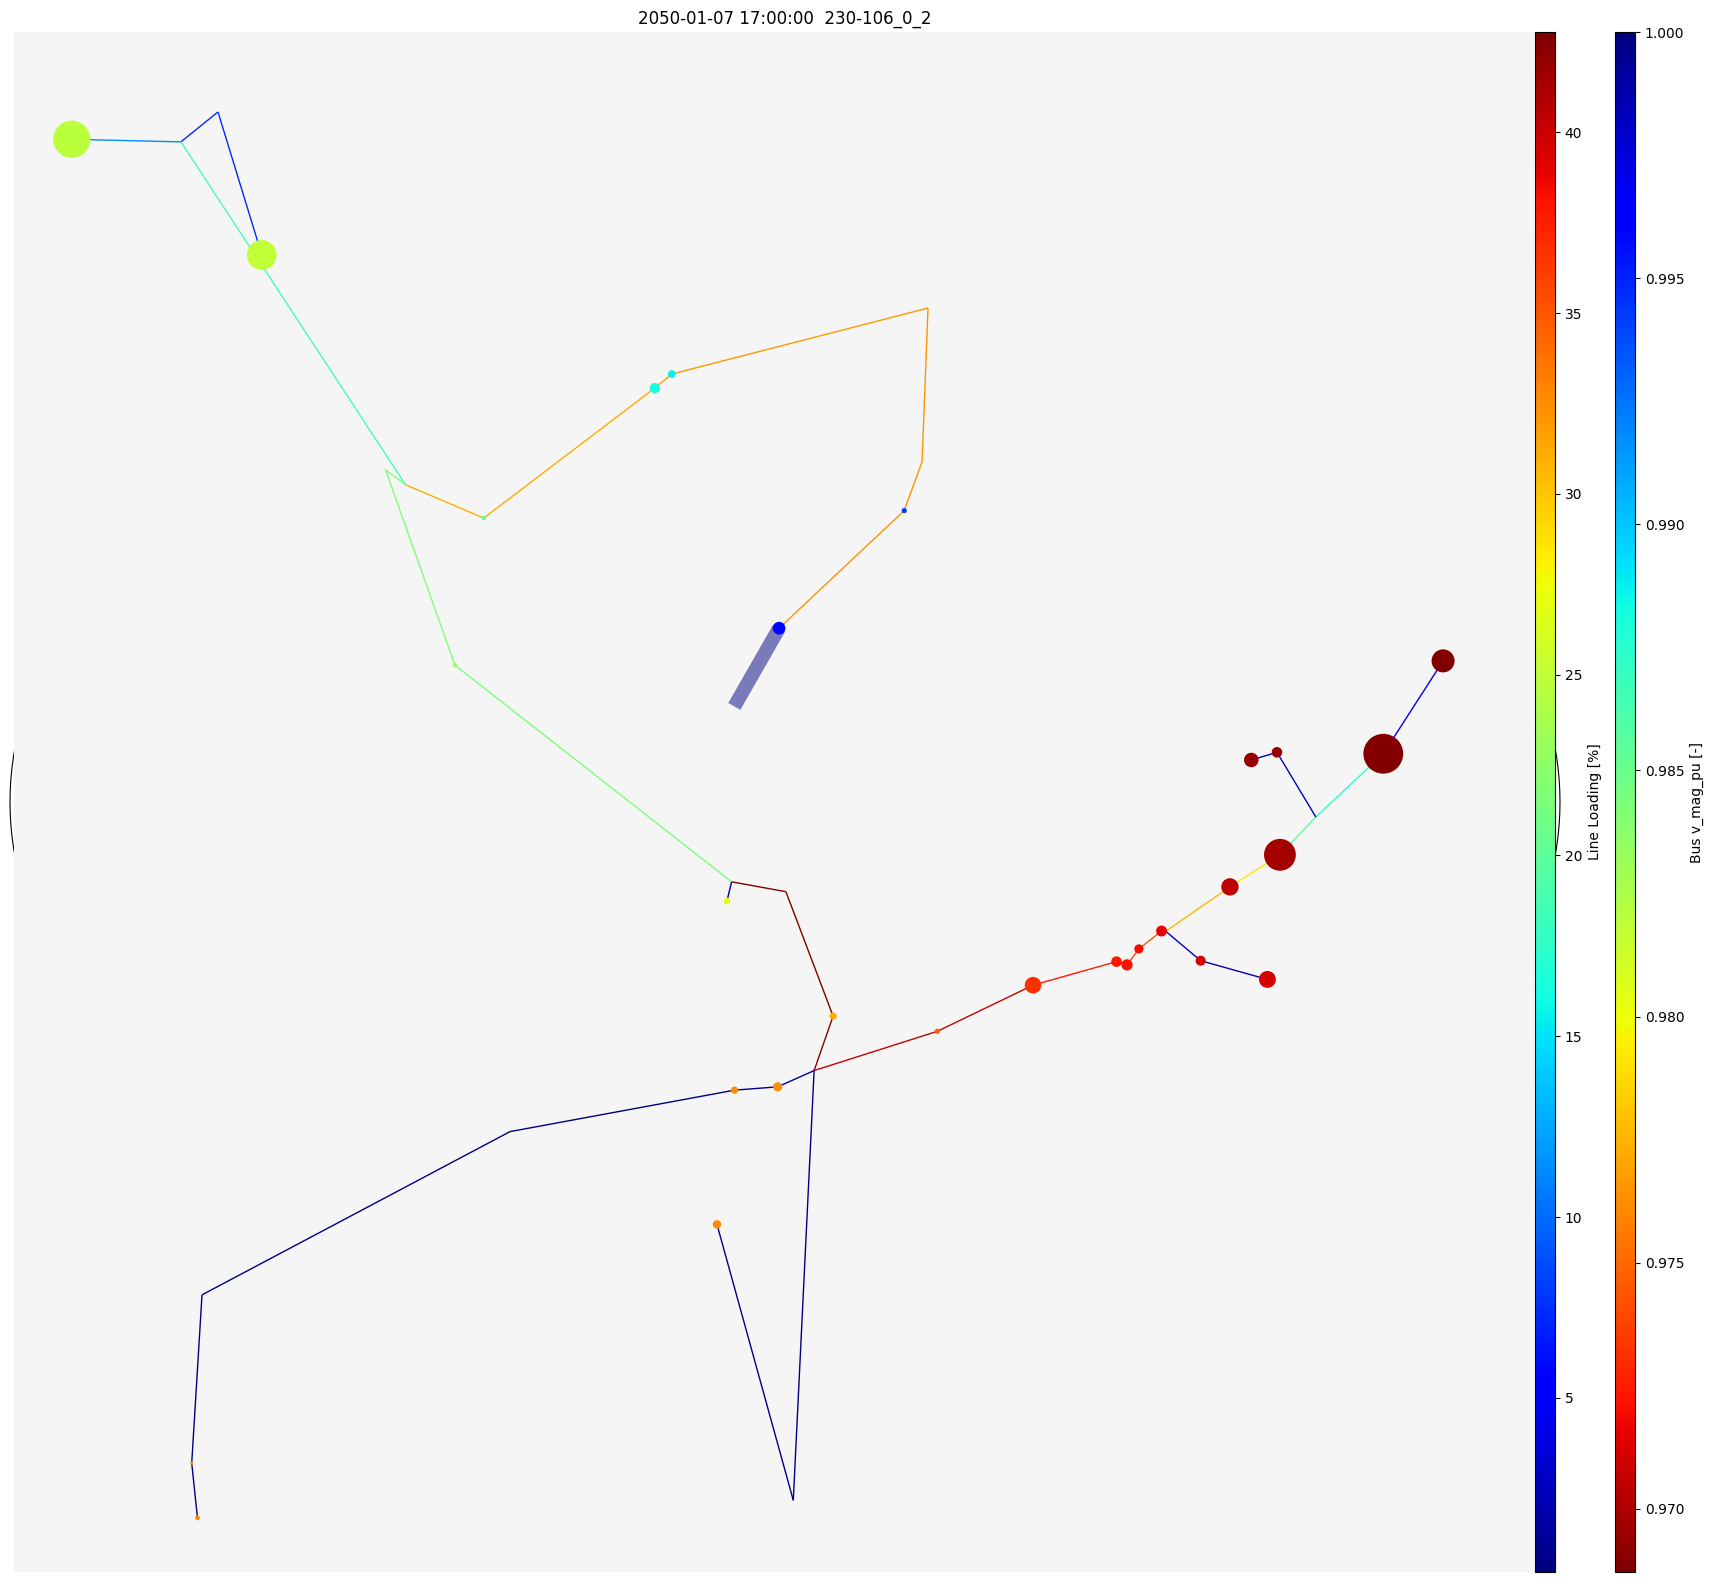

/usr/local/Caskroom/miniforge/base/envs/vtog/lib/python3.10/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning:

facecolor will have no effect as it has been defined as "never".



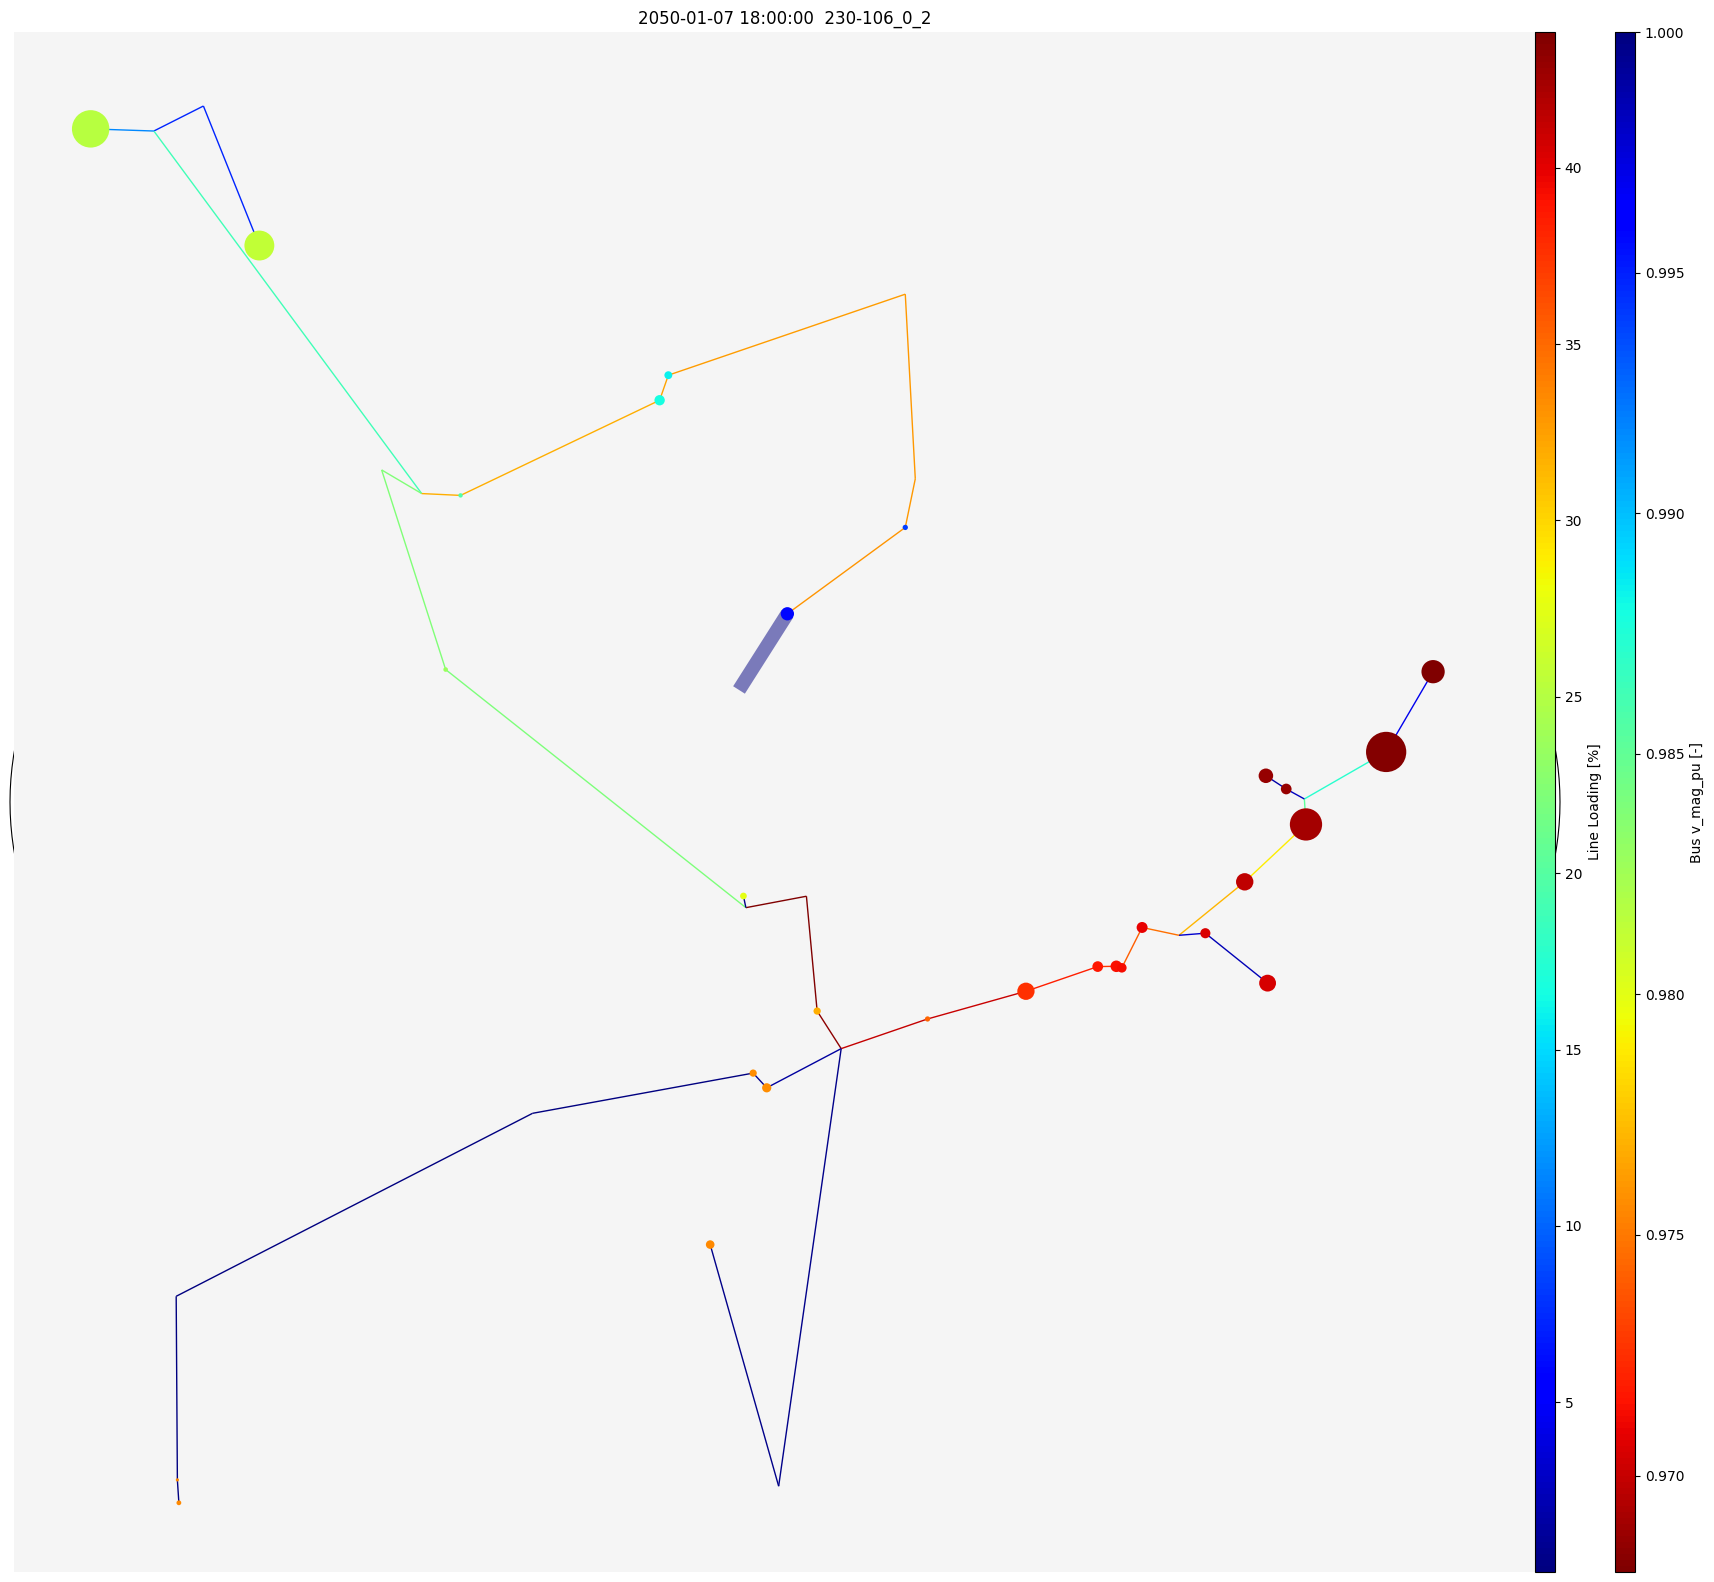

/usr/local/Caskroom/miniforge/base/envs/vtog/lib/python3.10/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning:

facecolor will have no effect as it has been defined as "never".



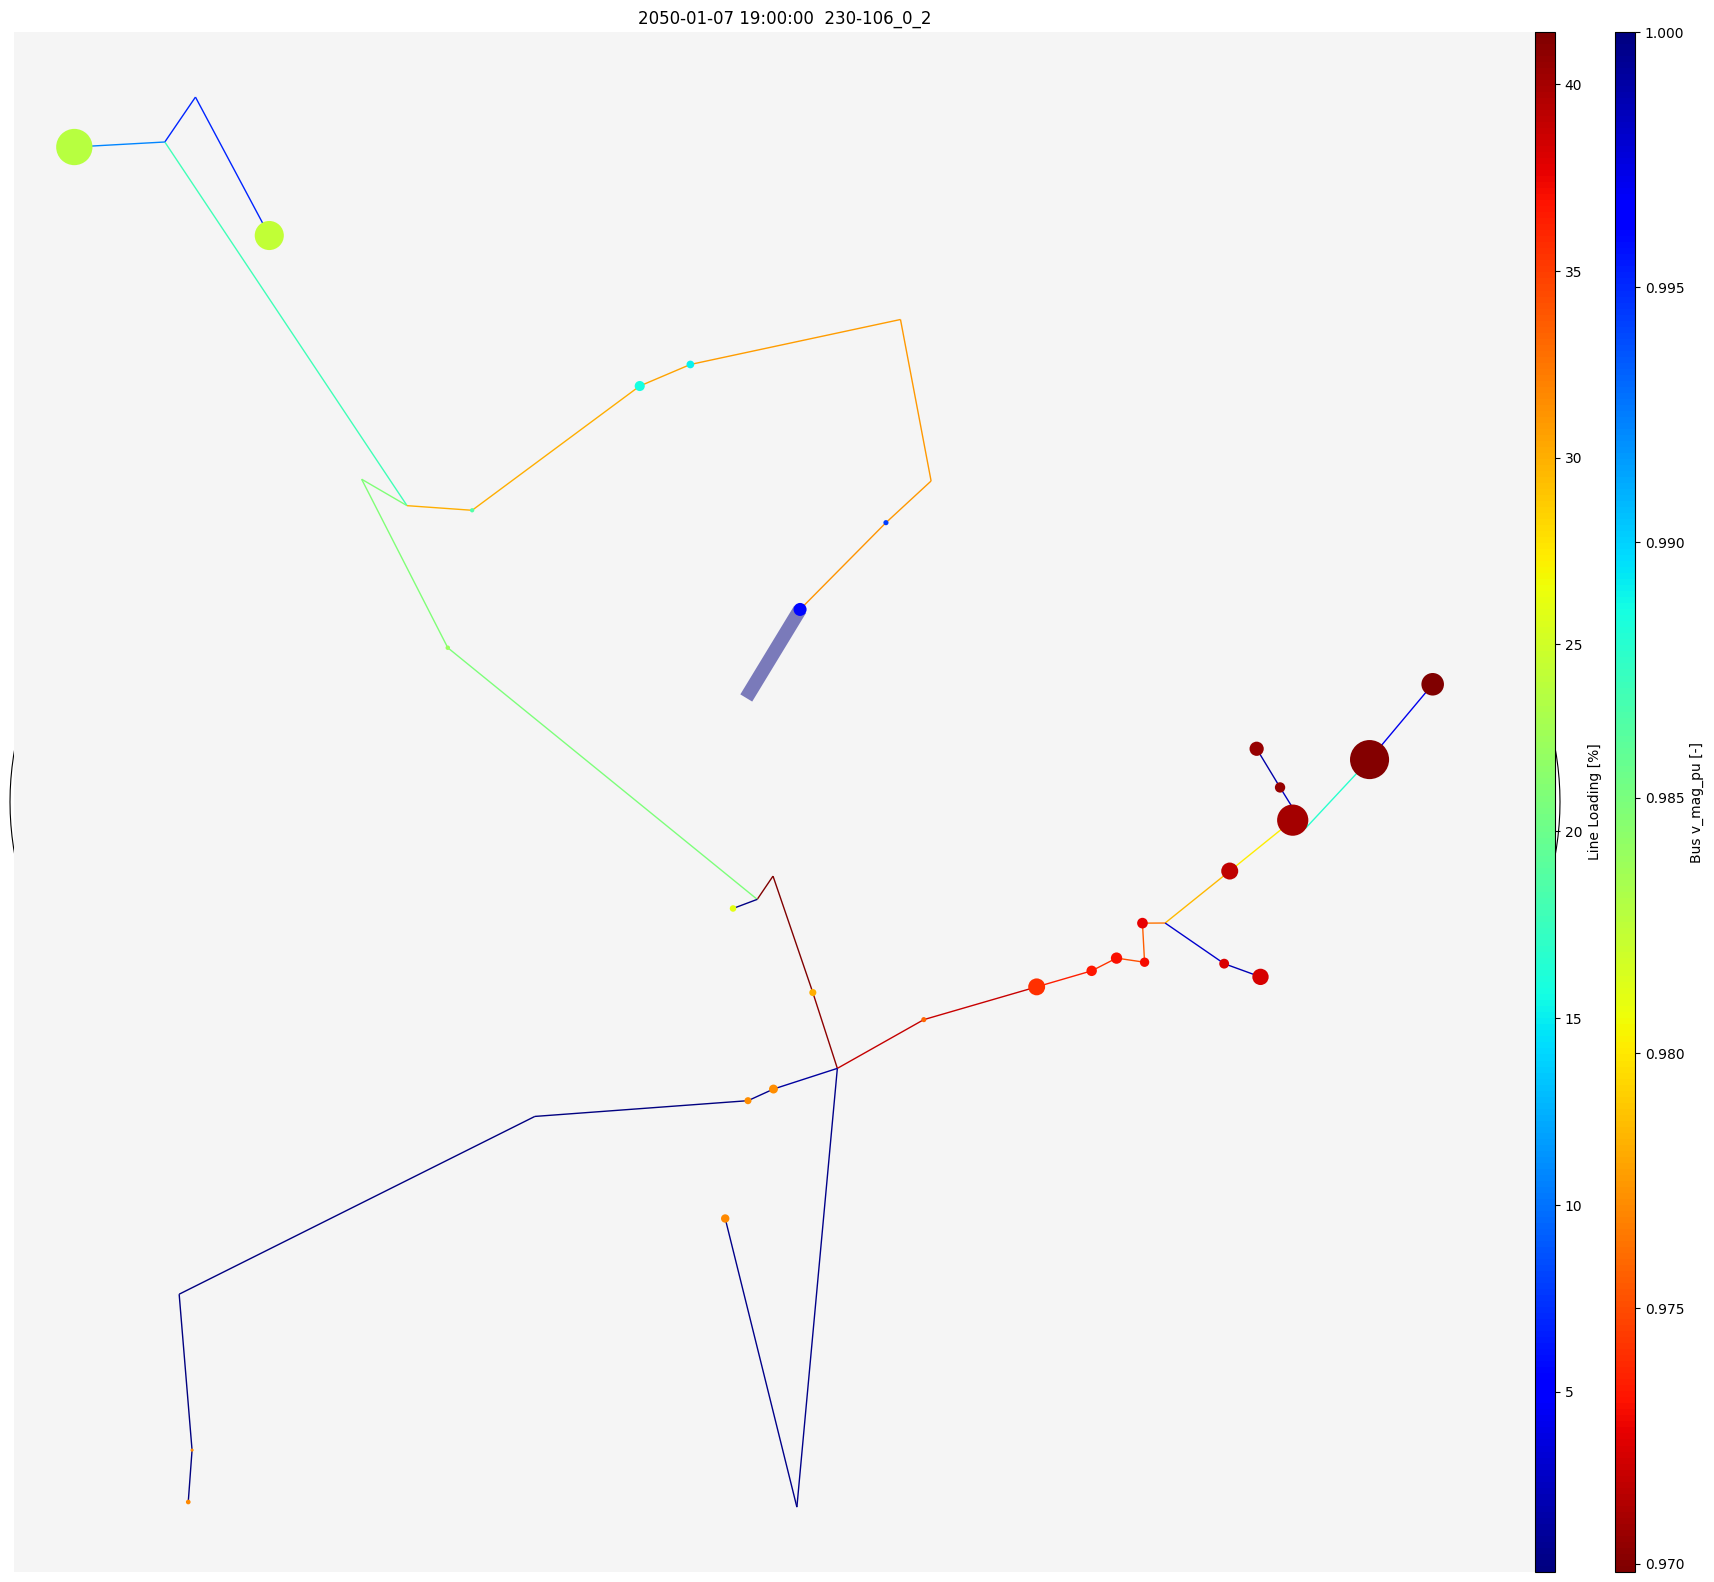

/usr/local/Caskroom/miniforge/base/envs/vtog/lib/python3.10/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning:

facecolor will have no effect as it has been defined as "never".



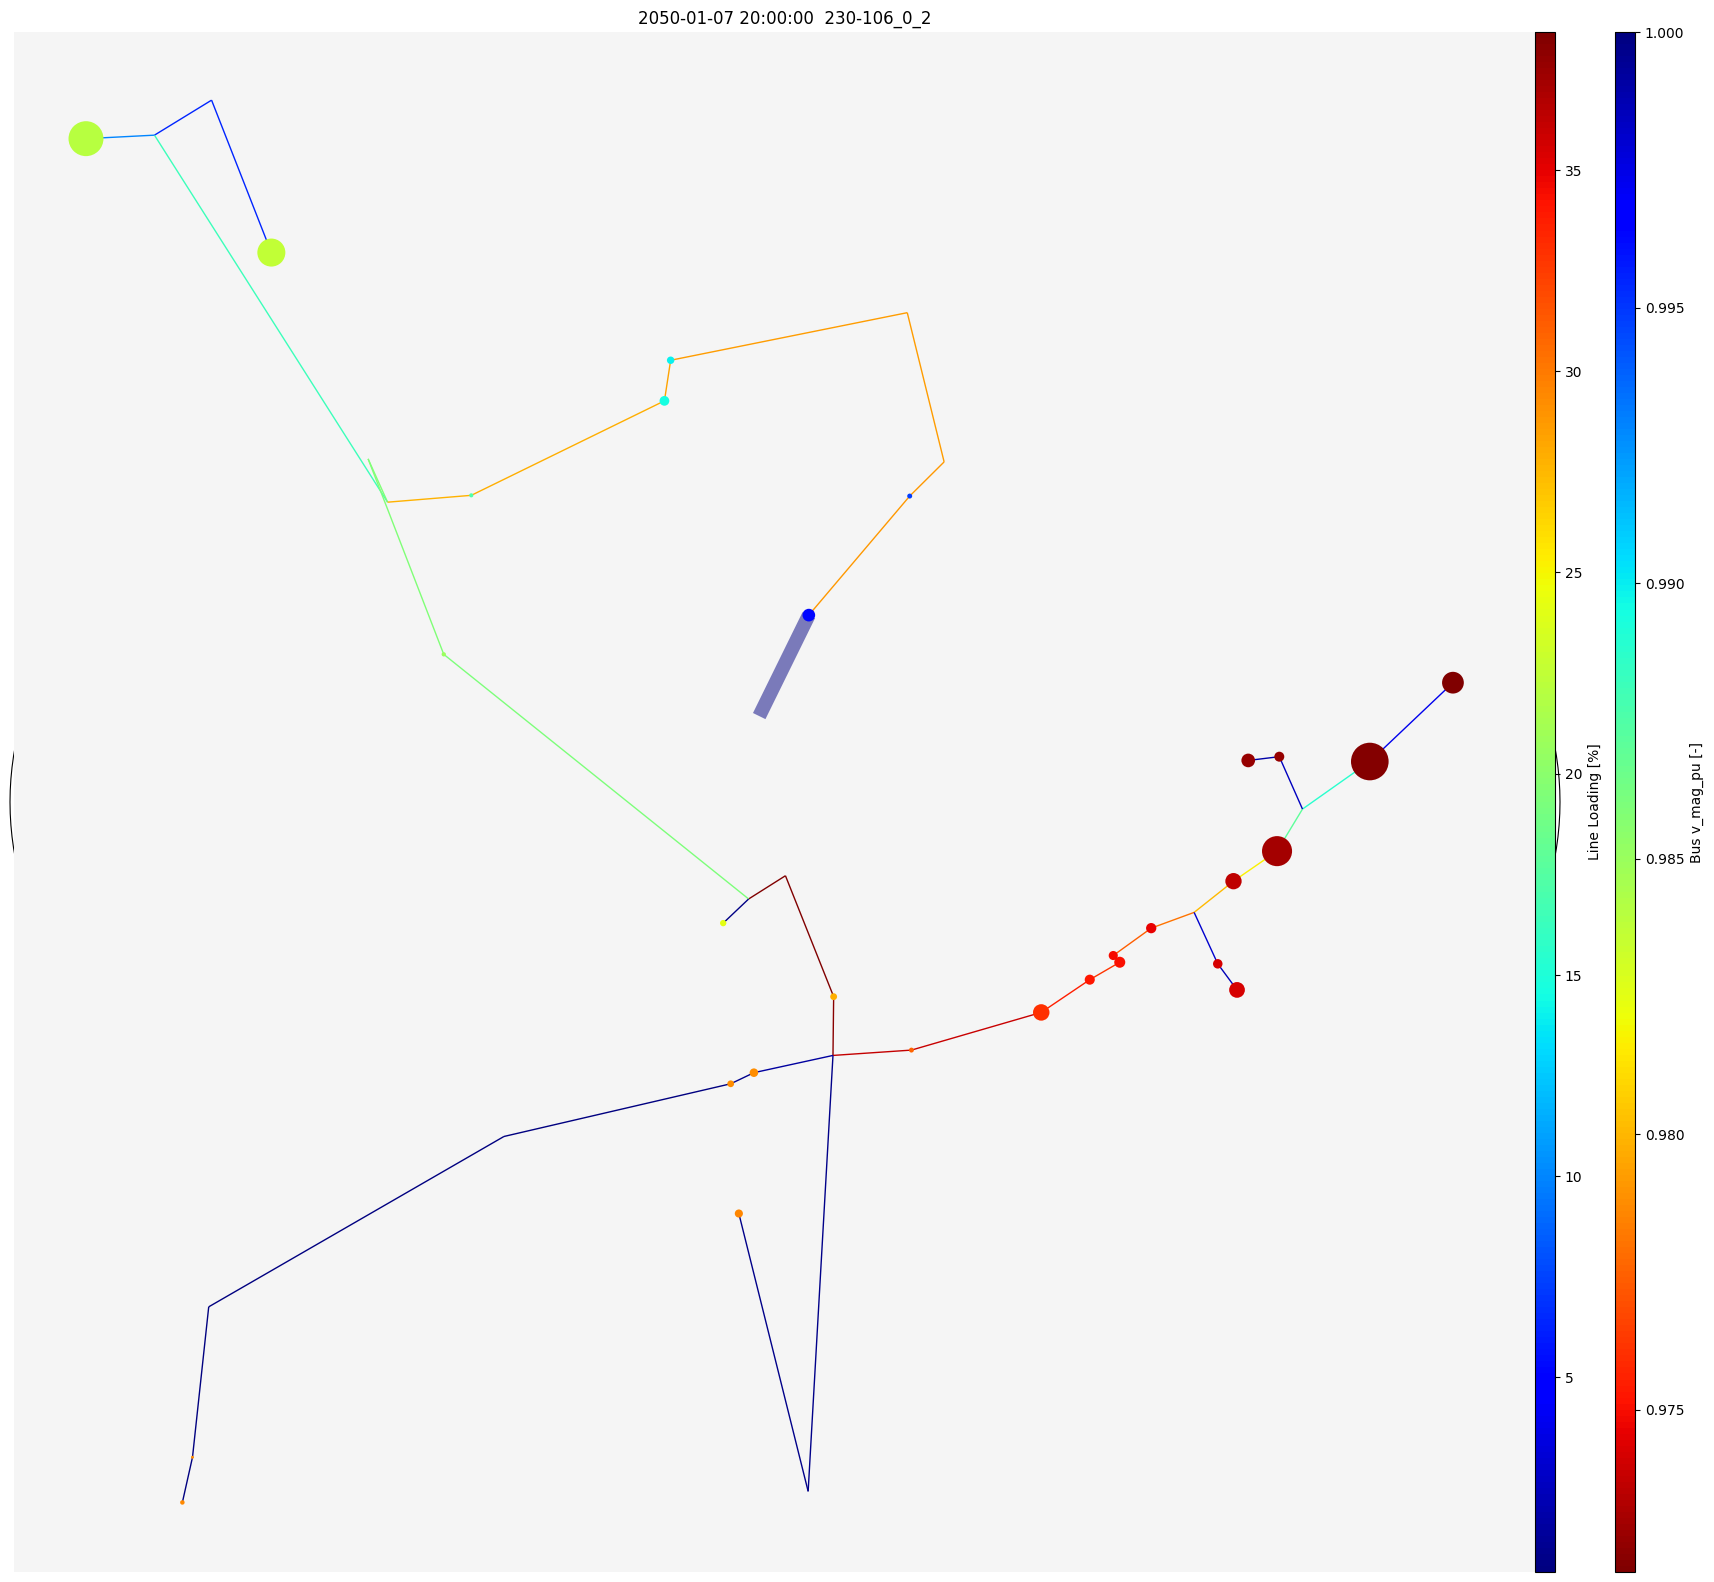

/usr/local/Caskroom/miniforge/base/envs/vtog/lib/python3.10/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning:

facecolor will have no effect as it has been defined as "never".



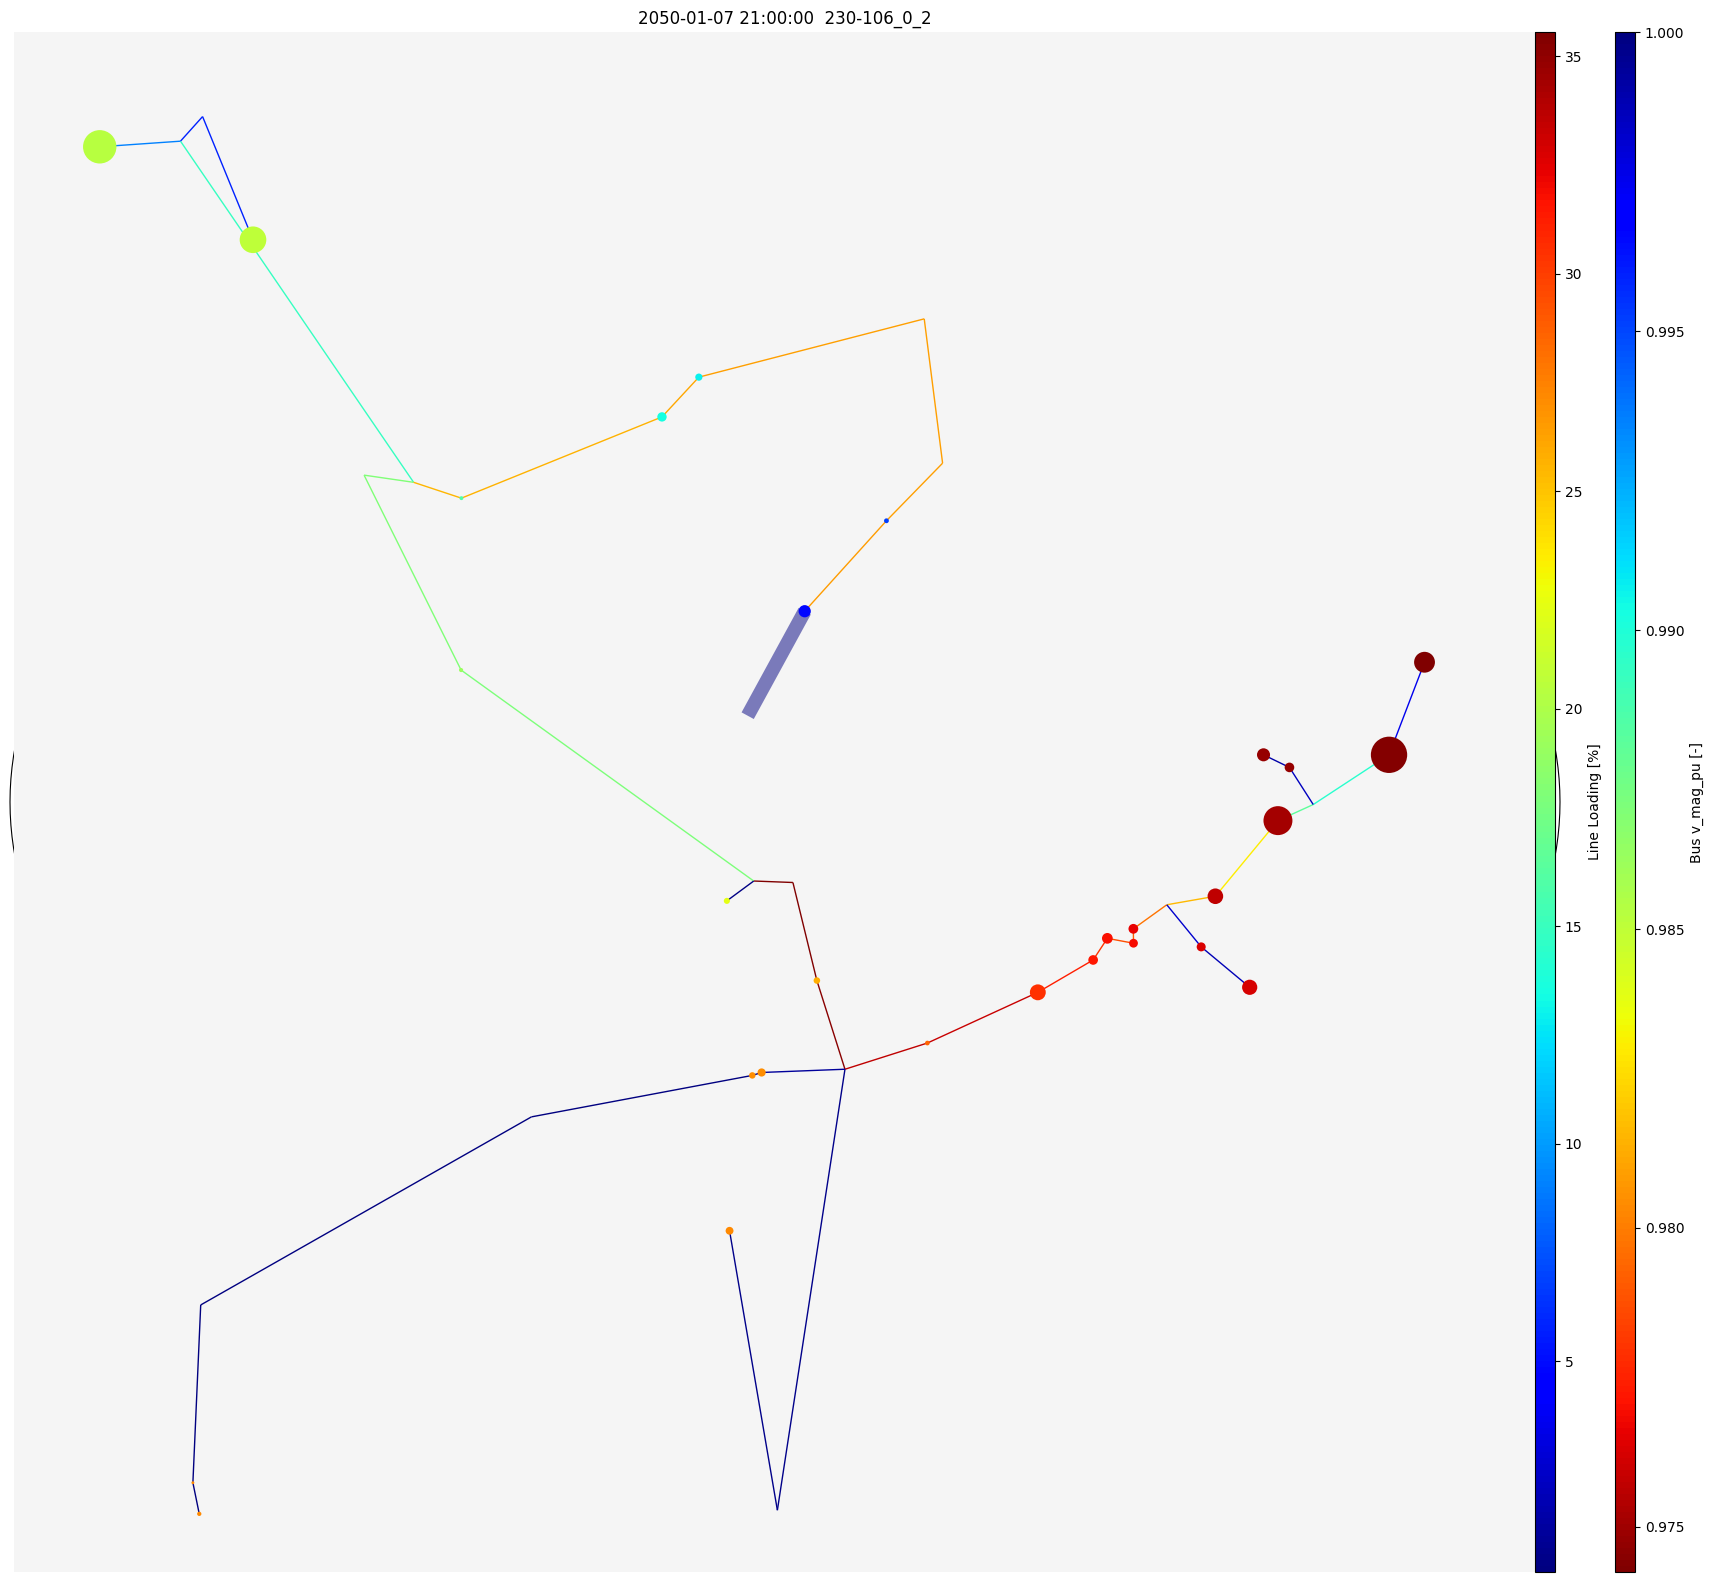

/usr/local/Caskroom/miniforge/base/envs/vtog/lib/python3.10/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning:

facecolor will have no effect as it has been defined as "never".



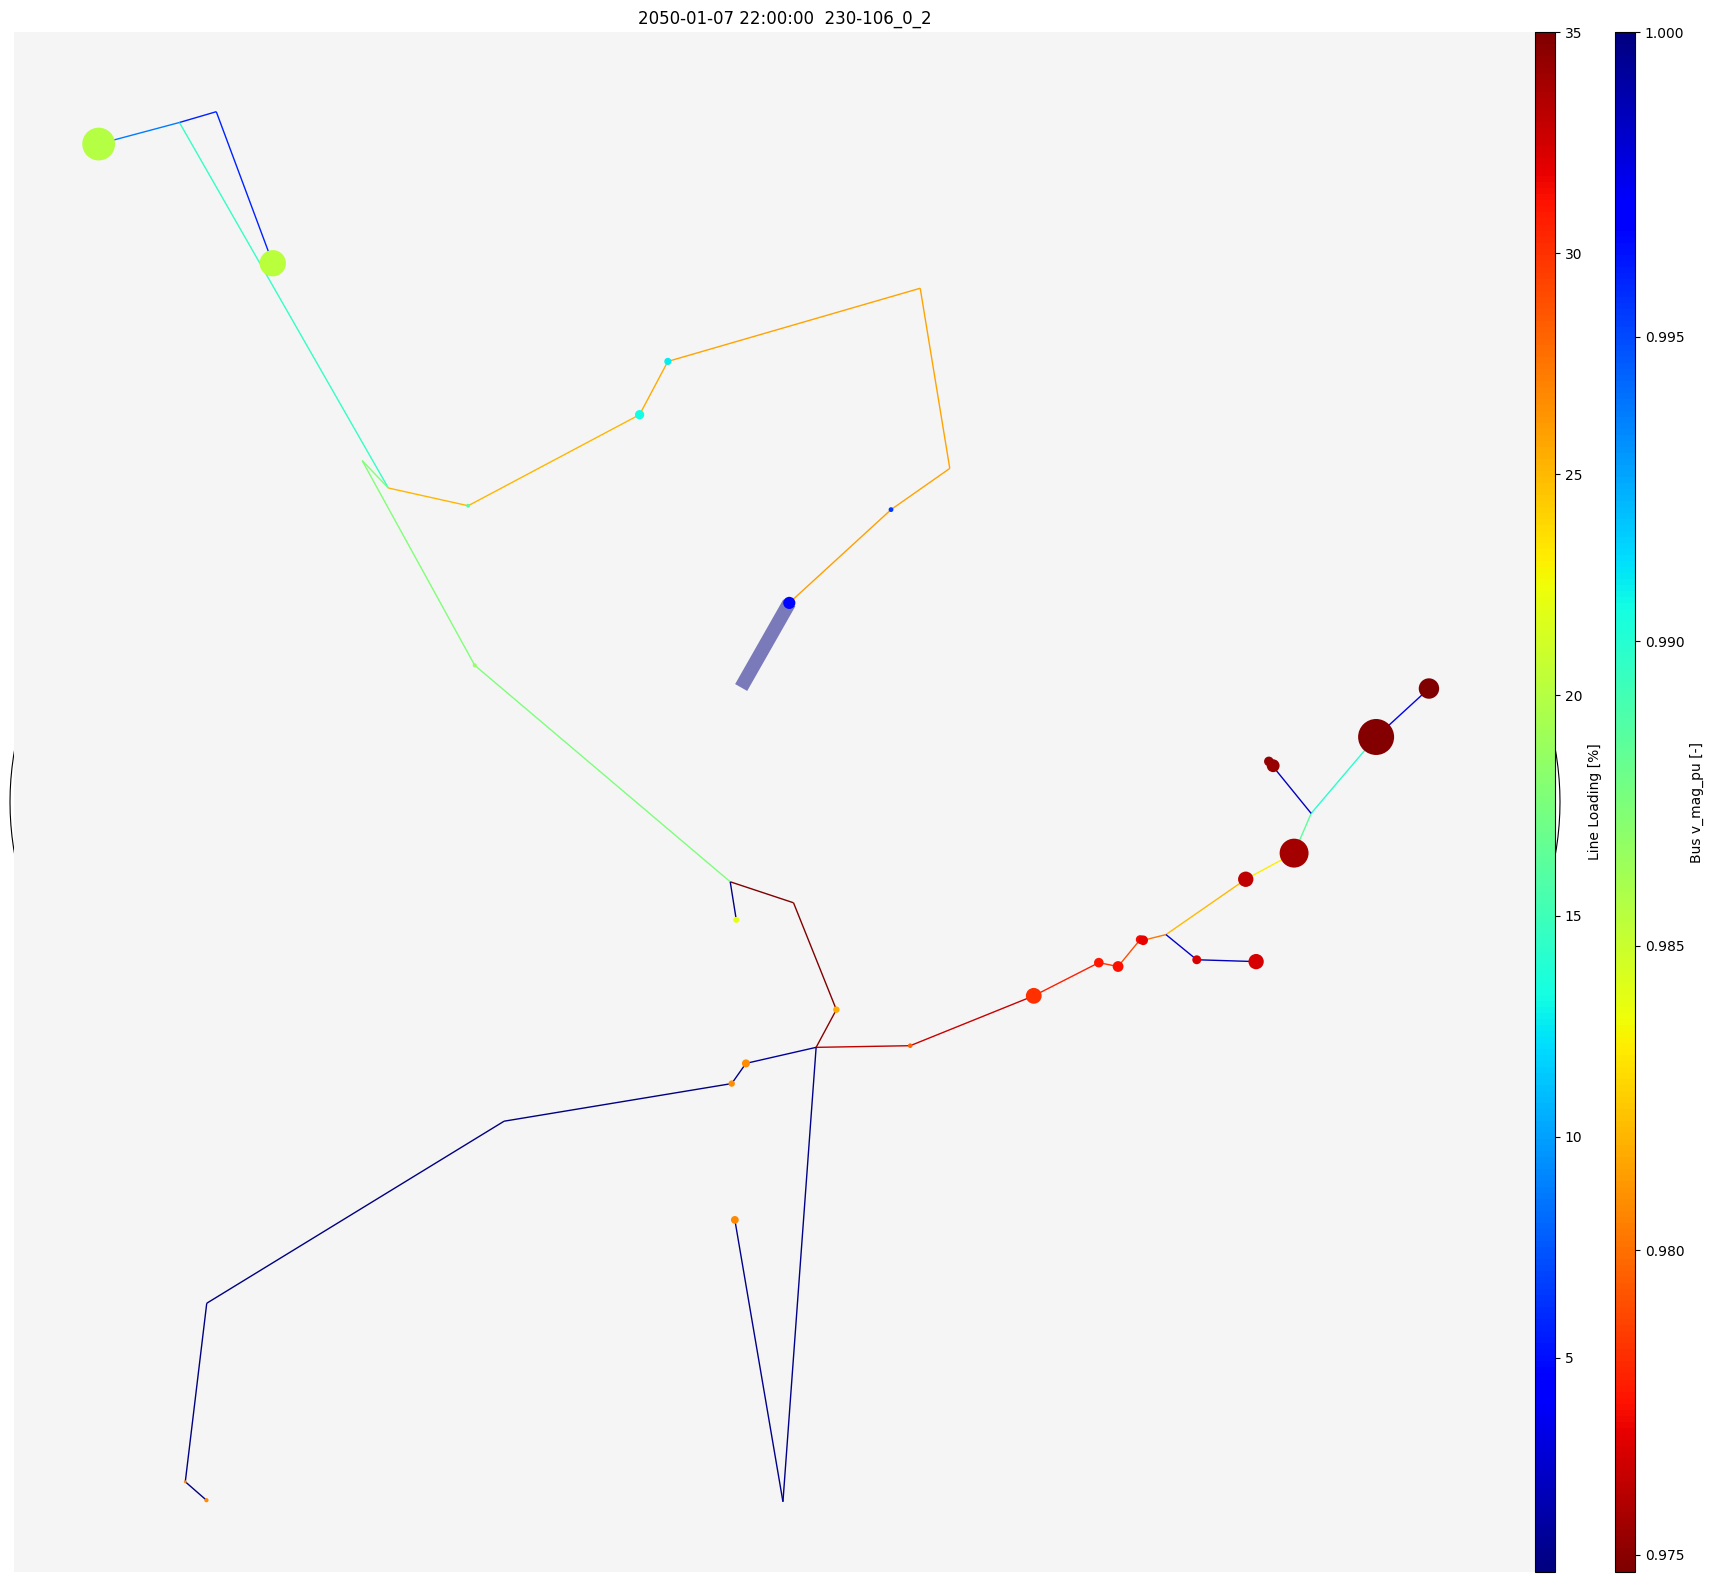

/usr/local/Caskroom/miniforge/base/envs/vtog/lib/python3.10/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning:

facecolor will have no effect as it has been defined as "never".



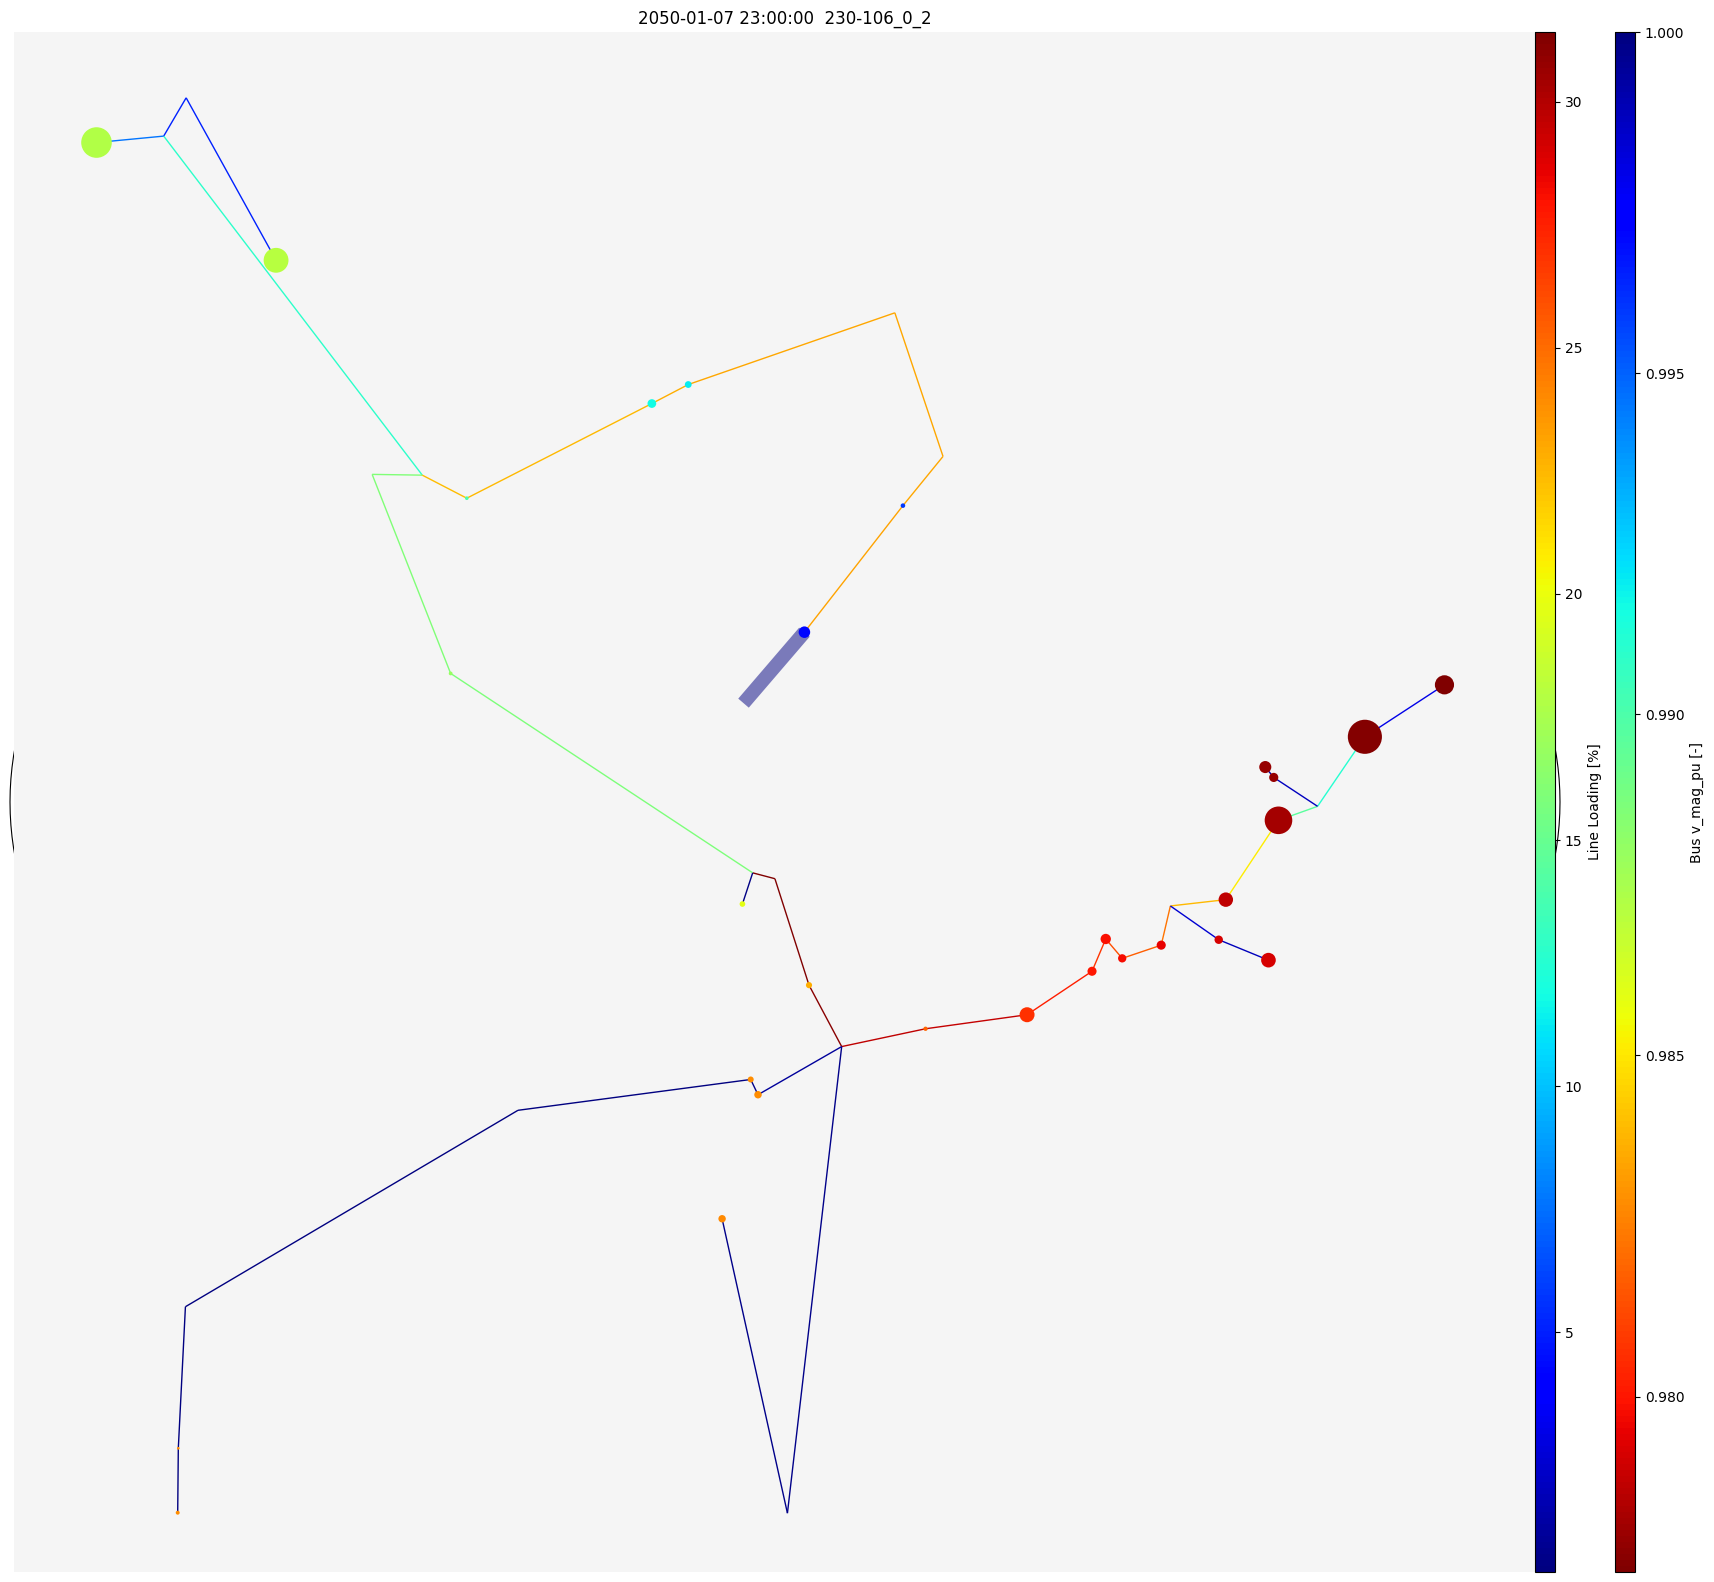

In [18]:
loading_res=loading_res(net_optimized)
hourly_visualize(MV_feeder,net_optimized, None, loading_res)

In [19]:
def plot_profiles(net_optimized,net):#save_paths
    base_load_idx = net_optimized.loads.loc[net.loads.index.str.contains('base')].index
    # ev_load_idx = net_optimized.loads.loc[net.loads.index.str.contains('ev')].index
    pv_optimized_idx = net_optimized.generators.loc[net.generators.index.str.contains('PV')].index
    # pv_idx = net.generators.loc[net.generators.index.str.contains('PV')].index
    plt.subplots(figsize=(10, 6))
    plt.plot(net_optimized.loads_t.p_set[base_load_idx].sum(axis=1), label='building base')
    plt.plot(net.storage_units_t.p_set[net.storage_units_t.p_set>=0].sum(axis=1),label='ev discharge')
    plt.plot(-net.storage_units_t.p_set[net.storage_units_t.p_set<0].sum(axis=1),label='ev charge')
    plt.plot(net_optimized.storage_units_t.p_dispatch.sum(axis=1),label='ev discharge optimized')
    plt.plot(net_optimized.storage_units_t.p_store.sum(axis=1),label='ev charge optmized')
    plt.plot(net_optimized.generators_t.p[pv_optimized_idx].sum(axis=1), label='PV_optimized')
    # plt.plot(net.generators_t.p_set[pv_idx].sum(axis=1),label='PV')
    plt.legend()
    plt.tight_layout()
    plt.show()
    # plt.savefig(f"{save_paths[i]}/network_profiles.png")
    # plt.clf()
    return 0

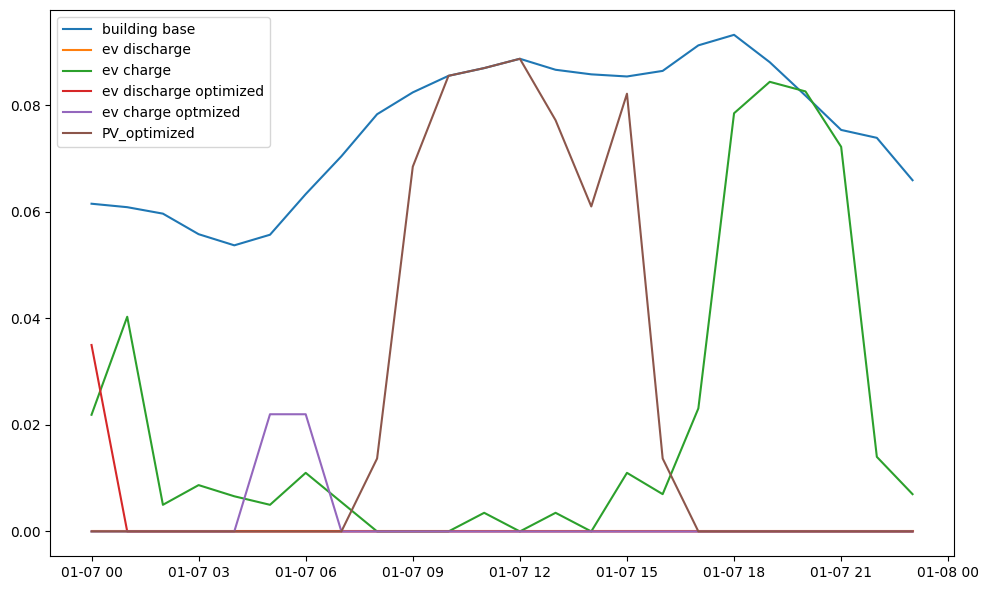

0

In [20]:
plot_profiles(net_optimized,nets[1])

In [21]:
# Check no activity while not connected
net_optimized.storage_units_t.p[pd.DataFrame(net_optimized.storage_units_t.parking_hr==0)].sum().sum()

0.0

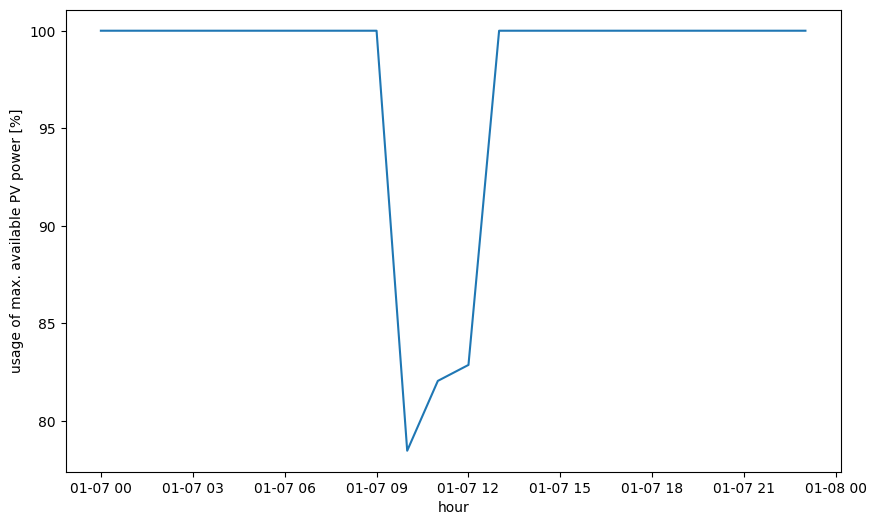

In [22]:
# Check PV power production compared to max. available
PV_idx = net_optimized.generators.loc[net_optimized.generators.index.str.contains('PV')].index
plt.subplots(figsize=(10,6))
plt.xlabel('hour')
plt.ylabel('usage of max. available PV power [%]')
plt.plot(((net_optimized.generators_t.p[PV_idx]/nets[1].generators_t.p_set[PV_idx])*100).fillna(100).mean(axis=1))
